# Input data and gene lists

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
pd.options.display.max_columns = None
%matplotlib inline
pd.options.display.max_rows = None
from venn import venn
from scipy.stats import fisher_exact

In [3]:
tel_genes_list = pd.read_csv ("../immortal_simon/annovar/TelNet_2093GeneList.csv")
#Telnet telomere related gene list

In [4]:
top_tel_genes_list =tel_genes_list[tel_genes_list["TelNet Score"]>=3].sort_values(by=["Gene symbol"])
# Top 267 telomere-related genes (TelNet score >=3, max=10)

In [5]:
cp_genes_list = pd.read_csv ("../immortal_simon/annovar/CRsandHP_923GeneList.csv")
# 912 CRs and HP gene list 

In [6]:
cancer_gene_list = pd.read_csv ("../immortal_simon/annovar/Cancer Census genes_Census_allWed Jun 10 09 31 19 2020.csv")

In [7]:
alt_list = ['JFCF_6_T_1_M','JFCF_6_T_1_Q','JFCF_6_T_1_D','JFCF_6_T_1J_11E','JFCF_6_T_1J_1_3C','JFCF_6_T_1_L',
            'JFCF_6_T_1_P_ALT','JFCF_6_T_1_R','JFCF_6_T_5K']

In [8]:
tel_list = ['JFCF_6_T_1_C','JFCF_6_T_1_F','JFCF_6_T_1_G','JFCF_6_T_1_H','JFCF_6_T_1J_11C','JFCF_6_T_1J_6B',
           'JFCF_6_T_1_P_TEL','JFCF_6_T_2H']

In [9]:
mg_exc_df = pd.read_csv("../immortal_simon/annovar/annovar_mutect_gridss_coding_split.tsv", sep="\t")
# this data cantains somatic short mutations and SVs, as well as the germline coding exonic SVs 
# Just SVs in this data is filtered with Bedtool to focus on coding exonic data; all feature_fusion SVs were droped.
# this data still contains all types of somatic short mutations, including 5/3 UTR, down/up-stream...
# exonic in ANNOVAR just means the coding region of a exon (excluding UTR5/3)
# ncRNA_exonic in ANNOVAR indicates the "coding" region of a ncRNA exon (excluding UTR5/3)
# it is notable that this data contains both proteins and ncRNAs' exonic short mutations and coding exonic SVs

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
mg_exc_df.shape

(24274, 70)

In [11]:
mg_exc_df[mg_exc_df["Gene"].str.contains("TERT")]
# no TERT mutation

Empty DataFrame
Columns: [Key, Name, Source, dbSNP, Type, Chr1, Pos1, Chr2, Pos2, Qual1, Qual2, AF1, AF2, Read1, Read2, Gene, Consequence, Impact, Ref1, Alt1, Ref2, Alt2, exon_count, GeneDetail.refGene, ExonicFunc.refGene, AAChange.refGene, cytoBand, ExAC_ALL, ExAC_AFR, ExAC_AMR, ExAC_EAS, ExAC_FIN, ExAC_NFE, ExAC_OTH, ExAC_SAS, avsnp147, SIFT_score, SIFT_pred, Polyphen2_HDIV_score, Polyphen2_HDIV_pred, Polyphen2_HVAR_score, Polyphen2_HVAR_pred, LRT_score, LRT_pred, MutationTaster_score, MutationTaster_pred, MutationAssessor_score, MutationAssessor_pred, FATHMM_score, FATHMM_pred, PROVEAN_score, PROVEAN_pred, VEST3_score, CADD_raw, CADD_phred, DANN_score, fathmm-MKL_coding_score, fathmm-MKL_coding_pred, MetaSVM_score, MetaSVM_pred, MetaLR_score, MetaLR_pred, integrated_fitCons_score, integrated_confidence_value, GERP++_RS, phyloP7way_vertebrate, phyloP20way_mammalian, phastCons7way_vertebrate, phastCons20way_mammalian, SiPhy_29way_logOdds]
Index: []

In [12]:
mg_exc_df['Consequence'].unique()
# no feature_fusion

array(['transcript_ablation', 'gene_fusion&frameshift_variant',
       'gene_fusion', 'bidirectional_gene_fusion', nan], dtype=object)

In [13]:
mg_exc_df[(mg_exc_df["Type"]=="UTR3")&(mg_exc_df["Name"]!="JFCF_6")]["Gene"].unique().shape
# 125 genes with somatic 5UTR mutation; 871 genes with somtic 3UTR mutation  

(887,)

In [14]:
mg_exc_df["Type"].unique()

array(['Translocations', 'Deletion', 'Duplication', 'Inversion',
       'Insertion', 'ncRNA_exonic', 'downstream', 'UTR5', 'upstream',
       'exonic', 'UTR3', 'splicing', 'ncRNA_splicing',
       'upstream;downstream'], dtype=object)

In [15]:
mg_exc_df["ExonicFunc.refGene"].unique()
# "Type" and "ExonicFunc.refGene", these two columns indicate mutation types from GRIDSS and MUTECT2 seperately

array([nan, '.', 'nonsynonymous SNV', 'synonymous SNV', 'stopgain',
       'frameshift deletion', 'nonframeshift substitution', 'unknown',
       'nonframeshift insertion', 'frameshift insertion', 'stoploss',
       'nonframeshift deletion'], dtype=object)

In [16]:
mg_exc_df["Impact"].unique()

array(['HIGH', nan], dtype=object)

# Somatic short mutation and SVs

## Exonic somatic mutation (not including UTR in this analysis)

In [17]:
sm_mg_all = mg_exc_df[(mg_exc_df['Name']!="JFCF_6")&(~mg_exc_df['Key'].str.contains("Immortal"))]
sm_short_all = sm_mg_all[sm_mg_all["Source"]=="MuTect2"]
# just somatic mutation, including synonymous SNV
# all short somatic mutations

In [20]:
sm_mg_all.shape

(5986, 70)

In [21]:
sm_short_all.shape

(5048, 70)

## Coding exonic somatic short mutations and SVs (including ncRNA)

In [22]:
Type_list_coding = ['Translocations', 'Insertion', 'Deletion', 'Duplication',
       'Inversion','exonic','splicing','ncRNA_exonic','ncRNA_splicing']
# do not include UTR data
# including ncRNA mutations

In [23]:
sm_mg_exc_df = mg_exc_df[(mg_exc_df['Name']!="JFCF_6")&(~mg_exc_df['Key'].str.contains("Immortal"))&(mg_exc_df['Type'].isin(Type_list_coding))
                 &(mg_exc_df['ExonicFunc.refGene']!="synonymous SNV")] 
sm_mg_exc_df.shape
# does not include synonymous SNV
# including ncRNA mutations

(2284, 70)

In [24]:
sm_mg_exc_df["Gene"].unique().shape

(1335,)

In [39]:
sm_mg_exc_df[(sm_mg_exc_df['Gene'].str.contains("TCOF1"))]
# somatic TCOF1 SVs and short mutations

Key          Name  Source  \
7078  SV_GRIDSS_HIGH_TCOF1_Somatic_chr5_149759805_14...  JFCF_6_T_1_M  GRIDSS   

      dbSNP         Type  Chr1                 Pos1  Chr2  \
7078  False  Duplication  chr5  149759805-149759808  chr5   

                     Pos2                        Qual1  \
7078  149945464-149945467  NotSplit:74.22;Split:108.66   

                            Qual2  AF1  AF2               Read1  \
7078  NotSplit:74.22;Split:108.66  NaN  NaN  NotSplit:4;Split:4   

                   Read2   Gene          Consequence Impact Ref1  \
7078  NotSplit:4;Split:4  TCOF1  transcript_ablation   HIGH    A   

                   Alt1 Ref2               Alt2  exon_count  \
7078  ]CHR5:149945466]A    G  G[CHR5:149759807[       127.0   

     GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand ExAC_ALL  \
7078                NaN                NaN              NaN      NaN      NaN   

     ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
7078      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

     SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
7078        NaN       NaN                  NaN                 NaN   

     Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
7078                  NaN                 NaN       NaN      NaN   

     MutationTaster_score MutationTaster_pred MutationAssessor_score  \
7078                  NaN                 NaN                    NaN   

     MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
7078                   NaN          NaN         NaN           NaN   

     PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
7078          NaN         NaN      NaN        NaN        NaN   

     fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
7078                     NaN                    NaN           NaN   

     MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
7078          NaN          NaN         NaN                      NaN   

     integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
7078                         NaN       NaN                   NaN   

     phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
7078                   NaN                      NaN                      NaN   

     SiPhy_29way_logOdds  
7078                 NaN

In [30]:
sm_mg_exc_df[sm_mg_exc_df['Consequence']=="feature_fusion"]
# double chack that there is no "none coding SV"

Empty DataFrame
Columns: [Key, Name, Source, dbSNP, Type, Chr1, Pos1, Chr2, Pos2, Qual1, Qual2, AF1, AF2, Read1, Read2, Gene, Consequence, Impact, Ref1, Alt1, Ref2, Alt2, exon_count, GeneDetail.refGene, ExonicFunc.refGene, AAChange.refGene, cytoBand, ExAC_ALL, ExAC_AFR, ExAC_AMR, ExAC_EAS, ExAC_FIN, ExAC_NFE, ExAC_OTH, ExAC_SAS, avsnp147, SIFT_score, SIFT_pred, Polyphen2_HDIV_score, Polyphen2_HDIV_pred, Polyphen2_HVAR_score, Polyphen2_HVAR_pred, LRT_score, LRT_pred, MutationTaster_score, MutationTaster_pred, MutationAssessor_score, MutationAssessor_pred, FATHMM_score, FATHMM_pred, PROVEAN_score, PROVEAN_pred, VEST3_score, CADD_raw, CADD_phred, DANN_score, fathmm-MKL_coding_score, fathmm-MKL_coding_pred, MetaSVM_score, MetaSVM_pred, MetaLR_score, MetaLR_pred, integrated_fitCons_score, integrated_confidence_value, GERP++_RS, phyloP7way_vertebrate, phyloP20way_mammalian, phastCons7way_vertebrate, phastCons20way_mammalian, SiPhy_29way_logOdds]
Index: []

In [31]:
sm_mg_exc_df[sm_mg_exc_df['Gene'].str.contains("LINC01324")]
# this data contains ncRNA exonic coding SVs results

Key          Name  \
1354   SV_GRIDSS_HIGH_LINC01324_Somatic_chr3_16444452...  JFCF_6_T_1_F   
1356   SV_GRIDSS_HIGH_LINC01324_Somatic_chr3_16445243...  JFCF_6_T_1_F   
1358   SV_GRIDSS_HIGH_LINC01324_Somatic_chr3_16445254...  JFCF_6_T_1_F   
10953  SV_GRIDSS_HIGH_LINC01324_Somatic_chr3_16445229...  JFCF_6_T_1_F   
10955  SV_GRIDSS_HIGH_LINC01324_Somatic_chr3_16445254...  JFCF_6_T_1_F   
10957  SV_GRIDSS_HIGH_LINC01324_Somatic_chr3_16445259...  JFCF_6_T_1_F   
23652  SV_GRIDSS_HIGH_LINC01324&WDR49_Somatic_chr3_16...  JFCF_6_T_1_F   
23656  SV_GRIDSS_HIGH_LINC01324&PEX5L_Somatic_chr3_16...  JFCF_6_T_1_F   

       Source  dbSNP            Type  Chr1                 Pos1  Chr2  \
1354   GRIDSS  False  Translocations  chr3  164444526-164444528  chr8   
1356   GRIDSS  False  Translocations  chr3  164452434-164452435  chr8   
1358   GRIDSS  False  Translocations  chr3  164452549-164452552  chr8   
10953  GRIDSS  False     Duplication  chr3  164452292-164452293  chr3   
10955  GRIDSS  False        Deletion  chr3  164452542-164452550  chr3   
10957  GRIDSS  False        Deletion  chr3  164452598-164452602  chr3   
23652  GRIDSS  False       Inversion  chr3  164452433-164452436  chr3   
23656  GRIDSS  False     Duplication  chr3  164452603-164452610  chr3   

                      Pos2                         Qual1  \
1354   126793536-126793538  NotSplit:201.64;Split:129.53   
1356   128041731-128041732  NotSplit:201.64;Split:187.55   
1358   132522497-132522500   NotSplit:18.33;Split:111.47   
10953  174511534-174511535       NotSplit:0;Split:156.91   
10955  176123579-176123587          NotSplit:0;Split:282   
10957  176139646-176139650       NotSplit:0;Split:109.81   
23652  167254573-167254576   NotSplit:18.33;Split:155.21   
23656  179678671-179678678  NotSplit:201.64;Split:100.39   

                              Qual2  AF1  AF2                Read1  \
1354   NotSplit:201.64;Split:129.53  NaN  NaN  NotSplit:11;Split:5   
1356   NotSplit:201.64;Split:187.55  NaN  NaN  NotSplit:11;Split:7   
1358    NotSplit:18.33;Split:111.47  NaN  NaN   NotSplit:1;Split:4   
10953       NotSplit:0;Split:156.91  NaN  NaN   NotSplit:0;Split:6   
10955          NotSplit:0;Split:282  NaN  NaN  NotSplit:0;Split:11   
10957       NotSplit:0;Split:109.81  NaN  NaN   NotSplit:0;Split:4   
23652   NotSplit:18.33;Split:155.21  NaN  NaN   NotSplit:1;Split:6   
23656  NotSplit:201.64;Split:100.39  NaN  NaN  NotSplit:11;Split:4   

                     Read2       Gene                     Consequence Impact  \
1354   NotSplit:11;Split:5  LINC01324             transcript_ablation   HIGH   
1356   NotSplit:11;Split:7  LINC01324             transcript_ablation   HIGH   
1358    NotSplit:1;Split:4  LINC01324             transcript_ablation   HIGH   
10953   NotSplit:0;Split:6  LINC01324             transcript_ablation   HIGH   
10955  NotSplit:0;Split:11  LINC01324             transcript_ablation   HIGH   
10957   NotSplit:0;Split:4  LINC01324             transcript_ablation   HIGH   
23652   NotSplit:1;Split:6  LINC01324       bidirectional_gene_fusion   HIGH   
23656  NotSplit:11;Split:4  LINC01324  gene_fusion&frameshift_variant   HIGH   

      Ref1                    Alt1 Ref2                    Alt2  exon_count  \
1354     T       [CHR8:126793538[T    A       [CHR3:164444527[A         NaN   
1356     C       ]CHR8:128041732]C    G       G[CHR3:164452435[         NaN   
1358     A       ]CHR8:132522499]A    A       A[CHR3:164452551[         NaN   
10953    C  ]CHR3:174511535]TAGATC    A  ATAGAT[CHR3:164452293[      1550.0   
10955    T       T[CHR3:176123583[    T       ]CHR3:164452546]T      1564.0   
10957    A       A[CHR3:176139648[    A       ]CHR3:164452600]A      1564.0   
23652    C       C]CHR3:167254575]    A       A]CHR3:164452435]       156.0   
23656    A       ]CHR3:179678675]A    A       A[CHR3:164452607[      2133.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
1354                 NaN                NaN       

In [32]:
sm_mg_exc_df[sm_mg_exc_df['Gene'].str.contains("ZNF827")]
# ZNF827 contamination 

Key              Name  \
10635  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...      JFCF_6_T_1_C   
10636  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...      JFCF_6_T_1_F   
10637  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...      JFCF_6_T_1_G   
10638  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...      JFCF_6_T_1_H   
10639  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...   JFCF_6_T_1J_11C   
10640  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...   JFCF_6_T_1J_11E   
10641  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...      JFCF_6_T_1_L   
10642  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...  JFCF_6_T_1_P_ALT   
10643  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...  JFCF_6_T_1_P_TEL   
10654  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...      JFCF_6_T_1_C   
10655  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...      JFCF_6_T_1_D   
10656  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...      JFCF_6_T_1_F   
10657  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...      JFCF_6_T_1_G   
10658  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...      JFCF_6_T_1_H   
10659  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...   JFCF_6_T_1J_11C   
10660  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...   JFCF_6_T_1J_11E   
10661  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...      JFCF_6_T_1_L   
10662  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...  JFCF_6_T_1_P_ALT   
10663  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...  JFCF_6_T_1_P_TEL   
11399  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146767164_1...  JFCF_6_T_1_P_ALT   

       Source  dbSNP      Type  Chr1                 Pos1  Chr2  \
10635  GRIDSS  False  Deletion  chr4  146807211-146807212  chr4   
10636  GRIDSS  False  Deletion  chr4  146807211-146807212  chr4   
10637  GRIDSS  False  Deletion  chr4  146807211-146807212  chr4   
10638  GRIDSS  False  Deletion  chr4  146807211-146807212  chr4   
10639  GRIDSS  False  Deletion  chr4  146807211-146807212  chr4   
10640  GRIDSS  False  Deletion  chr4  146807211-146807212  chr4   
10641  GRIDSS  False  Deletion  chr4  146807211-146807212  chr4   
10642  GRIDSS  False  Deletion  chr4  146807211-146807212  chr4   
10643  GRIDSS  False  Deletion  chr4  146807211-146807212  chr4   
10654  GRIDSS  False  Deletion  chr4  146824366-146824367  chr4   
10655  GRIDSS  False  Deletion  chr4  146824366-146824367  chr4   
10656  GRIDSS  False  Deletion  chr4  146824366-146824367  chr4   
10657  GRIDSS  False  Deletion  chr4  146824366-146824367  chr4   
10658  GRIDSS  False  Deletion  chr4  146824366-146824367  chr4   
10659  GRIDSS  False  Deletion  chr4  146824366-146824367  chr4   
10660  GRIDSS  False  Deletion  chr4  146824366-146824367  chr4   
10661  GRIDSS  False  Deletion  chr4  146824366-146824367  chr4   
10662  GRIDSS  False  Deletion  chr4  146824366-146824367  chr4   
10663  GRIDSS  False  Deletion  chr4  146824366-146824367  chr4   
11399  GRIDSS  False  Deletion  chr4  146767164-146767168  chr4   

                      Pos2                         Qual1  \
10635  146823317-146823318  NotSplit:479.78;Split:319.62   
10636  146823317-146823318  NotSplit:403.27;Split:196.97   
10637  146823317-146823318  NotSplit:313.83;Split:335.65   
10638  146823317-146823318  NotSplit:163.83;Split:171.71   
10639  146823317-146823318    NotSplit:199.65;Split:28.3   
10640  146823317-146823318  NotSplit:165.69;Split:168.24   
10641  146823317-146823318   NotSplit:273.96;Split:147.4   
10642  146823317-146823318  NotSplit:491.15;Split:286.55   
10643  146823317-146823318  NotSplit:165.15;Split:230.39   
10654  146859516-146859517   NotSplit:92.26;Split:332.77   
10655  146859516-146859517   NotSplit:17.81;Split:112.35   
10656  146859516-146859517   NotSplit:54.99;Split:650.74   
10657  146859516-146859517   NotSplit:55.38;Split:202.04   
10658  146859516-146859517   NotSplit:36.41;Split:114.92   
10659  146859516-146859517    NotSplit:36.3;Split:290.68   
10660  146859516-146859517   NotSplit:73.64;Sp

In [37]:
sm_mg_exc_df[sm_mg_exc_df['Gene'].str.contains("ZNF827")]["Name"].unique().shape

(10,)

In [40]:
sm_mg_exc_df[sm_mg_exc_df['Gene'].str.contains("ATRX")]
# ATRX mutation

Key              Name  \
10370  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76885052_7688...      JFCF_6_T_1_M   
10591  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76808603_7680...      JFCF_6_T_1_Q   
10943  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76862268_7686...      JFCF_6_T_1_D   
11314  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76853017_7685...   JFCF_6_T_1J_11E   
11315  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76853017_7685...  JFCF_6_T_1J_1_3C   
11397  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76795540_7679...      JFCF_6_T_1_L   
11555  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76788737_7678...      JFCF_6_T_1_R   
11639  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76783771_7678...       JFCF_6_T_5K   
13789  MuTect2_exonic_ATRX_JFCF-6_T_1_PALT_chrX_76938...  JFCF_6_T_1_P_ALT   
21370  SV_GRIDSS_HIGH_ATRX&KRBA1_Somatic_chr7_1494188...       JFCF_6_T_5K   
21374  SV_GRIDSS_HIGH_ATRX&SSPO_Somatic_chr7_14947961...       JFCF_6_T_5K   
21378  SV_GRIDSS_HIGH_ATRX&SSPO_Somatic_chr7_14947963...       JFCF_6_T_5K   
21382  SV_GRIDSS_HIGH_ATRX&SSPO_Somatic_chr7_14947995...       JFCF_6_T_5K   

        Source  dbSNP            Type  Chr1                 Pos1  Chr2  \
10370   GRIDSS  False     Duplication  chrX    76885052-76885055  chrX   
10591   GRIDSS  False        Deletion  chrX    76808603-76808606  chrX   
10943   GRIDSS  False        Deletion  chrX    76862268-76862269  chrX   
11314   GRIDSS  False        Deletion  chrX    76853017-76853018  chrX   
11315   GRIDSS  False        Deletion  chrX    76853017-76853018  chrX   
11397   GRIDSS  False        Deletion  chrX    76795540-76795542  chrX   
11555   GRIDSS  False        Deletion  chrX    76788737-76788738  chrX   
11639   GRIDSS  False     Duplication  chrX    76783771-76783774  chrX   
13789  MuTect2    NaN          exonic  chrX             76938581   NaN   
21370   GRIDSS  False  Translocations  chr7  149418856-149418857  chrX   
21374   GRIDSS  False  Translocations  chr7  149479619-149479624  chrX   
21378   GRIDSS  False  Translocations  chr7  149479631-149479633  chrX   
21382   GRIDSS  False  Translocations  chr7  149479955-149479956  chrX   

                    Pos2                         Qual1  \
10370  76923999-76924002  NotSplit:204.12;Split:318.66   
10591  76875533-76875536   NotSplit:141.33;Split:96.28   
10943  77034579-77034580       NotSplit:249.27;Split:0   
11314  77014863-77014864  NotSplit:239.33;Split:302.85   
11315  77014863-77014864  NotSplit:343.72;Split:285.82   
11397  76940486-76940488  NotSplit:237.43;Split:194.13   
11555  76876903-76876904       NotSplit:186.78;Split:0   
11639  76840055-76840058  NotSplit:256.58;Split:114.96   
13789                NaN                           NaN   
21370  76917250-76917251        NotSplit:0;Split:92.74   
21374  76783762-76783767    NotSplit:91.63;Split:132.7   
21378  76917220-76917222        NotSplit:0;Split:88.27   
21382  76782881-76782882  NotSplit:109.96;Split:133.03   

                              Qual2  AF1  AF2                 Read1  \
10370  NotSplit:204.12;Split:318.66  NaN  NaN  NotSplit:11;Split:12   
10591   NotSplit:141.33;Split:96.28  NaN  NaN    NotSplit:8;Split:4   
10943       NotSplit:249.27;Split:0  NaN  NaN   NotSplit:14;Split:0   
11314  NotSplit:239.33;Split:302.85  NaN  NaN  NotSplit:13;Split:12   
11315  NotSplit:343.72;Split:285.82  NaN  NaN  NotSplit:19;Split:11   
11397  NotSplit:237.43;Split:194.13  NaN  NaN   NotSplit:13;Split:7   
11555       NotSplit:186.78;Split:0  NaN  NaN   NotSplit:10;Split:0   
11639  NotSplit:256.58;Split:114.96  NaN  NaN   NotSplit:14;Split:4   
13789                           NaN  NaN  NaN                   NaN   
21370        NotSplit:0;Split:92.74  NaN  NaN    NotSplit:0;Split:3   
21374    NotSplit:91.63;Split:132.7  NaN  NaN    NotSplit:5;Split:5   
21378        NotSplit:0;Split:88.27  NaN  NaN    NotSplit:0;Split:3   
21382  NotSplit:109.96;Split:133.03  NaN  NaN    NotSplit:6;Split:5   

                      Read2  Gene                     Consequence Impact Ref1  \
10370  NotSplit:11;Split:12  ATRX 

In [41]:
sm_mg_exc_df["Gene"].unique().shape
# 1335 mutated genes in total

(1335,)

In [42]:
sm_mg_exc_df["Gene"][sm_mg_exc_df['Source']=='MuTect2'].unique().shape
# 859 genes with short mutations (no UTR3/5 mutations)

(859,)

In [43]:
sm_mg_exc_df["Gene"][sm_mg_exc_df['Source']=='GRIDSS'].unique().shape
# 513 genes with exonic SVs

(513,)

In [44]:
sm_mg_exc_df[(sm_mg_exc_df['Type'].str.contains("splicing"))]["Gene"].unique().shape
# 28 genes with somatic splicing short mutations

(28,)

In [45]:
sm_mg_exc_df.to_csv("../results/Splitted_All_non-silent_short&SV_mutations_20200620_Shawn.csv", index=1)

In [65]:
sm_mg_exc_df_gene_ALT = sm_mg_exc_df[sm_mg_exc_df["Name"].isin(alt_list)]["Gene"].unique()

In [66]:
sm_mg_exc_df_gene_TEL = sm_mg_exc_df[sm_mg_exc_df["Name"].isin(tel_list)]["Gene"].unique()

In [63]:
mutated_genes_overlap= {
    'TEL': set(sm_mg_exc_df[sm_mg_exc_df["Name"].isin(tel_list)]["Gene"].unique()),
    'ALT': set(sm_mg_exc_df[sm_mg_exc_df["Name"].isin(alt_list)]["Gene"].unique())
}

In [68]:
pd.Series(sm_mg_exc_df_gene_ALT).to_csv("../results/Splitted_ALT_non-silent_short&SV_genes_20200620_Shawn.csv", index=1)
pd.Series(sm_mg_exc_df_gene_TEL).to_csv("../results/Splitted_TEL_non-silent_short&SV_genes_20200620_Shawn.csv", index=1)

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


Text(0.5, 1.0, 'TEL/ALT/Mortal Distinct mutated gene')

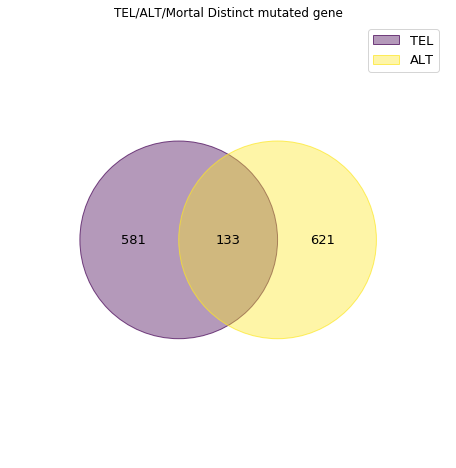

In [64]:
venn(mutated_genes_overlap)
plt.title("TEL/ALT/Mortal Distinct mutated gene")

In [53]:
sm_mg_exc_df[sm_mg_exc_df["Name"].isin(tel_list)]["Gene"].unique().shape

(714,)

In [39]:
sm_mg_exc_df[(sm_mg_exc_df['Type'].str.contains("splicing"))&(sm_mg_exc_df['Gene'].isin(tel_genes_list["Gene symbol"]))]
#For CDK13 (telomere-related gene), 3-AG loss at splicing site

Key          Name  \
19968  MuTect2_splicing_CDK13_JFCF_61Q_chr7_40127722_...  JFCF_6_T_1_Q   
20121  MuTect2_splicing_ATAD5_JFCF_61Q_chr17_29192720...  JFCF_6_T_1_Q   

        Source dbSNP      Type   Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  \
19968  MuTect2   NaN  splicing   chr7  40127722  NaN  NaN   NaN   NaN  NaN   
20121  MuTect2   NaN  splicing  chr17  29192720  NaN  NaN   NaN   NaN  NaN   

       AF2 Read1 Read2   Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  \
19968  NaN   NaN   NaN  CDK13         NaN    NaN  CAG  TTT  NaN  NaN   
20121  NaN   NaN   NaN  ATAD5         NaN    NaN    A    T  NaN  NaN   

       exon_count            GeneDetail.refGene ExonicFunc.refGene  \
19968         NaN                             .                  .   
20121         NaN  NM_024857:exon11:c.3137-2A>T                  .   

      AAChange.refGene cytoBand ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN  \
19968                .   7p14.1        .        .        .        .        .   
20121                .  17q11.2        .        .        .        .        .   

      ExAC_NFE ExAC_OTH ExAC_SAS avsnp147 SIFT_score SIFT_pred  \
19968        .        .        .        .          .         .   
20121        .        .        .        .          .         .   

      Polyphen2_HDIV_score Polyphen2_HDIV_pred Polyphen2_HVAR_score  \
19968                    .                   .                    .   
20121                    .                   .                    .   

      Polyphen2_HVAR_pred LRT_score LRT_pred MutationTaster_score  \
19968                   .         .        .                    .   
20121                   .         .        .                    1   

      MutationTaster_pred MutationAssessor_score MutationAssessor_pred  \
19968                   .                      .                     .   
20121                   D                      .                     .   

      FATHMM_score FATHMM_pred PROVEAN_score PROVEAN_pred VEST3_score  \
19968            .           .             .            .           .   
20121            .           .             .            .           .   

      CADD_raw CADD_phred DANN_score fathmm-MKL_coding_score  \
19968        .          .          .                       .   
20121    4.327       24.0      0.987                   0.981   

      fathmm-MKL_coding_pred MetaSVM_score MetaSVM_pred MetaLR_score  \
19968                      .             .            .            .   
20121                      D             .            .            .   

      MetaLR_pred integrated_fitCons_score integrated_confidence_value  \
19968           .                        .                           .   
20121           .                    0.164                           0   

      GERP++_RS phyloP7way_vertebrate phyloP20way_mammalian  \
19968         .                     .                     .   
20121      5.38                 1.062                 1.178   

      phastCons7way_vertebrate phastCons20way_mammalian SiPhy_29way_logOdds  
19968                        .                        .                   .  
20121                    0.986                    0.987               15.48

In [83]:
sm_mg_exc_df[sm_mg_exc_df["Type"]=="Translocations"].sort_values(by="Gene")["Key"].unique().shape

(183,)

In [40]:
sm_mg_exc_df["Type"].unique()

array(['Translocations', 'Deletion', 'Duplication', 'Inversion',
       'Insertion', 'ncRNA_exonic', 'ncRNA_splicing', 'exonic',
       'splicing'], dtype=object)

## Non-silent coding exonic mutations

In [764]:
sm_mg_ns_exc_df = sm_mg_exc_df[(sm_mg_exc_df["Type"] != "ncRNA_exonic") & (sm_mg_exc_df["Type"] != "ncRNA_splicing")]

In [765]:
sm_mg_ns_exc_df["Gene"].unique().shape

(966,)

In [767]:
sm_mg_ns_exc_df[sm_mg_ns_exc_df["Name"]=='JFCF_6_T_1J_6B']["Key"].unique().shape

(116,)

## Non-silent TelNet related short mutations and SVs

In [42]:
sm_mg_exc_tel= sm_mg_exc_df[(sm_mg_exc_df['Gene'].isin(tel_genes_list["Gene symbol"]))]

In [43]:
sm_mg_exc_tel.sort_values(by=['Gene'])["Gene"].unique().shape
# 84 teloemre-related genes (exonic SVs + exonic/splicing short mutations)

(84,)

In [51]:
sm_mg_exc_tel[sm_mg_exc_tel["Source"]=="MuTect2"].sort_values(by="Gene")
# 55 genes with exonic/splicing short mutations

Key              Name  \
19687   MuTect2_exonic_AHNAK_JFCF_61M_chr11_62289368_A_G      JFCF_6_T_1_M   
18783  MuTect2_exonic_ANKLE1_JFCF6_T_1J_1-3C_chr19_17...  JFCF_6_T_1J_1_3C   
17571  MuTect2_exonic_ARHGAP12_JFCF-6_T_1_PALT_chr10_...  JFCF_6_T_1_P_ALT   
20121  MuTect2_splicing_ATAD5_JFCF_61Q_chr17_29192720...      JFCF_6_T_1_Q   
17675  MuTect2_exonic_ATRX_JFCF-6_T_1_PALT_chrX_76938...  JFCF_6_T_1_P_ALT   
19761  MuTect2_exonic_C17orf49_JFCF_61M_chr17_6919897...      JFCF_6_T_1_M   
15580  MuTect2_exonic_CABP2_JFCF-6_T_1J_11C_chr11_672...   JFCF_6_T_1J_11C   
19237  MuTect2_exonic_CABP2_JFCF6_T_1J_6B_chr11_67290...    JFCF_6_T_1J_6B   
18579  MuTect2_exonic_CABP2_JFCF6_T_1J_1-3C_chr11_672...  JFCF_6_T_1J_1_3C   
15855  MuTect2_exonic_CABP2_JFCF-6_T_1J_11E_chr11_672...   JFCF_6_T_1J_11E   
19968  MuTect2_splicing_CDK13_JFCF_61Q_chr7_40127722_...      JFCF_6_T_1_Q   
19975  MuTect2_exonic_CFTR_JFCF_61Q_chr7_117188841_GTT_-      JFCF_6_T_1_Q   
16463  MuTect2_exonic_CMTR1_JFCF-6_T_1_F_chr6_3744230...      JFCF_6_T_1_F   
16464  MuTect2_exonic_CMTR1_JFCF-6_T_1_F_chr6_3744230...      JFCF_6_T_1_F   
17873  MuTect2_exonic_CTC1_JFCF-6_T_1_R_chr17_8137831...      JFCF_6_T_1_R   
19677  MuTect2_exonic_DCLRE1A_JFCF_61M_chr10_11560980...      JFCF_6_T_1_M   
19527  MuTect2_exonic_DMD_JFCF6_T_1J_6B_chrX_32867895...    JFCF_6_T_1J_6B   
19273  MuTect2_exonic_EID3_JFCF6_T_1J_6B_chr12_104697...    JFCF_6_T_1J_6B   
17316  MuTect2_exonic_EIF5A2_JFCF-6_T_1_P_chr3_170612...  JFCF_6_T_1_P_TEL   
16041  MuTect2_exonic_ELOVL7_JFCF-6_T_1_C_chr5_600506...      JFCF_6_T_1_C   
19887   MuTect2_exonic_FANCD2_JFCF_61Q_chr3_10114944_A_C      JFCF_6_T_1_Q   
16806  MuTect2_exonic_GNL3L_JFCF-6_T_1_G_chrX_5457469...      JFCF_6_T_1_G   
17426  MuTect2_exonic_GREM1_JFCF-6_T_1_P_chr15_330229...  JFCF_6_T_1_P_TEL   
19962    MuTect2_exonic_HDAC9_JFCF_61Q_chr7_18868799_G_A      JFCF_6_T_1_Q   
18141  MuTect2_exonic_HIST1H4K_JFCF-6_T_5K_chr6_27799...       JFCF_6_T_5K   
18446  MuTect2_exonic_HSPA4L_JFCF6_T_1J_1-3C_chr4_128...  JFCF_6_T_1J_1_3C   
15908  MuTect2_exonic_IDH3A_JFCF-6_T_1J_11E_chr15_784...   JFCF_6_T_1J_11E   
18686  MuTect2_exonic_IDH3A_JFCF6_T_1J_1-3C_chr15_784...  JFCF_6_T_1J_1_3C   
17685  MuTect2_exonic_IPO13_JFCF-6_T_1_R_chr1_4441522...      JFCF_6_T_1_R   
15585  MuTect2_exonic_KMT2A_JFCF-6_T_1J_11C_chr11_118...   JFCF_6_T_1J_11C   
19979   MuTect2_exonic_KMT2C_JFCF_61Q_chr7_151945256_G_A      JFCF_6_T_1_Q   
17253  MuTect2_exonic_KMT5C_JFCF-6_T_1_L_chr19_558587...      JFCF_6_T_1_L   
16798  MuTect2_exonic_LPIN3_JFCF-6_T_1_G_chr20_399777...      JFCF_6_T_1_G   
17374  MuTect2_exonic_MKI67_JFCF-6_T_1_P_chr10_129901...  JFCF_6_T_1_P_TEL   
19881    MuTect2_exonic_PASK_JFCF_61Q_chr2_242065685_G_T      JFCF_6_T_1_Q   
18046  MuTect2_exonic_PIK3C3_JFCF-6_T_2H_chr18_396611...       JFCF_6_T_2H   
17409  MuTect2_exonic_PRKD1_JFCF-6_T_1_P_chr14_300934...  JFCF_6_T_1_P_TEL   
19717   MuTect2_exonic_PRMT5_JFCF_61M_chr14_23392336_G_A      JFCF_6_T_1_M   
19433  MuTect2_exonic_PRX_JFCF6_T_1J_6B_chr19_4090258...    JFCF_6_T_1J_6B   
19434  MuTect2_exonic_PRX_JFCF6_T_1J_6B_chr19_4090269...    JFCF_6_T_1J_6B   
17947  MuTect2_exonic_PTPRG_JFCF-6_T_2H_chr3_62189538...       JFCF_6_T_2H   
17136  MuTect2_exonic_RB1CC1_JFCF-6_T_1_L_chr8_535700...      JFCF_6_T_1_L   
15894  MuTect2_exonic_RPS6KA5_JFCF-6_T_1J_11E_chr14_9...   JFCF_6_T_1J_11E   
15853  MuTect2_exonic_SCYL1_JFCF-6_T_1J_11E_chr11_652...   JFCF_6_T_1J_11E   
15838  MuTect2_exonic_SIRT1_JFCF-6_T_1J_11E_chr10_696...   JFCF_6_T_1J_11E   
17676  MuTect2_exonic_SLC25A5_JFCF-6_T_1_PALT_chrX_11...  JFCF_6_T_1_P_ALT   
20204  MuTect2_exonic_SLC25A5_JFCF_61Q_chrX_118603644...      JFCF_6_T_1_Q   
17037  MuTect2_exonic_SLC25A5_JFCF-6_T_1_H_chrX_11860...      JFCF_6_T_1_H   
16808  MuTect2_exonic_SLC25A5_JFCF-6_T_1_G_chrX_11860...      JFCF_6_T_1_G   
18075  MuTect2_exonic_SLC25A5_JFCF-6_T_2H_chrX_118603...       JFCF_6_T_2H   
17267  MuTect2_exonic_SLC25A5_JFCF-6_T_1_L_chrX_11860...      JFCF_6_T_1_L 

In [50]:
sm_mg_exc_tel[sm_mg_exc_tel["Source"]=="GRIDSS"].sort_values(by="Gene")
# 37 genes with exonic SVs

Key              Name  \
15432  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76783771_7678...       JFCF_6_T_5K   
15316  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76788737_7678...      JFCF_6_T_1_R   
15106  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76795540_7679...      JFCF_6_T_1_L   
14988  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76853017_7685...  JFCF_6_T_1J_1_3C   
14987  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76853017_7685...   JFCF_6_T_1J_11E   
13648  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76885052_7688...      JFCF_6_T_1_M   
13915  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76808603_7680...      JFCF_6_T_1_Q   
14418  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76862268_7686...      JFCF_6_T_1_D   
15053  SV_GRIDSS_HIGH_CACNA1B_Somatic_chr9_139965643_...    JFCF_6_T_1J_6B   
15382  SV_GRIDSS_HIGH_CBX3_Somatic_chr7_23535852_2353...       JFCF_6_T_5K   
15380  SV_GRIDSS_HIGH_CBX3_Somatic_chr7_19212816_1921...       JFCF_6_T_5K   
15378  SV_GRIDSS_HIGH_CBX3_Somatic_chr7_19212371_1921...       JFCF_6_T_5K   
15384  SV_GRIDSS_HIGH_CBX3_Somatic_chr7_23540292_2354...       JFCF_6_T_5K   
6613   SV_GRIDSS_HIGH_DHX35_Somatic_chr1_215008483_21...      JFCF_6_T_1_R   
15164  SV_GRIDSS_HIGH_DLG2_Somatic_chr11_84247506_842...  JFCF_6_T_1_P_TEL   
6453   SV_GRIDSS_HIGH_DLG2_Somatic_chr11_84236652_842...  JFCF_6_T_1_P_TEL   
263    SV_GRIDSS_HIGH_DMD_Somatic_chr7_118228129_1182...      JFCF_6_T_1_M   
1469   SV_GRIDSS_HIGH_DMD_Somatic_chr4_191033031_1910...      JFCF_6_T_1_D   
14490  SV_GRIDSS_HIGH_DST_Somatic_chr6_56472578_56472...      JFCF_6_T_1_F   
14489  SV_GRIDSS_HIGH_DST_Somatic_chr6_56472578_56472...      JFCF_6_T_1_F   
7723   SV_GRIDSS_HIGH_E2F3_Somatic_chr6_20487952_2048...       JFCF_6_T_5K   
2336   SV_GRIDSS_HIGH_EIF5B_Somatic_chr2_99984926_999...      JFCF_6_T_1_G   
2397   SV_GRIDSS_HIGH_EPHA4_Somatic_chr2_222383211_22...      JFCF_6_T_1_G   
15374  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18742028_187...       JFCF_6_T_5K   
15372  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18741537_187...       JFCF_6_T_5K   
15370  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18741139_187...       JFCF_6_T_5K   
15368  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18725456_187...       JFCF_6_T_5K   
15366  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18725271_187...       JFCF_6_T_5K   
15364  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18724675_187...       JFCF_6_T_5K   
15102  SV_GRIDSS_HIGH_HELZ_Somatic_chr17_65207655_652...      JFCF_6_T_1_L   
14358  SV_GRIDSS_HIGH_HIST1H3H_Somatic_chr6_27777914_...      JFCF_6_T_1_D   
14325  SV_GRIDSS_HIGH_HNF4A_Somatic_chr20_42490307_42...      JFCF_6_T_1_C   
14962  SV_GRIDSS_HIGH_IDH3A_Somatic_chr15_78454830_78...  JFCF_6_T_1J_1_3C   
14961  SV_GRIDSS_HIGH_IDH3A_Somatic_chr15_78454830_78...   JFCF_6_T_1J_11E   
14775  SV_GRIDSS_HIGH_MCPH1_Somatic_chr8_6437257_6437...      JFCF_6_T_1_H   
15082  SV_GRIDSS_HIGH_NUDCD2_Somatic_chr5_162872717_1...      JFCF_6_T_1_L   
14585  SV_GRIDSS_HIGH_OLA1_Somatic_chr2_175000669_175...      JFCF_6_T_1_G   
14586  SV_GRIDSS_HIGH_OLA1_Somatic_chr2_175000669_175...      JFCF_6_T_1_G   
15314  SV_GRIDSS_HIGH_PCNT_Somatic_chr21_47760276_477...      JFCF_6_T_1_R   
15114  SV_GRIDSS_HIGH_PDS5B_Somatic_chr13_33339268_33...  JFCF_6_T_1_P_ALT   
15104  SV_GRIDSS_HIGH_PHLPP1_Somatic_chr18_60520655_6...      JFCF_6_T_1_L   
15140  SV_GRIDSS_HIGH_PIGN_Somatic_chr18_59737426_597...  JFCF_6_T_1_P_ALT   
1882   SV_GRIDSS_HIGH_PLCH1_Somatic_chr3_155272695_15...      JFCF_6_T_1_F   
14494  SV_GRIDSS_HIGH_RB1CC1_Somatic_chr8_53557627_53...      JFCF_6_T_1_F   
14498  SV_GRIDSS_HIGH_RB1CC1_Somatic_chr8_53586447_53...      JFCF_6_T_1_F   
1934   SV_GRIDSS_HIGH_RB1CC1_Somatic_chr3_179269280_1...      JFCF_6_T_1_F   
2346   SV_GRIDSS_HIGH_RHPN1_Somatic_chr2_102006805_10...      JFCF_6_T_1_G   
14904  SV_GRIDSS_HIGH_RPRD1B_Somatic_chr20_36678896_3...   JFCF_6_T_1J_11C   
14948  SV_GRIDSS_HIGH_RRAS2_Somatic_chr11_14363093_14...   JFCF_6_T_1J_11E   
14844  SV_GRIDSS_HIGH_SMARCA5_Somatic_chr4_144445547_...   JFCF_6_T_1J_11C   
14364  SV_GRIDSS_HIGH_SND1_Somatic_chr7_127355405_127...      JFCF_6_T_1_D 

## Chromatin related short mutationsand SVs

In [754]:
sm_mg_exc_cp= sm_mg_exc_df[(sm_mg_exc_df['Gene'].isin(cp_genes_list["Gene symbol"]))]

In [755]:
sm_mg_exc_cp[sm_mg_exc_cp['Name'].isin(tel_list)]["Name"].shape

(28,)

In [756]:
sm_mg_exc_cp[sm_mg_exc_cp['Name'].isin(alt_list)].sort_values(by="Gene").shape

(53, 70)

In [761]:
sm_mg_exc_cp.sort_values(by="Name").sort_values(by="Name")

Key              Name  \
15568  MuTect2_exonic_PARG_JFCF-6_T_1J_11C_chr10_5136...   JFCF_6_T_1J_11C   
15585  MuTect2_exonic_KMT2A_JFCF-6_T_1J_11C_chr11_118...   JFCF_6_T_1J_11C   
14872  SV_GRIDSS_HIGH_VRK1_Somatic_chr14_97282147_972...   JFCF_6_T_1J_11C   
14870  SV_GRIDSS_HIGH_VRK1_Somatic_chr14_97270546_972...   JFCF_6_T_1J_11C   
14844  SV_GRIDSS_HIGH_SMARCA5_Somatic_chr4_144445547_...   JFCF_6_T_1J_11C   
15567  MuTect2_exonic_PARG_JFCF-6_T_1J_11C_chr10_5136...   JFCF_6_T_1J_11C   
15530  MuTect2_exonic_ING3_JFCF-6_T_1J_11C_chr7_12060...   JFCF_6_T_1J_11C   
14987  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76853017_7685...   JFCF_6_T_1J_11E   
15894  MuTect2_exonic_RPS6KA5_JFCF-6_T_1J_11E_chr14_9...   JFCF_6_T_1J_11E   
15838  MuTect2_exonic_SIRT1_JFCF-6_T_1J_11E_chr10_696...   JFCF_6_T_1J_11E   
18613  MuTect2_exonic_KANSL2_JFCF6_T_1J_1-3C_chr12_49...  JFCF_6_T_1J_1_3C   
15037  SV_GRIDSS_HIGH_CHD6_Somatic_chr20_40087089_400...  JFCF_6_T_1J_1_3C   
14988  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76853017_7685...  JFCF_6_T_1J_1_3C   
18338  MuTect2_exonic_DNTTIP2_JFCF6_T_1J_1-3C_chr1_94...  JFCF_6_T_1J_1_3C   
16094  MuTect2_exonic_PARG_JFCF-6_T_1_C_chr10_5136172...      JFCF_6_T_1_C   
16158  MuTect2_exonic_PRDM7_JFCF-6_T_1_C_chr16_901301...      JFCF_6_T_1_C   
16095  MuTect2_exonic_PARG_JFCF-6_T_1_C_chr10_5136173...      JFCF_6_T_1_C   
14335  SV_GRIDSS_HIGH_EYA2_Somatic_chr20_45743312_457...      JFCF_6_T_1_C   
14327  SV_GRIDSS_HIGH_NCOA3_Somatic_chr20_42948506_42...      JFCF_6_T_1_C   
14331  SV_GRIDSS_HIGH_EYA2_Somatic_chr20_43452453_434...      JFCF_6_T_1_C   
16163  MuTect2_exonic_PHF12_JFCF-6_T_1_C_chr17_272399...      JFCF_6_T_1_C   
16363  MuTect2_exonic_YWHAE_JFCF-6_T_1_D_chr17_130335...      JFCF_6_T_1_D   
16289  MuTect2_exonic_HIST1H1T_JFCF-6_T_1_D_chr6_2610...      JFCF_6_T_1_D   
14418  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76862268_7686...      JFCF_6_T_1_D   
14364  SV_GRIDSS_HIGH_SND1_Somatic_chr7_127355405_127...      JFCF_6_T_1_D   
14358  SV_GRIDSS_HIGH_HIST1H3H_Somatic_chr6_27777914_...      JFCF_6_T_1_D   
14480  SV_GRIDSS_HIGH_TBL1XR1_Somatic_chr3_176743772_...      JFCF_6_T_1_F   
14472  SV_GRIDSS_HIGH_ACTL6A_Somatic_chr3_174421501_1...      JFCF_6_T_1_F   
14454  SV_GRIDSS_HIGH_ACTL6A_Somatic_chr3_167388742_1...      JFCF_6_T_1_F   
1936   SV_GRIDSS_HIGH_ACTL6A_Somatic_chr3_179291526_1...      JFCF_6_T_1_F   
16479  MuTect2_exonic_SND1_JFCF-6_T_1_F_chr7_12734127...      JFCF_6_T_1_F   
16461  MuTect2_exonic_HIST1H1T_JFCF-6_T_1_F_chr6_2610...      JFCF_6_T_1_F   
16672  MuTect2_exonic_TDRD6_JFCF-6_T_1_G_chr6_4666961...      JFCF_6_T_1_G   
14582  SV_GRIDSS_HIGH_NPAS2_Somatic_chr2_101437791_10...      JFCF_6_T_1_G   
14618  SV_GRIDSS_HIGH_CUL3_Somatic_chr2_225149551_225...      JFCF_6_T_1_G   
2342   SV_GRIDSS_HIGH_NPAS2_Somatic_chr2_101525916_10...      JFCF_6_T_1_G   
17038  MuTect2_exonic_BCORL1_JFCF-6_T_1_H_chrX_129149...      JFCF_6_T_1_H   
3142   SV_GRIDSS_HIGH_L3MBTL4_Somatic_chr11_109655435...      JFCF_6_T_1_H   
17235  MuTect2_exonic_ASXL3_JFCF-6_T_1_L_chr18_313185...      JFCF_6_T_1_L   
17185  MuTect2_exonic_EP400_JFCF-6_T_1_L_chr12_132445...      JFCF_6_T_1_L   
15106  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76795540_7679...      JFCF_6_T_1_L   
17253  MuTect2_exonic_KMT5C_JFCF-6_T_1_L_chr19_558587...      JFCF_6_T_1_L   
17184  MuTect2_exonic_EP400_JFCF-6_T_1_L_chr12_132445...      JFCF_6_T_1_L   
19644  MuTect2_exonic_KAT6A_JFCF_61M_chr8_41834622_CA_TG      JFCF_6_T_1_M   
19717   MuTect2_exonic_PRMT5_JFCF_61M_chr14_23392336_G_A      JFCF_6_T_1_M   
19761  MuTect2_exonic_C17orf49_JFCF_61M_chr17_6919897...      JFCF_6_T_1_M   
19807   MuTect2_exonic_BRWD1_JFCF_61M_chr21_40587165_G_C      JFCF_6_T_1_M   
19808   MuTect2_exonic_BRWD1_JFCF_61M_chr21_40587202_G_A      JFCF_6_T_1_M   
13648  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76885052_7688...      JFCF_6_T_1_M   
19622  MuTect2_exonic_HIST1H1T_JFCF_61M_chr6_26108233...      JFCF_6_T_1_M   
17675  MuTect2_exonic_ATRX_JFCF-6_T_1_PALT_chrX_76938...  JFCF_6_T_1_P_ALT 

# Somtaic mutation summary

## Somatic short mutations

In [438]:
immortal_list = list(sm_mg_exc_pv.columns.unique())

In [439]:
immortal_list

['JFCF_6_T_1J_11E',
 'JFCF_6_T_1J_1_3C',
 'JFCF_6_T_1_D',
 'JFCF_6_T_1_L',
 'JFCF_6_T_1_M',
 'JFCF_6_T_1_P_ALT',
 'JFCF_6_T_1_Q',
 'JFCF_6_T_1_R',
 'JFCF_6_T_5K',
 'JFCF_6_T_1J_11C',
 'JFCF_6_T_1J_6B',
 'JFCF_6_T_1_C',
 'JFCF_6_T_1_F',
 'JFCF_6_T_1_G',
 'JFCF_6_T_1_H',
 'JFCF_6_T_1_P_TEL',
 'JFCF_6_T_2H']

In [474]:
mg_exc_df["Type"].unique()

array(['Translocations', 'Deletion', 'Duplication', 'Inversion',
       'Insertion', 'ncRNA_exonic', 'downstream', 'UTR5',
       'ncRNA_splicing', 'upstream', 'exonic', 'UTR3', 'splicing',
       'upstream;downstream'], dtype=object)

In [446]:
mg_exc_df["ExonicFunc.refGene"].unique()

array([nan, '.', 'nonsynonymous SNV', 'synonymous SNV', 'stopgain',
       'frameshift deletion', 'nonframeshift substitution', 'unknown',
       'nonframeshift insertion', 'nonframeshift deletion',
       'frameshift insertion', 'stoploss'], dtype=object)

In [459]:
mg_exc_df[mg_exc_df["Type"]=='ncRNA_exonic']["ExonicFunc.refGene"].unique()

array(['.'], dtype=object)

In [477]:
dt = np.array([["sample"]+immortal_list,
               ["Spilcing",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  ["ncRNA Exonic",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 ["ncRNA splicing",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],["Intronic",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  ["Up stream",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],["Down stream",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
           ["Up/down stream",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],     
  ["5UTR",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], ["3UTR",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],["Exonic",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  ["Synonymous",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],["Nonsynonymous SNV",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  ["Stop gain",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], ["Stop loss",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  ["Frameshift deletion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],["Frameshift insertion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  ["Nonframeshift substitution",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],["Nonframeshift deletion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    ["Nonframeshift insertion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],["Unknown",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]          ])

In [525]:
sm_short_sum = pd.DataFrame(data=dt[0:,0:])
sm_short_sum

0                1                 2  \
0                       sample  JFCF_6_T_1J_11E  JFCF_6_T_1J_1_3C   
1                     Spilcing                0                 0   
2                 ncRNA Exonic                0                 0   
3               ncRNA splicing                0                 0   
4                     Intronic                0                 0   
5                    Up stream                0                 0   
6                  Down stream                0                 0   
7               Up/down stream                0                 0   
8                         5UTR                0                 0   
9                         3UTR                0                 0   
10                      Exonic                0                 0   
11                  Synonymous                0                 0   
12           Nonsynonymous SNV                0                 0   
13                   Stop gain                0                 0   
14                   Stop loss                0                 0   
15         Frameshift deletion                0                 0   
16        Frameshift insertion                0                 0   
17  Nonframeshift substitution                0                 0   
18      Nonframeshift deletion                0                 0   
19     Nonframeshift insertion                0                 0   
20                     Unknown                0                 0   

               3             4             5                 6             7  \
0   JFCF_6_T_1_D  JFCF_6_T_1_L  JFCF_6_T_1_M  JFCF_6_T_1_P_ALT  JFCF_6_T_1_Q   
1              0             0             0                 0             0   
2              0             0             0                 0             0   
3              0             0             0                 0             0   
4              0             0             0                 0             0   
5              0             0             0                 0             0   
6              0             0             0                 0             0   
7              0             0             0                 0             0   
8              0             0             0                 0             0   
9              0             0             0                 0             0   
10             0             0             0                 0             0   
11             0             0             0                 0             0   
12             0             0             0                 0             0   
13             0             0             0                 0             0   
14             0             0             0                 0             0   
15             0             0             0                 0             0   
16             0             0             0                 0             0   
17             0             0             0                 0             0   
18             0             0             0                 0             0   
19             0             0             0                 0             0   
20             0             0             0                 0             0   

               8            9               10              11            12  \
0   JFCF_6_T_1_R  JFCF_6_T_5K  JFCF_6_T_1J_11C  JFCF_6_T_1J_6B  JFCF_6_T_1_C   
1              0            0                0               0             0   
2              0            0                0               0             0   
3              0            0                0               0             0   
4              0            0                0               0             0   
5              0            0                0               0             0   
6              0            0                0               0             0   
7              0            0                0               0             0   
8              0            0

In [479]:
sm_short_sum.shape

(20, 17)

In [555]:
for i in range(0,len(immortal_list),1):
    sm_short_sum.loc[1,i+1] = len(sm_short_all[(sm_short_all["Type"]=="splicing")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[2,i+1] = len(sm_short_all[(sm_short_all["Type"]=="ncRNA_exonic")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[3,i+1] = len(sm_short_all[(sm_short_all["Type"]=="ncRNA_splicing")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[4,i+1]= len(sm_short_all[(sm_short_all["Type"]=="intronic")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[5,i+1]= len(sm_short_all[(sm_short_all["Type"]=="upstream")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[6,i+1]= len(sm_short_all[(sm_short_all["Type"]=="downstream")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[7,i+1]= len(sm_short_all[(sm_short_all["Type"]=="upstream;downstream")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[8,i+1]= len(sm_short_all[(sm_short_all["Type"]=="UTR5")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[9,i+1]= len(sm_short_all[(sm_short_all["Type"]=="UTR3")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[10,i+1]= len(sm_short_all[(sm_short_all["Type"]=="exonic")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[11,i+1]= len(sm_short_all[(sm_short_all["ExonicFunc.refGene"]=="synonymous SNV")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[12,i+1]= len(sm_short_all[(sm_short_all["ExonicFunc.refGene"]=="nonsynonymous SNV")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[13,i+1] = len(sm_short_all[(sm_short_all["ExonicFunc.refGene"]=="stopgain")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[14,i+1]= len(sm_short_all[(sm_short_all["ExonicFunc.refGene"]=="stoploss")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[15,i+1]= len(sm_short_all[(sm_short_all["ExonicFunc.refGene"]=="frameshift deletion")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[16,i+1]= len(sm_short_all[(sm_short_all["ExonicFunc.refGene"]=="frameshift insertion")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[17,i+1]= len(sm_short_all[(sm_short_all["ExonicFunc.refGene"]=="nonframeshift substitution")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[18,i+1]= len(sm_short_all[(sm_short_all["ExonicFunc.refGene"]=="nonframeshift deletion")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[19,i+1]= len(sm_short_all[(sm_short_all["ExonicFunc.refGene"]=="nonframeshift insertion")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[20,i+1]= len(sm_short_all[(sm_short_all["ExonicFunc.refGene"]=="unknown")&(sm_short_all["Name"]==immortal_list[i])]["Key"].unique())
    sm_short_sum.loc[21,i+1] = sum(sm_short_sum[i+1][1:11])
sm_short_sum.loc[21,0] = "total somatic mutation "

In [556]:
sm_short_sum

0                1                 2  \
0                       sample  JFCF_6_T_1J_11E  JFCF_6_T_1J_1_3C   
1                     Spilcing                2                 2   
2                 ncRNA Exonic               44                77   
3               ncRNA splicing                1                 1   
4                     Intronic                0                 0   
5                    Up stream               50               119   
6                  Down stream               50               102   
7               Up/down stream                0                 3   
8                         5UTR               10                23   
9                         3UTR               68               147   
10                      Exonic               43               101   
11                  Synonymous                9                36   
12           Nonsynonymous SNV               31                47   
13                   Stop gain                2                 7   
14                   Stop loss                0                 0   
15         Frameshift deletion                0                 1   
16        Frameshift insertion                0                 0   
17  Nonframeshift substitution                0                 5   
18      Nonframeshift deletion                0                 3   
19     Nonframeshift insertion                0                 0   
20                     Unknown                1                 2   
21     total somatic mutation               268               575   

               3             4             5                 6             7  \
0   JFCF_6_T_1_D  JFCF_6_T_1_L  JFCF_6_T_1_M  JFCF_6_T_1_P_ALT  JFCF_6_T_1_Q   
1              1             2             3                 1             5   
2             17            35            27                26            47   
3              0             0             3                 1             0   
4              0             0             0                 0             0   
5             33            38            35                42            67   
6             33            35            52                40            62   
7              1             3             1                 1             1   
8              9            10            10                 9             9   
9             50            57           111                46           123   
10            38            49            41                29            67   
11             8            17            10                 8            24   
12            26            27            27                16            32   
13             3             1             3                 4             5   
14             0             0             0                 0             0   
15             0             1             0                 1             0   
16             0             1             0                 0             0   
17             0             0             1                 0             2   
18             1             0             0                 0             1   
19             0             0             0                 0             0   
20             0             2             0                 0             3   
21           182           229           283               195           381   

               8            9               10              11            12  \
0   JFCF_6_T_1_R  JFCF_6_T_5K  JFCF_6_T_1J_11C  JFCF_6_T_1J_6B  JFCF_6_T_1_C   
1              2            1                2               1             4   
2             34           30               41              64            28   
3              0            0                1               0             0   
4              0            0                0               0             0   
5             36           36               54             110            50   
6             39           42           

In [538]:
sm_mg_exc_all[(sm_mg_exc_all["ExonicFunc.refGene"]=="unknown")]

Key              Name  \
15595  MuTect2_exonic_MUC19_JFCF-6_T_1J_11C_chr12_408...   JFCF_6_T_1J_11C   
15953  MuTect2_exonic_SELENOV_JFCF-6_T_1J_11E_chr19_4...   JFCF_6_T_1J_11E   
16067  MuTect2_exonic_ZAN_JFCF-6_T_1_C_chr7_100350095...      JFCF_6_T_1_C   
16517  MuTect2_exonic_MUC19_JFCF-6_T_1_F_chr12_408828...      JFCF_6_T_1_F   
16663  MuTect2_exonic_SELENOP_JFCF-6_T_1_G_chr5_42801...      JFCF_6_T_1_G   
17172  MuTect2_exonic_MUC19_JFCF-6_T_1_L_chr12_408767...      JFCF_6_T_1_L   
17173  MuTect2_exonic_MUC19_JFCF-6_T_1_L_chr12_408845...      JFCF_6_T_1_L   
17277  MuTect2_exonic_NBPF1_JFCF-6_T_1_P_chr1_1690388...  JFCF_6_T_1_P_TEL   
17389  MuTect2_exonic_MUC19_JFCF-6_T_1_P_chr12_408811...  JFCF_6_T_1_P_TEL   
17831  MuTect2_exonic_MUC19_JFCF-6_T_1_R_chr12_408786...      JFCF_6_T_1_R   
17856  MuTect2_exonic_GOLGA6L22_JFCF-6_T_1_R_chr15_23...      JFCF_6_T_1_R   
17980  MuTect2_exonic_ZAN_JFCF-6_T_2H_chr7_100350033_T_C       JFCF_6_T_2H   
18009  MuTect2_exonic_SELENOH_JFCF-6_T_2H_chr11_57509...       JFCF_6_T_2H   
18013  MuTect2_exonic_DIXDC1_JFCF-6_T_2H_chr11_111887...       JFCF_6_T_2H   
18189  MuTect2_exonic_ACTN3_JFCF-6_T_5K_chr11_6631425...       JFCF_6_T_5K   
18204  MuTect2_exonic_MUC19_JFCF-6_T_5K_chr12_4088098...       JFCF_6_T_5K   
18796  MuTect2_exonic_SELENOV_JFCF6_T_1J_1-3C_chr19_4...  JFCF_6_T_1J_1_3C   
18840  MuTect2_exonic_MROH8_JFCF6_T_1J_1-3C_chr20_357...  JFCF_6_T_1J_1_3C   
19193  MuTect2_exonic_HMCN2_JFCF6_T_1J_6B_chr9_133258...    JFCF_6_T_1J_6B   
19322  MuTect2_exonic_GOLGA6L22_JFCF6_T_1J_6B_chr15_2...    JFCF_6_T_1J_6B   
19323  MuTect2_exonic_GOLGA6L22_JFCF6_T_1J_6B_chr15_2...    JFCF_6_T_1J_6B   
20054   MuTect2_exonic_MUC19_JFCF_61Q_chr12_40878271_T_A      JFCF_6_T_1_Q   
20055   MuTect2_exonic_MUC19_JFCF_61Q_chr12_40880634_T_G      JFCF_6_T_1_Q   
20154  MuTect2_exonic_CYP4F8_JFCF_61Q_chr19_15734037_A_G      JFCF_6_T_1_Q   

        Source dbSNP    Type   Chr1       Pos1 Chr2 Pos2 Qual1 Qual2  AF1  \
15595  MuTect2   NaN  exonic  chr12   40880959  NaN  NaN   NaN   NaN  NaN   
15953  MuTect2   NaN  exonic  chr19   40009399  NaN  NaN   NaN   NaN  NaN   
16067  MuTect2   NaN  exonic   chr7  100350095  NaN  NaN   NaN   NaN  NaN   
16517  MuTect2   NaN  exonic  chr12   40882856  NaN  NaN   NaN   NaN  NaN   
16663  MuTect2   NaN  exonic   chr5   42801337  NaN  NaN   NaN   NaN  NaN   
17172  MuTect2   NaN  exonic  chr12   40876737  NaN  NaN   NaN   NaN  NaN   
17173  MuTect2   NaN  exonic  chr12   40884547  NaN  NaN   NaN   NaN  NaN   
17277  MuTect2   NaN  exonic   chr1   16903884  NaN  NaN   NaN   NaN  NaN   
17389  MuTect2   NaN  exonic  chr12   40881127  NaN  NaN   NaN   NaN  NaN   
17831  MuTect2   NaN  exonic  chr12   40878630  NaN  NaN   NaN   NaN  NaN   
17856  MuTect2   NaN  exonic  chr15   23406385  NaN  NaN   NaN   NaN  NaN   
17980  MuTect2   NaN  exonic   chr7  100350033  NaN  NaN   NaN   NaN  NaN   
18009  MuTect2   NaN  exonic  chr11   57509609  NaN  NaN   NaN   NaN  NaN   
18013  MuTect2   NaN  exonic  chr11  111887458  NaN  NaN   NaN   NaN  NaN   
18189  MuTect2   NaN  exonic  chr11   66314257  NaN  NaN   NaN   NaN  NaN   
18204  MuTect2   NaN  exonic  chr12   40880980  NaN  NaN   NaN   NaN  NaN   
18796  MuTect2   NaN  exonic  chr19   40009399  NaN  NaN   NaN   NaN  NaN   
18840  MuTect2   NaN  exonic  chr20   35757525  NaN  NaN   NaN   NaN  NaN   
19193  MuTect2   NaN  exonic   chr9  133258193  NaN  NaN   NaN   NaN  NaN   
19322  MuTect2   NaN  exonic  chr15   23572404  NaN  NaN   NaN   NaN  NaN   
19323  MuTect2   NaN  exonic  chr15   23572453  NaN  NaN   NaN   NaN  NaN   
20054  MuTect2   NaN  exonic  chr12   40878271  NaN  NaN   NaN   NaN  NaN   
20055  MuTect2   NaN  exonic  chr12   40880634  NaN  NaN   NaN   NaN  NaN   
20154  MuTect2   NaN  exonic  chr19   15734037  NaN  NaN   NaN   NaN  NaN   

       AF2 Read1 Read2       Gene Consequence Impact  \
15595  NaN   NaN   NaN      MUC19         NaN    NaN   
15953  NaN   NaN   NaN    SELENOV         NaN    NaN   
16067  N

In [543]:
sm_mg_exc_all[(sm_mg_exc_all["Type"]=="exonic")&(sm_mg_exc_all["Name"]=="JFCF_6_T_1J_6B")]["Key"].unique().shape

(138,)

## Somatic SVs 

In [ ]:
sm_mg_all = mg_exc_df[(mg_exc_df['Name']!="JFCF_6")&(~mg_exc_df['Key'].str.contains("Immortal"))]

In [665]:
sm_sv = sm_mg_all[sm_mg_all["Source"]=="GRIDSS"]
sm_sv["Gene1"]=np.nan
sm_sv["Gene2"]=np.nan

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [666]:
sm_sv.shape

(717, 72)

In [667]:
for i in sm_sv[sm_sv["Gene"].str.contains("&")].index:
    sm_sv["Gene1"][i] =  sm_sv["Gene"][i].split("&")[0]
    sm_sv["Gene2"][i] =  sm_sv["Gene"][i].split("&")[1]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [668]:
for i in sm_sv[~sm_sv["Gene"].str.contains("&")].index:
    sm_sv["Gene1"][i] =  sm_sv["Gene"][i]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [669]:
sm_sv.head()

Key          Name  Source  \
249  SV_GRIDSS_HIGH_CDK6_Somatic_chr7_92358148_9235...  JFCF_6_T_1_M  GRIDSS   
251  SV_GRIDSS_HIGH_CDK6_Somatic_chr7_92358246_9235...  JFCF_6_T_1_M  GRIDSS   
263  SV_GRIDSS_HIGH_DMD_Somatic_chr7_118228129_1182...  JFCF_6_T_1_M  GRIDSS   
391  SV_GRIDSS_HIGH_TCF12_Somatic_chr15_57222126_57...  JFCF_6_T_1_M  GRIDSS   
393  SV_GRIDSS_HIGH_RBPMS2_Somatic_chr15_65049503_6...  JFCF_6_T_1_M  GRIDSS   

     dbSNP            Type   Chr1                 Pos1   Chr2  \
249  False  Translocations   chr7    92358148-92358151  chr15   
251  False  Translocations   chr7    92358246-92358251  chr15   
263  False  Translocations   chr7  118228129-118228131   chrX   
391  False  Translocations  chr15    57222126-57222129   chrX   
393  False  Translocations  chr15    65049503-65049506   chrX   

                  Pos2                         Qual1  \
249  47308194-47308197  NotSplit:111.34;Split:215.58   
251  47308839-47308844   NotSplit:55.67;Split:160.44   
263  32056726-32056728   NotSplit:259.78;Split:137.5   
391  81315478-81315481      NotSplit:167;Split:25.34   
393  87848429-87848432   NotSplit:296.9;Split:283.94   

                            Qual2  AF1  AF2                 Read1  \
249  NotSplit:111.34;Split:215.58  NaN  NaN    NotSplit:6;Split:8   
251   NotSplit:55.67;Split:160.44  NaN  NaN    NotSplit:3;Split:6   
263   NotSplit:259.78;Split:137.5  NaN  NaN   NotSplit:14;Split:5   
391      NotSplit:167;Split:25.34  NaN  NaN    NotSplit:9;Split:1   
393   NotSplit:296.9;Split:283.94  NaN  NaN  NotSplit:16;Split:11   

                    Read2    Gene          Consequence Impact Ref1  \
249    NotSplit:6;Split:8    CDK6  transcript_ablation   HIGH    A   
251    NotSplit:3;Split:6    CDK6  transcript_ablation   HIGH    T   
263   NotSplit:14;Split:5     DMD  transcript_ablation   HIGH    G   
391    NotSplit:9;Split:1   TCF12  transcript_ablation   HIGH    T   
393  NotSplit:16;Split:11  RBPMS2  transcript_ablation   HIGH    C   

                  Alt1 Ref2               Alt2  exon_count GeneDetail.refGene  \
249  [CHR15:47308196[A    T   [CHR7:92358150[T         NaN                NaN   
251  T[CHR15:47308842[    G   ]CHR7:92358249]G         NaN                NaN   
263   G]CHRX:32056728]    C  C]CHR7:118228130]         NaN                NaN   
391   T]CHRX:81315480]    C  C]CHR15:57222128]         NaN                NaN   
393   [CHRX:87848431[C    T  [CHR15:65049505[T         NaN                NaN   

    ExonicFunc.refGene AAChange.refGene cytoBand ExAC_ALL ExAC_AFR ExAC_AMR  \
249                NaN              NaN      NaN      NaN      NaN      NaN   
251                NaN              NaN      NaN      NaN      NaN      NaN   
263                NaN              NaN      NaN      NaN      NaN      NaN   
391                NaN              NaN      NaN      NaN      NaN      NaN   
393                NaN              NaN      NaN      NaN      NaN      NaN   

    ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147 SIFT_score  \
249      NaN      NaN      NaN      NaN      NaN      NaN        NaN   
251      NaN      NaN      NaN      NaN      NaN      NaN        NaN   
263      NaN      NaN      NaN      NaN      NaN      NaN        NaN   
391      NaN      NaN      NaN      NaN      NaN      NaN        NaN   
393      NaN      NaN      NaN      NaN      NaN      NaN        NaN   

    SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred Polyphen2_HVAR_score  \
249       NaN                  NaN                 NaN                  NaN   
251       NaN                  NaN                 NaN                  NaN   
263       NaN                  NaN                 NaN                  NaN   
391       NaN                  NaN                 NaN                  NaN   
393       NaN                  NaN                 NaN                  NaN   

    Polyphen2_HVAR_pred LRT_score LRT_pred MutationTaster_score  \
249                 NaN       NaN      NaN                  NaN   
25

In [670]:
sm_sv_pro = sm_sv[(sm_sv["Gene1"].isin(pro_coding_list["symbol"]))|(sm_sv["Gene2"].isin(pro_coding_list["symbol"]))]
sm_sv_ncRNA = sm_sv[~((sm_sv["Gene1"].isin(pro_coding_list["symbol"]))|(sm_sv["Gene2"].isin(pro_coding_list["symbol"])))]

In [657]:
mg_exc_df["Type"].unique()

array(['Translocations', 'Deletion', 'Duplication', 'Inversion',
       'Insertion', 'ncRNA_exonic', 'downstream', 'UTR5',
       'ncRNA_splicing', 'upstream', 'exonic', 'UTR3', 'splicing',
       'upstream;downstream'], dtype=object)

In [673]:
dta = np.array([["sample"]+immortal_list,
               ["Translocations",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  ["Deletion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 ["Duplication",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],["Insertion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
  ["Inversion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],["ncRNA_Translocations",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
           ["ncRNA_Deletion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],     
  ["ncRNA_Duplication",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], ["ncRNA_Insertion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],["ncRNA_Inversion",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
sm_sv_sum = pd.DataFrame(data=dta[0:,0:])
sm_sv_sum

0                1                 2             3  \
0                 sample  JFCF_6_T_1J_11E  JFCF_6_T_1J_1_3C  JFCF_6_T_1_D   
1         Translocations                0                 0             0   
2               Deletion                0                 0             0   
3            Duplication                0                 0             0   
4              Insertion                0                 0             0   
5              Inversion                0                 0             0   
6   ncRNA_Translocations                0                 0             0   
7         ncRNA_Deletion                0                 0             0   
8      ncRNA_Duplication                0                 0             0   
9        ncRNA_Insertion                0                 0             0   
10       ncRNA_Inversion                0                 0             0   

               4             5                 6             7             8  \
0   JFCF_6_T_1_L  JFCF_6_T_1_M  JFCF_6_T_1_P_ALT  JFCF_6_T_1_Q  JFCF_6_T_1_R   
1              0             0                 0             0             0   
2              0             0                 0             0             0   
3              0             0                 0             0             0   
4              0             0                 0             0             0   
5              0             0                 0             0             0   
6              0             0                 0             0             0   
7              0             0                 0             0             0   
8              0             0                 0             0             0   
9              0             0                 0             0             0   
10             0             0                 0             0             0   

              9               10              11            12            13  \
0   JFCF_6_T_5K  JFCF_6_T_1J_11C  JFCF_6_T_1J_6B  JFCF_6_T_1_C  JFCF_6_T_1_F   
1             0                0               0             0             0   
2             0                0               0             0             0   
3             0                0               0             0             0   
4             0                0               0             0             0   
5             0                0               0             0             0   
6             0                0               0             0             0   
7             0                0               0             0             0   
8             0                0               0             0             0   
9             0                0               0             0             0   
10            0                0               0             0             0   

              14            15                16           17  
0   JFCF_6_T_1_G  JFCF_6_T_1_H  JFCF_6_T_1_P_TEL  JFCF_6_T_2H  
1              0             0                 0            0  
2              0             0                 0            0  
3              0             0                 0            0  
4              0             0                 0            0  
5              0             0                 0            0  
6              0             0                 0            0  
7              0             0                 0            0  
8              0             0                 0            0  
9              0             0                 0            0  
10             0             0                 0            0

In [679]:
for i in range(0,len(immortal_list),1):
    sm_sv_sum.loc[1,i+1] = len(sm_sv_pro[(sm_sv_pro["Type"]=="Translocations")&(sm_sv_pro["Name"]==immortal_list[i])]["Key"].unique())
    sm_sv_sum.loc[2,i+1] = len(sm_sv_pro[(sm_sv_pro["Type"]=="Deletion")&(sm_sv_pro["Name"]==immortal_list[i])]["Key"].unique())
    sm_sv_sum.loc[3,i+1] = len(sm_sv_pro[(sm_sv_pro["Type"]=="Duplication")&(sm_sv_pro["Name"]==immortal_list[i])]["Key"].unique())
    sm_sv_sum.loc[4,i+1] = len(sm_sv_pro[(sm_sv_pro["Type"]=="Insertion")&(sm_sv_pro["Name"]==immortal_list[i])]["Key"].unique())
    sm_sv_sum.loc[5,i+1] = len(sm_sv_pro[(sm_sv_pro["Type"]=="Inversion")&(sm_sv_pro["Name"]==immortal_list[i])]["Key"].unique())
    sm_sv_sum.loc[6,i+1] = len(sm_sv_ncRNA[(sm_sv_ncRNA["Type"]=="Translocations")&(sm_sv_ncRNA["Name"]==immortal_list[i])]["Key"].unique())
    sm_sv_sum.loc[7,i+1] = len(sm_sv_ncRNA[(sm_sv_ncRNA["Type"]=="Deletion")&(sm_sv_ncRNA["Name"]==immortal_list[i])]["Key"].unique())
    sm_sv_sum.loc[8,i+1] = len(sm_sv_ncRNA[(sm_sv_ncRNA["Type"]=="Duplication")&(sm_sv_ncRNA["Name"]==immortal_list[i])]["Key"].unique())
    sm_sv_sum.loc[9,i+1] = len(sm_sv_ncRNA[(sm_sv_ncRNA["Type"]=="Insertion")&(sm_sv_ncRNA["Name"]==immortal_list[i])]["Key"].unique())
    sm_sv_sum.loc[10,i+1] = len(sm_sv_ncRNA[(sm_sv_ncRNA["Type"]=="Inversion")&(sm_sv_ncRNA["Name"]==immortal_list[i])]["Key"].unique())
    sm_sv_sum.loc[11,i+1] = sum(sm_sv_sum[i+1][1:6])
    sm_sv_sum.loc[11,0] = "total somatic coding exonic SVs of protein coding genes "

In [680]:
sm_sv_sum

0                1  \
0                                              sample  JFCF_6_T_1J_11E   
1                                      Translocations                6   
2                                            Deletion                8   
3                                         Duplication               13   
4                                           Insertion                0   
5                                           Inversion                6   
6                                ncRNA_Translocations                2   
7                                      ncRNA_Deletion                1   
8                                   ncRNA_Duplication                0   
9                                     ncRNA_Insertion                0   
10                                    ncRNA_Inversion                0   
11  total somatic coding exonic SVs of protein cod...               33   

                   2             3             4             5  \
0   JFCF_6_T_1J_1_3C  JFCF_6_T_1_D  JFCF_6_T_1_L  JFCF_6_T_1_M   
1                  6             4             3             5   
2                  6             8             8             4   
3                  5            10             4             8   
4                  0             0             0             0   
5                  7             5             6             2   
6                  1             2             2             0   
7                  1             3             0             1   
8                  0             0             0             0   
9                  0             0             0             0   
10                 0             0             0             0   
11                24            27            21            19   

                   6             7             8            9  \
0   JFCF_6_T_1_P_ALT  JFCF_6_T_1_Q  JFCF_6_T_1_R  JFCF_6_T_5K   
1                  2             7            23           13   
2                  7            12            13           10   
3                  1             6            13           15   
4                  0             0             0            0   
5                  9             7            22           20   
6                  0             1             2            1   
7                  0             0             2            1   
8                  0             0             3            2   
9                  0             0             0            0   
10                 0             0             1            1   
11                19            32            71           58   

                 10              11            12            13            14  \
0   JFCF_6_T_1J_11C  JFCF_6_T_1J_6B  JFCF_6_T_1_C  JFCF_6_T_1_F  JFCF_6_T_1_G   
1                 1               2             5            39            29   
2                 7               4             4            17            19   
3                 6               9             6             8            10   
4                 0               0             1             0             0   
5                10               5             8            32            21   
6                 1               1             1             6             4   
7                 0               0             0             2             3   
8                 0               0             0             3             1   
9                 0               0             0             0             0   
10                1               0             0             1             2   
11               24              20            24            96            79   

              15                16           17  
0   JFCF_6_T_1_H  JFCF_6_T_1_P_TEL  JFCF_6_T_2H  
1             13                 2            1  
2             11                11            2  
3              9                 8            4  
4              0                 0            0  
5             18              

In [691]:
sm_sv_pro[sm_sv_pro["Name"]=="JFCF_6_T_1_F"]

Key          Name  \
1776   SV_GRIDSS_HIGH_SNTG2_Somatic_chr2_967869_96787...  JFCF_6_T_1_F   
1864   SV_GRIDSS_HIGH_CCDC26&RBP2_Somatic_chr3_139184...  JFCF_6_T_1_F   
1878   SV_GRIDSS_HIGH_TEC_Somatic_chr3_152913887_1529...  JFCF_6_T_1_F   
1880   SV_GRIDSS_HIGH_PLCXD3_Somatic_chr3_155017613_1...  JFCF_6_T_1_F   
1882   SV_GRIDSS_HIGH_PLCH1_Somatic_chr3_155272695_15...  JFCF_6_T_1_F   
1884   SV_GRIDSS_HIGH_FAM91A1_Somatic_chr3_164266375_...  JFCF_6_T_1_F   
1892   SV_GRIDSS_HIGH_WDR49_Somatic_chr3_167254444_16...  JFCF_6_T_1_F   
1894   SV_GRIDSS_HIGH_WDR49_Somatic_chr3_167254457_16...  JFCF_6_T_1_F   
1896   SV_GRIDSS_HIGH_ASAP1_Somatic_chr3_167886400_16...  JFCF_6_T_1_F   
1898   SV_GRIDSS_HIGH_ASAP1_Somatic_chr3_167886409_16...  JFCF_6_T_1_F   
1900   SV_GRIDSS_HIGH_LRRC31_Somatic_chr3_169566407_1...  JFCF_6_T_1_F   
1902   SV_GRIDSS_HIGH_NLGN1_Somatic_chr3_173389425_17...  JFCF_6_T_1_F   
1904   SV_GRIDSS_HIGH_NLGN1&TG_Somatic_chr3_173389443...  JFCF_6_T_1_F   
1906   SV_GRIDSS_HIGH_FBXO32&NLGN1_Somatic_chr3_17338...  JFCF_6_T_1_F   
1908   SV_GRIDSS_HIGH_NLGN1_Somatic_chr3_173389485_17...  JFCF_6_T_1_F   
1910   SV_GRIDSS_HIGH_COLEC10&NLGN1_Somatic_chr3_1733...  JFCF_6_T_1_F   
1912   SV_GRIDSS_HIGH_FBXO32_Somatic_chr3_174511453_1...  JFCF_6_T_1_F   
1914   SV_GRIDSS_HIGH_FBXO32_Somatic_chr3_175771747_1...  JFCF_6_T_1_F   
1916   SV_GRIDSS_HIGH_FBXO32_Somatic_chr3_176123632_1...  JFCF_6_T_1_F   
1918   SV_GRIDSS_HIGH_FBXO32_Somatic_chr3_176140421_1...  JFCF_6_T_1_F   
1920   SV_GRIDSS_HIGH_LINC00578&TMEM71_Somatic_chr3_1...  JFCF_6_T_1_F   
1922   SV_GRIDSS_HIGH_LINC00578&RB1CC1_Somatic_chr3_1...  JFCF_6_T_1_F   
1924   SV_GRIDSS_HIGH_FAM91A1&LINC00578_Somatic_chr3_...  JFCF_6_T_1_F   
1928   SV_GRIDSS_HIGH_FBXO32_Somatic_chr3_177949544_1...  JFCF_6_T_1_F   
1931   SV_GRIDSS_HIGH_FAM91A1&KCNMB2-AS1_Somatic_chr3...  JFCF_6_T_1_F   
1932   SV_GRIDSS_HIGH_FAM91A1&KCNMB2_Somatic_chr3_178...  JFCF_6_T_1_F   
1934   SV_GRIDSS_HIGH_RB1CC1_Somatic_chr3_179269280_1...  JFCF_6_T_1_F   
1936   SV_GRIDSS_HIGH_ACTL6A_Somatic_chr3_179291526_1...  JFCF_6_T_1_F   
1939   SV_GRIDSS_HIGH_PEX5L_Somatic_chr3_179636798_17...  JFCF_6_T_1_F   
1943   SV_GRIDSS_HIGH_FBXO32&PEX5L_Somatic_chr3_17963...  JFCF_6_T_1_F   
1944   SV_GRIDSS_HIGH_FBXO32&PEX5L_Somatic_chr3_17963...  JFCF_6_T_1_F   
1946   SV_GRIDSS_HIGH_PEX5L_Somatic_chr3_179677138_17...  JFCF_6_T_1_F   
1948   SV_GRIDSS_HIGH_FBXO32_Somatic_chr3_185302042_1...  JFCF_6_T_1_F   
1950   SV_GRIDSS_HIGH_LPP_Somatic_chr3_188182780_1881...  JFCF_6_T_1_F   
1952   SV_GRIDSS_HIGH_LPP_Somatic_chr3_188309315_1883...  JFCF_6_T_1_F   
1954   SV_GRIDSS_HIGH_LPP_Somatic_chr3_188387356_1883...  JFCF_6_T_1_F   
1956   SV_GRIDSS_HIGH_ACAP2_Somatic_chr3_195127213_19...  JFCF_6_T_1_F   
2092   SV_GRIDSS_HIGH_CSMD3_Somatic_chr8_113532343_11...  JFCF_6_T_1_F   
2094   SV_GRIDSS_HIGH_CLDN14_Somatic_chr8_132395494_1...  JFCF_6_T_1_F   
2114   SV_GRIDSS_HIGH_DTNA_Somatic_chr9_121778209_121...  JFCF_6_T_1_F   
13966  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146807211_1...  JFCF_6_T_1_F   
13986  SV_GRIDSS_HIGH_ZNF827_Somatic_chr4_146824366_1...  JFCF_6_T_1_F   
14422  SV_GRIDSS_HIGH_CADPS&PTPRG_Somatic_chr3_621660...  JFCF_6_T_1_F   
14424  SV_GRIDSS_HIGH_CADPS&PTPRG_Somatic_chr3_621661...  JFCF_6_T_1_F   
14426  SV_GRIDSS_HIGH_CADPS_Somatic_chr3_62631236_626...  JFCF_6_T_1_F   
14428  SV_GRIDSS_HIGH_LPP_Somatic_chr3_145315990_1453...  JFCF_6_T_1_F   
14430  SV_GRIDSS_HIGH_LPP_Somatic_chr3_145316313_1453...  JFCF_6_T_1_F   
14432  SV_GRIDSS_HIGH_ARHGEF26_Somatic_chr3_153846726...  JFCF_6_T_1_F   
14436  SV_GRIDSS_HIGH_LINC01324&WDR49_Somatic_chr3_16...  JFCF_6_T_1_F   
14442  SV_GRIDSS_HIGH_LINC01324&PEX5L_Somatic_chr3_16...  JFCF_6_T_1_F   
14444  SV_GRIDSS_HIGH_WDR49_Somatic_chr3_167139873_16...  JFCF_6_T_1_F   
14446  SV_GRIDSS_HIGH_NAALADL2&WDR49_Somatic_chr3_167...  JFCF_6_T_1_F   
14448  SV_GRIDSS_HIGH_PEX5L&WDR49_Somatic_chr3_167254...  JFCF_6_T_1_F   
14450  SV_GRIDSS_HIGH_WDR49_Somatic_chr3_167254781_16... 

# Non-silent somatic coding exonic short mutation and SVs analysis (?)

## Mutated genes (indluding ncRNA)

In [119]:
sm_mg_exc_df.shape

(2033, 70)

In [125]:
sm_mg_exc_df.drop_duplicates(
    subset=sm_mg_exc_df.columns.values[sm_mg_exc_df.columns.values !='Consequence'])
#  just SV data may annotate the same mutation with differnt 'Consequence'

140630

In [118]:
sm_mg_exc_df.drop_duplicates(
    subset=sm_mg_exc_df.columns.values[sm_mg_exc_df.columns.values !='Consequence']).drop_duplicates(
    subset=['Key', 'Name']).shape
#  just SV data may annotate the same mutation with differnt 'Consequence'

(2009, 70)

In [113]:
sm_mg_exc_u = sm_mg_exc_df.drop_duplicates(
    subset=sm_mg_exc_df.columns.values[sm_mg_exc_df.columns.values !='Consequence'])
# remove duplicate keys accroding to 'Consequence' ---> u represents for unique

In [122]:
sm_mg_exc_ALT = sm_mg_exc_u[sm_mg_exc_u['Name'].isin(alt_list)]
sm_mg_exc_TEL = sm_mg_exc_u[sm_mg_exc_u['Name'].isin(tel_list)]

In [123]:
mutated_genes = {
    'TEL': set(sm_mg_exc_TEL['Gene']),
    'ALT': set(sm_mg_exc_ALT['Gene'])
}

Text(0.5, 1.0, 'TEL/ALT/Mortal Distinct mutated gene')

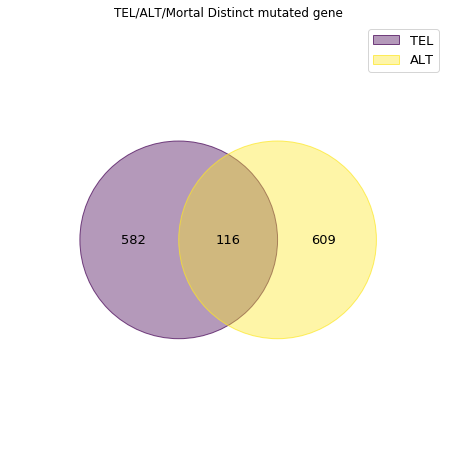

In [124]:
venn(mutated_genes)
plt.title("TEL/ALT/Mortal Distinct mutated gene")

In [167]:
exc_ALT_mutations = sm_mg_exc_ALT[['Gene', 'Name']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).reset_index(name='count_ALT')

In [168]:
exc_ALT_mutations

Gene  count_ALT
0            ATRX          9
1    LOC105371855          7
2       LINC02746          7
3            TUG1          7
4       LINC02280          7
..            ...        ...
720         MRTFB          1
721         MROH8          1
722         MPRIP          1
723          MPP4          1
724           A2M          1

[725 rows x 2 columns]

In [165]:
exc_TEL_mutations = sm_mg_exc_TEL[['Gene', 'Name']].drop_duplicates().groupby(
    ['Gene']).size().sort_values(ascending=False).reset_index(name='count_TEL')

In [166]:
exc_TEL_mutations

Gene  count_TEL
0               DUXAP10          8
1             SERPINA12          6
2                ZNF827          6
3             LINC02746          6
4          LOC105371855          6
..                  ...        ...
693              NAP1L3          1
694      NAALADL2&WDR49          1
695      NAALADL2&SENP2          1
696  MZF1-AS1&ZFPM2-AS1          1
697               ABCD3          1

[698 rows x 2 columns]

In [176]:
sm_mg_exc_ALT[sm_mg_exc_ALT["Gene"].str.contains("TP53TG3D")]

Empty DataFrame
Columns: [Key, Name, Source, dbSNP, Type, Chr1, Pos1, Chr2, Pos2, Qual1, Qual2, AF1, AF2, Read1, Read2, Gene, Consequence, Impact, Ref1, Alt1, Ref2, Alt2, exon_count, GeneDetail.refGene, ExonicFunc.refGene, AAChange.refGene, cytoBand, ExAC_ALL, ExAC_AFR, ExAC_AMR, ExAC_EAS, ExAC_FIN, ExAC_NFE, ExAC_OTH, ExAC_SAS, avsnp147, SIFT_score, SIFT_pred, Polyphen2_HDIV_score, Polyphen2_HDIV_pred, Polyphen2_HVAR_score, Polyphen2_HVAR_pred, LRT_score, LRT_pred, MutationTaster_score, MutationTaster_pred, MutationAssessor_score, MutationAssessor_pred, FATHMM_score, FATHMM_pred, PROVEAN_score, PROVEAN_pred, VEST3_score, CADD_raw, CADD_phred, DANN_score, fathmm-MKL_coding_score, fathmm-MKL_coding_pred, MetaSVM_score, MetaSVM_pred, MetaLR_score, MetaLR_pred, integrated_fitCons_score, integrated_confidence_value, GERP++_RS, phyloP7way_vertebrate, phyloP20way_mammalian, phastCons7way_vertebrate, phastCons20way_mammalian, SiPhy_29way_logOdds]
Index: []

In [177]:
sm_mg_exc_TEL[sm_mg_exc_TEL["Gene"].str.contains("TP53TG3D")]

Empty DataFrame
Columns: [Key, Name, Source, dbSNP, Type, Chr1, Pos1, Chr2, Pos2, Qual1, Qual2, AF1, AF2, Read1, Read2, Gene, Consequence, Impact, Ref1, Alt1, Ref2, Alt2, exon_count, GeneDetail.refGene, ExonicFunc.refGene, AAChange.refGene, cytoBand, ExAC_ALL, ExAC_AFR, ExAC_AMR, ExAC_EAS, ExAC_FIN, ExAC_NFE, ExAC_OTH, ExAC_SAS, avsnp147, SIFT_score, SIFT_pred, Polyphen2_HDIV_score, Polyphen2_HDIV_pred, Polyphen2_HVAR_score, Polyphen2_HVAR_pred, LRT_score, LRT_pred, MutationTaster_score, MutationTaster_pred, MutationAssessor_score, MutationAssessor_pred, FATHMM_score, FATHMM_pred, PROVEAN_score, PROVEAN_pred, VEST3_score, CADD_raw, CADD_phred, DANN_score, fathmm-MKL_coding_score, fathmm-MKL_coding_pred, MetaSVM_score, MetaSVM_pred, MetaLR_score, MetaLR_pred, integrated_fitCons_score, integrated_confidence_value, GERP++_RS, phyloP7way_vertebrate, phyloP20way_mammalian, phastCons7way_vertebrate, phastCons20way_mammalian, SiPhy_29way_logOdds]
Index: []

In [170]:
sm_mg_exc_AT = pd.merge(
    exc_ALT_mutations,
        exc_TEL_mutations, how='outer').fillna(0)

## Fisher test (including ncRNA)

In [352]:
sm_mg_exc_AT['p_value'] = sm_mg_exc_AT.apply(lambda row: fisher_exact(
    np.array([[row['count_ALT'], row['count_TEL']],
              [9 - row['count_ALT'], 8 - row['count_TEL']]]))[1], axis=1)
sm_mg_exc_AT['p_value_less'] = sm_mg_exc_AT.apply(lambda row: fisher_exact(
    np.array([[row['count_ALT'], row['count_TEL']],
              [9 - row['count_ALT'], 8 - row['count_TEL']]]), alternative='less')[1], axis=1)
sm_mg_exc_AT['p_value_greater'] = sm_mg_exc_AT.apply(lambda row: fisher_exact(
    np.array([[row['count_ALT'], row['count_TEL']],
              [9 - row['count_ALT'], 8 - row['count_TEL']]]), alternative='greater')[1], axis=1)

In [359]:
sm_mg_exc_AT=sm_mg_exc_AT.sort_values(by="p_value") # 1,304 genes 
sm_mg_exc_AT

Gene  count_ALT  count_TEL   p_value  \
0                             ATRX        9.0        0.0  0.000041   
12                    LOC101929322        4.0        0.0  0.082353   
13                          PRKXP1        4.0        0.0  0.082353   
725                       GOLGA6L3        0.0        3.0  0.082353   
726                          CSMD3        0.0        3.0  0.082353   
727                          AUTS2        0.0        3.0  0.082353   
728                      LOC729683        0.0        3.0  0.082353   
729                          MYO9B        0.0        3.0  0.082353   
387                      LINC00504        1.0        4.0  0.131222   
739                    GSDMA&PSMD3        0.0        2.0  0.205882   
740                      LOC642846        0.0        2.0  0.205882   
731                           HSF1        0.0        2.0  0.205882   
732                           TMC7        0.0        2.0  0.205882   
733                       NAALADL2        0.0        2.0  0.205882   
737                       CDRT15P1        0.0        2.0  0.205882   
735                    GSDMA&MED24        0.0        2.0  0.205882   
730               C9orf41-AS1&RORB        0.0        2.0  0.205882   
747                  NBPF19;NBPF20        0.0        2.0  0.205882   
738                          MOCS1        0.0        2.0  0.205882   
734                         SPDYE4        0.0        2.0  0.205882   
741                        TMEM267        0.0        2.0  0.205882   
736                         CELA3A        0.0        2.0  0.205882   
754                       KCNQ1OT1        0.0        2.0  0.205882   
743                          CASC8        0.0        2.0  0.205882   
744                   CARNMT1&RORB        0.0        2.0  0.205882   
745                        MIR1234        0.0        2.0  0.205882   
746                         ERVW-1        0.0        2.0  0.205882   
748                            ZAN        0.0        2.0  0.205882   
749                   LOC100132077        0.0        2.0  0.205882   
742                      LOC729603        0.0        2.0  0.205882   
751                         TXNDC2        0.0        2.0  0.205882   
752                         ZNF347        0.0        2.0  0.205882   
753                         TSG101        0.0        2.0  0.205882   
750                   LOC100133091        0.0        2.0  0.205882   
7                          DUXAP10        6.0        8.0  0.205882   
20                          NBPF12        3.0        0.0  0.205882   
717                          MUC16        1.0        3.0  0.294118   
166                          KLF18        1.0        3.0  0.294118   
663                         NBPF20        1.0        3.0  0.294118   
542                            TTN        1.0        3.0  0.294118   
55                       LOC389834        2.0        4.0  0.334842   
11                          ZNF827        4.0        6.0  0.334842   
25                       LINC01535        3.0        5.0  0.346935   
47                       LOC642366        2.0        0.0  0.470588   
40                        THCAT155        2.0        0.0  0.470588   
50                       LOC441666        2.0        0.0  0.470588   
46                           CNBD1        2.0        0.0  0.470588   
31                 MIR570HG;SDHAP2        2.0        0.0  0.470588   
34                           IDH3A        2.0        0.0  0.470588   
53                           CNTN5        2.0        0.0  0.470588   
45                      CMIP&WFDC1        2.0        0.0  0.470588   
29                         CACNA1E        2.0        0.0  0.470588   
42                      ENTPD1-AS1        2.0        0.0  0.470588   
37                          TCAM1P        2.0        0.0  0.470588   
35                           C2CD3        2.0        0.0  0.470588   
57                          SAMD12        2.0        0.0  0.470588   
59                           HDAC9      

In [327]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("LOC101929322"))&(~mg_exc_df['Key'].str.contains("Immortal"))
          &(~mg_exc_df['Key'].str.contains("Mortal"))]

Key              Name  \
17550  MuTect2_ncRNA_exonic_LOC101929322_JFCF-6_T_1_P...  JFCF_6_T_1_P_ALT   
18502  MuTect2_ncRNA_exonic_LOC101929322_JFCF6_T_1J_1...  JFCF_6_T_1J_1_3C   
19633  MuTect2_ncRNA_exonic_LOC101929322_JFCF_61M_chr...      JFCF_6_T_1_M   
19969  MuTect2_ncRNA_exonic_LOC101929322_JFCF_61Q_chr...      JFCF_6_T_1_Q   

        Source dbSNP          Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  \
17550  MuTect2   NaN  ncRNA_exonic  chr7  64962667  NaN  NaN   NaN   NaN  NaN   
18502  MuTect2   NaN  ncRNA_exonic  chr7  64960980  NaN  NaN   NaN   NaN  NaN   
19633  MuTect2   NaN  ncRNA_exonic  chr7  64962671  NaN  NaN   NaN   NaN  NaN   
19969  MuTect2   NaN  ncRNA_exonic  chr7  64960240  NaN  NaN   NaN   NaN  NaN   

       AF2 Read1 Read2          Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  \
17550  NaN   NaN   NaN  LOC101929322         NaN    NaN    A    T  NaN  NaN   
18502  NaN   NaN   NaN  LOC101929322         NaN    NaN    A    T  NaN  NaN   
19633  NaN   NaN   NaN  LOC101929322         NaN    NaN    C    T  NaN  NaN   
19969  NaN   NaN   NaN  LOC101929322         NaN    NaN    G    A  NaN  NaN   

       exon_count GeneDetail.refGene ExonicFunc.refGene AAChange.refGene  \
17550         NaN                  .                  .                .   
18502         NaN                  .                  .                .   
19633         NaN                  .                  .                .   
19969         NaN                  .                  .                .   

      cytoBand ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH  \
17550  7q11.21        .        .        .        .        .        .        .   
18502  7q11.21        .        .        .        .        .        .        .   
19633  7q11.21        .        .        .        .        .        .        .   
19969  7q11.21        .        .        .        .        .        .        .   

      ExAC_SAS avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score  \
17550        .        .          .         .                    .   
18502        .        .          .         .                    .   
19633        .        .          .         .                    .   
19969        .        .          .         .                    .   

      Polyphen2_HDIV_pred Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score  \
17550                   .                    .                   .         .   
18502                   .                    .                   .         .   
19633                   .                    .                   .         .   
19969                   .                    .                   .         .   

      LRT_pred MutationTaster_score MutationTaster_pred  \
17550        .                    .                   .   
18502        .                    .                   .   
19633        .                    .                   .   
19969        .                    .                   .   

      MutationAssessor_score MutationAssessor_pred FATHMM_score FATHMM_pred  \
17550                      .                     .            .           .   
18502                      .                     .            .           .   
19633                      .                     .            .           .   
19969                      .                     .            .           .   

      PROVEAN_score PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
17550             .            .           .        .          .          .   
18502             .            .           .        .          .          .   
19633             .            .           .        .          .          .   
19969             .            .           .        .          .          .   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
17550                       .                      .             .   
18502                       .                      .             .   
19633                       

In [245]:
sm_mg_exc_AT[sm_mg_exc_AT["Gene"].isin(tel_genes_list["Gene symbol"])].sort_values(by=["count_ALT"],ascending=False)
# 84 telomere-related genes 

Gene  count_ALT  count_TEL   p_value  p_value_less  p_value_greater
0         ATRX        9.0        0.0  0.000041      1.000000         0.000041
11      ZNF827        4.0        6.0  0.334842      0.217812         0.963595
18     SLC25A5        3.0        3.0  1.000000      0.626697         0.753394
32       CABP2        2.0        2.0  1.000000      0.664706         0.758824
34       IDH3A        2.0        0.0  0.470588      1.000000         0.264706
59       HDAC9        2.0        0.0  0.470588      1.000000         0.264706
96         DMD        2.0        1.0  1.000000      0.876471         0.547059
450       PCNT        1.0        0.0  1.000000      1.000000         0.529412
477     ZC3H18        1.0        0.0  1.000000      1.000000         0.529412
472       SND1        1.0        1.0  1.000000      0.735294         0.794118
462      PRMT5        1.0        0.0  1.000000      1.000000         0.529412
440       PIGN        1.0        0.0  1.000000      1.000000         0.529412
448      PDS5B        1.0        0.0  1.000000      1.000000         0.529412
441     PHLPP1        1.0        0.0  1.000000      1.000000         0.529412
489       UTRN        1.0        0.0  1.000000      1.000000         0.529412
422      SIRT1        1.0        0.0  1.000000      1.000000         0.529412
480      YWHAE        1.0        0.0  1.000000      1.000000         0.529412
517      TCOF1        1.0        0.0  1.000000      1.000000         0.529412
491      USP18        1.0        0.0  1.000000      1.000000         0.529412
407     RB1CC1        1.0        1.0  1.000000      0.735294         0.794118
522     TAGLN2        1.0        0.0  1.000000      1.000000         0.529412
527      SYNE2        1.0        1.0  1.000000      0.735294         0.794118
528      SYNE1        1.0        0.0  1.000000      1.000000         0.529412
533       SOX5        1.0        1.0  1.000000      0.735294         0.794118
536      TENM3        1.0        0.0  1.000000      1.000000         0.529412
643     NUDCD2        1.0        0.0  1.000000      1.000000         0.529412
667       PASK        1.0        0.0  1.000000      1.000000         0.529412
412      SCYL1        1.0        0.0  1.000000      1.000000         0.529412
516      SOAT1        1.0        0.0  1.000000      1.000000         0.529412
395    RPS6KA5        1.0        0.0  1.000000      1.000000         0.529412
252       CBX3        1.0        0.0  1.000000      1.000000         0.529412
394      RRAS2        1.0        0.0  1.000000      1.000000         0.529412
98      FANCD2        1.0        0.0  1.000000      1.000000         0.529412
180      KMT5C        1.0        0.0  1.000000      1.000000         0.529412
184      IPO13        1.0        0.0  1.000000      1.000000         0.529412
191       HELZ        1.0        0.0  1.000000      1.000000         0.529412
201   HIST1H4K        1.0        0.0  1.000000      1.000000         0.529412
215     HSPA4L        1.0        0.0  1.000000      1.000000         0.529412
219   HIST1H3H        1.0        0.0  1.000000      1.000000         0.529412
241   C17orf49        1.0        0.0  1.000000      1.000000         0.529412
182      KMT2C        1.0        0.0  1.000000      1.000000         0.529412
282      AHNAK        1.0        0.0  1.000000      1.000000         0.529412
335       E2F3        1.0        0.0  1.000000      1.000000         0.529412
372       CTC1        1.0        0.0  1.000000      1.000000         0.529412
287      ATAD5        1.0        0.0  1.000000      1.000000         0.529412
364      CDK13        1.0        0.0  1.000000      1.000000         0.529412
350       CFTR        1.0        0.0  1.000000      1.000000         0.529412
321    DCLRE1A        1.0        0.0  1.000000      1.000000         0.529412
316      DHX35        1.0        0.0  1.000000      1.000000         0.529412
302     ANKLE1        1.0        0.0  1.000000      1.000000         0.529412
293   ARHGAP12        1.0       

In [200]:
sm_mg_exc_AT[sm_mg_exc_AT["Gene"].isin(top_tel_genes_list["Gene symbol"])].sort_values(by=["count_ALT"],ascending=False)
# 14 top telomere-related genes (Telnet score > 2)

Gene  count_ALT  count_TEL   p_value  p_value_less  p_value_greater
0         ATRX        9.0        0.0  0.000041      1.000000         0.000041
11      ZNF827        4.0        6.0  0.334842      0.217812         0.963595
98      FANCD2        1.0        0.0  1.000000      1.000000         0.529412
180      KMT5C        1.0        0.0  1.000000      1.000000         0.529412
201   HIST1H4K        1.0        0.0  1.000000      1.000000         0.529412
219   HIST1H3H        1.0        0.0  1.000000      1.000000         0.529412
252       CBX3        1.0        0.0  1.000000      1.000000         0.529412
372       CTC1        1.0        0.0  1.000000      1.000000         0.529412
412      SCYL1        1.0        0.0  1.000000      1.000000         0.529412
422      SIRT1        1.0        0.0  1.000000      1.000000         0.529412
850      GNL3L        0.0        1.0  0.470588      0.470588         1.000000
972       EID3        0.0        1.0  0.470588      0.470588         1.000000
1163      TEP1        0.0        1.0  0.470588      0.470588         1.000000
1168     MCPH1        0.0        1.0  0.470588      0.470588         1.000000

In [228]:
sm_mg_exc_AT[sm_mg_exc_AT["Gene"].isin(cp_genes_list["Gene symbol"])].sort_values(by=["count_ALT","Gene"],ascending=False)
# 33 chromatin-related genes

Gene  count_ALT  count_TEL   p_value  p_value_less  p_value_greater
0         ATRX        9.0        0.0  0.000041      1.000000         0.000041
61    HIST1H1T        2.0        1.0  1.000000      0.876471         0.547059
59       HDAC9        2.0        0.0  0.470588      1.000000         0.264706
48        CHD6        2.0        0.0  0.470588      1.000000         0.264706
548     TRIM24        1.0        0.0  1.000000      1.000000         0.529412
472       SND1        1.0        1.0  1.000000      0.735294         0.794118
422      SIRT1        1.0        0.0  1.000000      1.000000         0.529412
403      RNF17        1.0        0.0  1.000000      1.000000         0.529412
462      PRMT5        1.0        0.0  1.000000      1.000000         0.529412
180      KMT5C        1.0        0.0  1.000000      1.000000         0.529412
182      KMT2C        1.0        0.0  1.000000      1.000000         0.529412
153      KDM5A        1.0        0.0  1.000000      1.000000         0.529412
159      KAT6A        1.0        0.0  1.000000      1.000000         0.529412
201   HIST1H4K        1.0        0.0  1.000000      1.000000         0.529412
219   HIST1H3H        1.0        0.0  1.000000      1.000000         0.529412
106      ERCC6        1.0        0.0  1.000000      1.000000         0.529412
108      EP400        1.0        0.0  1.000000      1.000000         0.529412
344       DPF3        1.0        0.0  1.000000      1.000000         0.529412
250       CBX4        1.0        0.0  1.000000      1.000000         0.529412
252       CBX3        1.0        0.0  1.000000      1.000000         0.529412
224      BTAF1        1.0        0.0  1.000000      1.000000         0.529412
225      BRWD1        1.0        0.0  1.000000      1.000000         0.529412
288      ASXL3        1.0        0.0  1.000000      1.000000         0.529412
1148     TDRD6        0.0        1.0  0.470588      0.470588         1.000000
1134   TBL1XR1        0.0        1.0  0.470588      0.470588         1.000000
1044   SMARCA5        0.0        1.0  0.470588      0.470588         1.000000
1068     PRDM7        0.0        1.0  0.470588      0.470588         1.000000
1263     PHF12        0.0        1.0  0.470588      0.470588         1.000000
1295     NCOA3        0.0        1.0  0.470588      0.470588         1.000000
834    L3MBTL4        0.0        1.0  0.470588      0.470588         1.000000
808      KMT2A        0.0        1.0  0.470588      0.470588         1.000000
813   KIAA2026        0.0        1.0  0.470588      0.470588         1.000000
856       ING3        0.0        1.0  0.470588      0.470588         1.000000
770       EYA2        0.0        1.0  0.470588      0.470588         1.000000
920     ACTL6A        0.0        1.0  0.470588      0.470588         1.000000

In [238]:
sm_mg_exc_ALT_pv = sm_mg_exc_ALT.groupby(['Name', 'Gene']).size()
sm_mg_exc_ALT_pv = sm_mg_exc_ALT_pv.reset_index(name='count')
sm_mg_exc_ALT_pv = sm_mg_exc_ALT_pv.pivot(columns='Name', index='Gene', values='count').fillna(0)

In [239]:
sm_mg_exc_TEL_pv = sm_mg_exc_TEL.groupby(['Name', 'Gene']).size()
sm_mg_exc_TEL_pv = sm_mg_exc_TEL_pv.reset_index(name='count')
sm_mg_exc_TEL_pv = sm_mg_exc_TEL_pv.pivot(columns='Name', index='Gene', values='count').fillna(0)

In [241]:
sm_mg_exc_pv = pd.merge(sm_mg_exc_ALT_pv,sm_mg_exc_TEL_pv,how="outer", on='Gene').fillna(0)

In [242]:
sm_mg_exc_pv

Name                          JFCF_6_T_1J_11E  JFCF_6_T_1J_1_3C  JFCF_6_T_1_D  \
Gene                                                                            
A2M                                       0.0               0.0           0.0   
A2M-AS1                                   0.0               0.0           0.0   
AACSP1                                    0.0               0.0           0.0   
AARD                                      0.0               0.0           0.0   
ABI1                                      0.0               0.0           1.0   
ACAA2                                     0.0               0.0           1.0   
ACACA&PARD6G                              1.0               1.0           0.0   
ACACA&PARD6G-AS1                          1.0               1.0           0.0   
ACOXL-AS1                                 0.0               0.0           0.0   
ACTN3                                     0.0               0.0           0.0   
ACTR1A                                    1.0               0.0           0.0   
ACTR3BP5                                  0.0               1.0           0.0   
ACTRT2                                    0.0               0.0           0.0   
ACVR1C                                    0.0               0.0           0.0   
ADAM20P1                                  0.0               0.0           0.0   
ADAM3B                                    0.0               0.0           0.0   
ADAMTSL3&PARD6G                           1.0               1.0           0.0   
ADGRL1                                    0.0               0.0           2.0   
AFF1                                      0.0               0.0           2.0   
AFG3L1P                                   0.0               1.0           0.0   
AGL                                       0.0               0.0           1.0   
AHCTF1P1                                  0.0               0.0           1.0   
AHNAK                                     0.0               0.0           0.0   
AHNAK2                                    0.0               0.0           0.0   
AHSA2P                                    0.0               0.0           0.0   
AKAP3                                     0.0               1.0           0.0   
ANKLE1                                    0.0               1.0           0.0   
ANKRD17                                   0.0               0.0           1.0   
ANKRD20A9P                                0.0               0.0           0.0   
ANKRD26&CLCN4                             0.0               0.0           1.0   
ANKRD28                                   0.0               0.0           0.0   
ANKRD30A                                  1.0               0.0           0.0   
ANKRD30BP2                                0.0               0.0           0.0   
ANKRD36                                   0.0               0.0           0.0   
ANTXRL                                    1.0               0.0           0.0   
APOA5                                     0.0               0.0           0.0   
APOB                                      1.0               1.0           1.0   
ARHGAP12                                  0.0               0.0           0.0   
ARHGAP32                                  0.0               0.0           0.0   
ARHGAP36                                  0.0               1.0           0.0   
ARHGEF3                                   0.0               0.0           0.0   
ARMC4                                     0.0               0.0           1.0   
ASXL3                                     0.0               0.0           0.0   
ATAD5                                     0.0               0.0           0.0   
ATL1&ATP6V1D                              0.0               0.0           0.0   
ATL2                                      0.0               0.0           1.0   
ATP10B                                    0.0               0.0           1.0   
ATP6V1D                        

In [247]:
sm_mg_exc_pv.to_csv("../results/SM_MG_EXC_GeneCount.csv", index=1)

### Mutiple testing ( FDR)

In [328]:
def fdr(p_vals):

    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr
# method 1

In [336]:
import statsmodels.stats.multitest as multi
# method 2

In [363]:
sm_mg_exc_AT['FDR'] = multi.multipletests(sm_mg_exc_AT['p_value'], alpha=0.05, method='fdr_bh', is_sorted=1, returnsorted=0)[1]

In [367]:
sm_mg_exc_AT.head(10)

Gene  count_ALT  count_TEL   p_value  p_value_less  \
0            ATRX        9.0        0.0  0.000041      1.000000   
12   LOC101929322        4.0        0.0  0.082353      1.000000   
13         PRKXP1        4.0        0.0  0.082353      1.000000   
725      GOLGA6L3        0.0        3.0  0.082353      0.082353   
726         CSMD3        0.0        3.0  0.082353      0.082353   
727         AUTS2        0.0        3.0  0.082353      0.082353   
728     LOC729683        0.0        3.0  0.082353      0.082353   
729         MYO9B        0.0        3.0  0.082353      0.082353   
387     LINC00504        1.0        4.0  0.131222      0.110860   
739   GSDMA&PSMD3        0.0        2.0  0.205882      0.205882   

     p_value_greater       FDR  
0           0.000041  0.053764  
12          0.052941  0.965555  
13          0.052941  0.965555  
725         1.000000  0.965555  
726         1.000000  0.965555  
727         1.000000  0.965555  
728         1.000000  0.965555  
729         1.000000  0.965555  
387         0.990950  0.965555  
739         1.000000  0.965555

## Top telomere-related genes- mannual check

### SVs

In [254]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("ATRX"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key              Name  \
7789   SV_GRIDSS_HIGH_ATRX&KRBA1_Somatic_chr7_1494188...       JFCF_6_T_5K   
7791   SV_GRIDSS_HIGH_ATRX&SSPO_Somatic_chr7_14947961...       JFCF_6_T_5K   
7793   SV_GRIDSS_HIGH_ATRX&SSPO_Somatic_chr7_14947963...       JFCF_6_T_5K   
7795   SV_GRIDSS_HIGH_ATRX&SSPO_Somatic_chr7_14947995...       JFCF_6_T_5K   
13648  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76885052_7688...      JFCF_6_T_1_M   
13915  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76808603_7680...      JFCF_6_T_1_Q   
14418  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76862268_7686...      JFCF_6_T_1_D   
14987  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76853017_7685...   JFCF_6_T_1J_11E   
14988  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76853017_7685...  JFCF_6_T_1J_1_3C   
15106  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76795540_7679...      JFCF_6_T_1_L   
15316  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76788737_7678...      JFCF_6_T_1_R   
15432  SV_GRIDSS_HIGH_ATRX_Somatic_chrX_76783771_7678...       JFCF_6_T_5K   
17675  MuTect2_exonic_ATRX_JFCF-6_T_1_PALT_chrX_76938...  JFCF_6_T_1_P_ALT   

        Source  dbSNP            Type  Chr1                 Pos1  Chr2  \
7789    GRIDSS  False  Translocations  chr7  149418856-149418857  chrX   
7791    GRIDSS  False  Translocations  chr7  149479619-149479624  chrX   
7793    GRIDSS  False  Translocations  chr7  149479631-149479633  chrX   
7795    GRIDSS  False  Translocations  chr7  149479955-149479956  chrX   
13648   GRIDSS  False     Duplication  chrX    76885052-76885055  chrX   
13915   GRIDSS  False        Deletion  chrX    76808603-76808606  chrX   
14418   GRIDSS  False        Deletion  chrX    76862268-76862269  chrX   
14987   GRIDSS  False        Deletion  chrX    76853017-76853018  chrX   
14988   GRIDSS  False        Deletion  chrX    76853017-76853018  chrX   
15106   GRIDSS  False        Deletion  chrX    76795540-76795542  chrX   
15316   GRIDSS  False        Deletion  chrX    76788737-76788738  chrX   
15432   GRIDSS  False     Duplication  chrX    76783771-76783774  chrX   
17675  MuTect2    NaN          exonic  chrX             76938581   NaN   

                    Pos2                         Qual1  \
7789   76917250-76917251        NotSplit:0;Split:92.74   
7791   76783762-76783767    NotSplit:91.63;Split:132.7   
7793   76917220-76917222        NotSplit:0;Split:88.27   
7795   76782881-76782882  NotSplit:109.96;Split:133.03   
13648  76923999-76924002  NotSplit:204.12;Split:318.66   
13915  76875533-76875536   NotSplit:141.33;Split:96.28   
14418  77034579-77034580       NotSplit:249.27;Split:0   
14987  77014863-77014864  NotSplit:239.33;Split:302.85   
14988  77014863-77014864  NotSplit:343.72;Split:285.82   
15106  76940486-76940488  NotSplit:237.43;Split:194.13   
15316  76876903-76876904       NotSplit:186.78;Split:0   
15432  76840055-76840058  NotSplit:256.58;Split:114.96   
17675                NaN                           NaN   

                              Qual2  AF1  AF2                 Read1  \
7789         NotSplit:0;Split:92.74  NaN  NaN    NotSplit:0;Split:3   
7791     NotSplit:91.63;Split:132.7  NaN  NaN    NotSplit:5;Split:5   
7793         NotSplit:0;Split:88.27  NaN  NaN    NotSplit:0;Split:3   
7795   NotSplit:109.96;Split:133.03  NaN  NaN    NotSplit:6;Split:5   
13648  NotSplit:204.12;Split:318.66  NaN  NaN  NotSplit:11;Split:12   
13915   NotSplit:141.33;Split:96.28  NaN  NaN    NotSplit:8;Split:4   
14418       NotSplit:249.27;Split:0  NaN  NaN   NotSplit:14;Split:0   
14987  NotSplit:239.33;Split:302.85  NaN  NaN  NotSplit:13;Split:12   
14988  NotSplit:343.72;Split:285.82  NaN  NaN  NotSplit:19;Split:11   
15106  NotSplit:237.43;Split:194.13  NaN  NaN   NotSplit:13;Split:7   
15316       NotSplit:186.78;Split:0  NaN  NaN   NotSplit:10;Split:0   
15432  NotSplit:256.58;Split:114.96  NaN  NaN   NotSplit:14;Split:4   
17675                           NaN  NaN  NaN                   NaN   

                      Read2        Gene                     Consequence  \
7789     NotSplit:0;Split:3  ATRX&KRBA1 

In [253]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("BMP2K"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key         Name  Source  \
15338  SV_GRIDSS_HIGH_BMP2K&LINC01088_Somatic_chr4_79...  JFCF_6_T_5K  GRIDSS   

       dbSNP      Type  Chr1               Pos1  Chr2               Pos2  \
15338  False  Deletion  chr4  79717419-79717425  chr4  80063629-80063635   

                              Qual1                         Qual2  AF1  AF2  \
15338  NotSplit:293.23;Split:274.25  NotSplit:293.23;Split:274.25  NaN  NaN   

                      Read1                 Read2             Gene  \
15338  NotSplit:16;Split:10  NotSplit:16;Split:10  BMP2K&LINC01088   

       Consequence Impact Ref1              Alt1 Ref2              Alt2  \
15338  gene_fusion   HIGH    C  C[CHR4:80063632[    A  ]CHR4:79717422]A   

       exon_count GeneDetail.refGene ExonicFunc.refGene AAChange.refGene  \
15338        42.0                NaN                NaN              NaN   

      cytoBand ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH  \
15338      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      ExAC_SAS avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score  \
15338      NaN      NaN        NaN       NaN                  NaN   

      Polyphen2_HDIV_pred Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score  \
15338                 NaN                  NaN                 NaN       NaN   

      LRT_pred MutationTaster_score MutationTaster_pred  \
15338      NaN                  NaN                 NaN   

      MutationAssessor_score MutationAssessor_pred FATHMM_score FATHMM_pred  \
15338                    NaN                   NaN          NaN         NaN   

      PROVEAN_score PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
15338           NaN          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
15338                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
15338          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
15338                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
15338                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
15338                 NaN

In [255]:
 mg_exc_df[(mg_exc_df["Gene"].str.contains("CBX3"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key         Name  Source  \
15378  SV_GRIDSS_HIGH_CBX3_Somatic_chr7_19212371_1921...  JFCF_6_T_5K  GRIDSS   
15380  SV_GRIDSS_HIGH_CBX3_Somatic_chr7_19212816_1921...  JFCF_6_T_5K  GRIDSS   
15382  SV_GRIDSS_HIGH_CBX3_Somatic_chr7_23535852_2353...  JFCF_6_T_5K  GRIDSS   
15384  SV_GRIDSS_HIGH_CBX3_Somatic_chr7_23540292_2354...  JFCF_6_T_5K  GRIDSS   
15386  SV_GRIDSS_HIGH_CBX3&OSBPL3_Somatic_chr7_249908...  JFCF_6_T_5K  GRIDSS   

       dbSNP         Type  Chr1               Pos1  Chr2               Pos2  \
15378  False    Inversion  chr7  19212371-19212377  chr7  26251762-26251768   
15380  False  Duplication  chr7  19212816-19212817  chr7  26251423-26251424   
15382  False     Deletion  chr7  23535852-23535856  chr7  26252272-26252276   
15384  False  Duplication  chr7  23540292-23540293  chr7  26251902-26251903   
15386  False     Deletion  chr7  24990826-24990829  chr7  26251359-26251362   

                              Qual1                         Qual2  AF1  AF2  \
15378   NotSplit:128.29;Split:124.2   NotSplit:128.29;Split:124.2  NaN  NaN   
15380        NotSplit:0;Split:282.2        NotSplit:0;Split:282.2  NaN  NaN   
15382  NotSplit:128.29;Split:193.41  NotSplit:128.29;Split:193.41  NaN  NaN   
15384  NotSplit:366.54;Split:224.59  NotSplit:366.54;Split:224.59  NaN  NaN   
15386   NotSplit:91.63;Split:248.52   NotSplit:91.63;Split:248.52  NaN  NaN   

                     Read1                Read2         Gene  \
15378   NotSplit:7;Split:5   NotSplit:7;Split:5         CBX3   
15380  NotSplit:0;Split:10  NotSplit:0;Split:10         CBX3   
15382   NotSplit:7;Split:7   NotSplit:7;Split:7         CBX3   
15384  NotSplit:20;Split:8  NotSplit:20;Split:8         CBX3   
15386   NotSplit:5;Split:9   NotSplit:5;Split:9  CBX3&OSBPL3   

                     Consequence Impact Ref1                Alt1 Ref2  \
15378        transcript_ablation   HIGH    A    [CHR7:26251766[A    G   
15380        transcript_ablation   HIGH    T  ]CHR7:26251424]GGT    T   
15382        transcript_ablation   HIGH    G    G[CHR7:26252274[    C   
15384        transcript_ablation   HIGH    A  ]CHR7:26251903]AAA    T   
15386  bidirectional_gene_fusion   HIGH    A    A[CHR7:26251361[    T   

                     Alt2  exon_count GeneDetail.refGene ExonicFunc.refGene  \
15378    [CHR7:19212374[G       816.0                NaN                NaN   
15380  TGG[CHR7:19212817[       814.0                NaN                NaN   
15382    ]CHR7:23535854]C       365.0                NaN                NaN   
15384  TAA[CHR7:23540293[       365.0                NaN                NaN   
15386    ]CHR7:24990828]T        65.0                NaN                NaN   

      AAChange.refGene cytoBand ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN  \
15378              NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15380              NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15382              NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15384              NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15386              NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      ExAC_NFE ExAC_OTH ExAC_SAS avsnp147 SIFT_score SIFT_pred  \
15378      NaN      NaN      NaN      NaN        NaN       NaN   
15380      NaN      NaN      NaN      NaN        NaN       NaN   
15382      NaN      NaN      NaN      NaN        NaN       NaN   
15384      NaN      NaN      NaN      NaN        NaN       NaN   
15386      NaN      NaN      NaN      NaN        NaN       NaN   

      Polyphen2_HDIV_score Polyphen2_HDIV_pred Polyphen2_HVAR_score  \
15378                  NaN                 NaN                  NaN   
15380                  NaN                 NaN                  NaN   
15382                  NaN                 NaN                  NaN   
15384                  NaN                 NaN                  NaN   
15386                  NaN                 NaN                  NaN   

      Polyph

In [258]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("SCYL1"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key             Name  \
14376  SV_GRIDSS_HIGH_FRMD8&SCYL1_Somatic_chr11_65154...     JFCF_6_T_1_D   
15853  MuTect2_exonic_SCYL1_JFCF-6_T_1J_11E_chr11_652...  JFCF_6_T_1J_11E   

        Source  dbSNP         Type   Chr1               Pos1   Chr2  \
14376   GRIDSS  False  Duplication  chr11  65154129-65154132  chr11   
15853  MuTect2    NaN       exonic  chr11           65293064    NaN   

                    Pos2                        Qual1  \
14376  65299376-65299379  NotSplit:106.83;Split:74.12   
15853                NaN                          NaN   

                             Qual2  AF1  AF2               Read1  \
14376  NotSplit:106.83;Split:74.12  NaN  NaN  NotSplit:6;Split:3   
15853                          NaN  NaN  NaN                 NaN   

                    Read2         Gene                     Consequence Impact  \
14376  NotSplit:6;Split:3  FRMD8&SCYL1  gene_fusion&frameshift_variant   HIGH   
15853                 NaN        SCYL1                             NaN    NaN   

      Ref1               Alt1 Ref2               Alt2  exon_count  \
14376    C  ]CHR11:65299378]C    C  C[CHR11:65154131[        44.0   
15853    C                  G  NaN                NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
14376                NaN                NaN   
15853                  .  nonsynonymous SNV   

                                        AAChange.refGene cytoBand ExAC_ALL  \
14376                                                NaN      NaN      NaN   
15853  SCYL1:NM_001048218:exon2:c.C131G:p.S44C,SCYL1:...  11q13.1        .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
14376      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15853        .        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14376        NaN       NaN                  NaN                 NaN   
15853      0.001         D                  1.0                   D   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14376                  NaN                 NaN       NaN      NaN   
15853                0.998                   D     0.000        D   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14376                  NaN                 NaN                    NaN   
15853                    1                   D                   2.99   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14376                   NaN          NaN         NaN           NaN   
15853                     M        -0.78           T         -3.67   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14376          NaN         NaN      NaN        NaN        NaN   
15853            D       0.738    5.684       26.8      0.992   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14376                     NaN                    NaN           NaN   
15853                   0.988                      D         0.436   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14376          NaN          NaN         NaN                      NaN   
15853            D        0.625           D                    0.442   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14376                         NaN       NaN                   NaN   
15853                           0      4.48                 0.871   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14376                   NaN                      NaN                      NaN   
15853                 0.843                    0.976                    0.993   

      SiPhy_29way_logOdds  
14376                 NaN  
15853              14.638

In [260]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("PML"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key              Name  \
15134  SV_GRIDSS_HIGH_PML&SCAPER_Somatic_chr15_742917...  JFCF_6_T_1_P_ALT   

       Source  dbSNP       Type   Chr1               Pos1   Chr2  \
15134  GRIDSS  False  Inversion  chr15  74291707-74291710  chr15   

                    Pos2                         Qual1  \
15134  76655514-76655517  NotSplit:345.63;Split:277.97   

                              Qual2  AF1  AF2                 Read1  \
15134  NotSplit:345.63;Split:277.97  NaN  NaN  NotSplit:19;Split:11   

                      Read2        Gene                     Consequence  \
15134  NotSplit:19;Split:11  PML&SCAPER  gene_fusion&frameshift_variant   

      Impact Ref1               Alt1 Ref2               Alt2  exon_count  \
15134   HIGH    T  T]CHR15:76655516]    A  A]CHR15:74291709]      1137.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
15134                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
15134      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
15134      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
15134                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
15134                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
15134                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
15134          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
15134                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
15134          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
15134                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
15134                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
15134                 NaN

In [261]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("MCPH1"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key          Name  \
14773  SV_GRIDSS_HIGH_DEFA9P&MCPH1_Somatic_chr8_64359...  JFCF_6_T_1_H   
14775  SV_GRIDSS_HIGH_MCPH1_Somatic_chr8_6437257_6437...  JFCF_6_T_1_H   

       Source  dbSNP       Type  Chr1             Pos1  Chr2             Pos2  \
14773  GRIDSS  False  Inversion  chr8  6435957-6435958  chr8  6817219-6817220   
14775  GRIDSS  False  Inversion  chr8  6437257-6437258  chr8  6819130-6819131   

                              Qual1                         Qual2  AF1  AF2  \
14773   NotSplit:127.43;Split:85.56   NotSplit:127.43;Split:85.56  NaN  NaN   
14775  NotSplit:145.63;Split:166.73  NotSplit:145.63;Split:166.73  NaN  NaN   

                    Read1               Read2          Gene  \
14773  NotSplit:7;Split:3  NotSplit:7;Split:3  DEFA9P&MCPH1   
14775  NotSplit:8;Split:6  NotSplit:8;Split:6         MCPH1   

                          Consequence Impact Ref1  \
14773  gene_fusion&frameshift_variant   HIGH    C   
14775             transcript_ablation   HIGH    T   

                                 Alt1 Ref2                            Alt2  \
14773    CACCCACTACTTTC]CHR8:6817220]    A    AGAAAGTAGTGGGT]CHR8:6435958]   
14775  [CHR8:6819131[TCAAATGACTTCGGGT    G  [CHR8:6437258[CCCGAAGTCATTTGAG   

       exon_count GeneDetail.refGene ExonicFunc.refGene AAChange.refGene  \
14773        36.0                NaN                NaN              NaN   
14775        36.0                NaN                NaN              NaN   

      cytoBand ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH  \
14773      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14775      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      ExAC_SAS avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score  \
14773      NaN      NaN        NaN       NaN                  NaN   
14775      NaN      NaN        NaN       NaN                  NaN   

      Polyphen2_HDIV_pred Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score  \
14773                 NaN                  NaN                 NaN       NaN   
14775                 NaN                  NaN                 NaN       NaN   

      LRT_pred MutationTaster_score MutationTaster_pred  \
14773      NaN                  NaN                 NaN   
14775      NaN                  NaN                 NaN   

      MutationAssessor_score MutationAssessor_pred FATHMM_score FATHMM_pred  \
14773                    NaN                   NaN          NaN         NaN   
14775                    NaN                   NaN          NaN         NaN   

      PROVEAN_score PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14773           NaN          NaN         NaN      NaN        NaN        NaN   
14775           NaN          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14773                     NaN                    NaN           NaN   
14775                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14773          NaN          NaN         NaN                      NaN   
14775          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14773                         NaN       NaN                   NaN   
14775                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14773                   NaN                      NaN                      NaN   
14775                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
14773                 NaN  
14775                 NaN

In [262]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("POLH"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key          Name  \
14751  SV_GRIDSS_HIGH_POLH&POLR1C_Somatic_chr6_434889...  JFCF_6_T_1_H   

       Source  dbSNP         Type  Chr1               Pos1  Chr2  \
14751  GRIDSS  False  Duplication  chr6  43488916-43488920  chr6   

                    Pos2                         Qual1  \
14751  43574280-43574284  NotSplit:327.67;Split:319.03   

                              Qual2  AF1  AF2                 Read1  \
14751  NotSplit:327.67;Split:319.03  NaN  NaN  NotSplit:18;Split:12   

                      Read2         Gene                     Consequence  \
14751  NotSplit:18;Split:12  POLH&POLR1C  gene_fusion&frameshift_variant   

      Impact Ref1              Alt1 Ref2              Alt2  exon_count  \
14751   HIGH    A  ]CHR6:43574282]A    C  C[CHR6:43488918[        57.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14751                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14751      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14751      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14751                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14751                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14751                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14751          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14751                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14751          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14751                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14751                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
14751                 NaN

### SNVs

In [264]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("CTC1"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key              Name  \
17873  MuTect2_exonic_CTC1_JFCF-6_T_1_R_chr17_8137831...      JFCF_6_T_1_R   
18722  MuTect2_upstream;downstream_LINC00324;CTC1_JFC...  JFCF_6_T_1J_1_3C   

        Source dbSNP                 Type   Chr1     Pos1 Chr2 Pos2 Qual1  \
17873  MuTect2   NaN               exonic  chr17  8137831  NaN  NaN   NaN   
18722  MuTect2   NaN  upstream;downstream  chr17  8127676  NaN  NaN   NaN   

      Qual2  AF1  AF2 Read1 Read2            Gene Consequence Impact Ref1  \
17873   NaN  NaN  NaN   NaN   NaN            CTC1         NaN    NaN    T   
18722   NaN  NaN  NaN   NaN   NaN  LINC00324;CTC1         NaN    NaN    A   

      Alt1 Ref2 Alt2  exon_count GeneDetail.refGene ExonicFunc.refGene  \
17873    G  NaN  NaN         NaN                  .  nonsynonymous SNV   
18722    -  NaN  NaN         NaN  dist=315;dist=457                  .   

                             AAChange.refGene cytoBand ExAC_ALL ExAC_AFR  \
17873  CTC1:NM_025099:exon10:c.A1760C:p.N587T  17p13.1        .        .   
18722                                       .  17p13.1        .        .   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
17873        .        .        .        .        .        .        .   
18722        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
17873      0.177         T                0.996                   D   
18722          .         .                    .                   .   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
17873                0.876                   P     0.000        D   
18722                    .                   .         .        .   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
17873                0.877                   D                   1.64   
18722                    .                   .                      .   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
17873                     L        -2.04           D         -3.63   
18722                     .            .           .             .   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
17873            D        0.44    3.646       23.2      0.967   
18722            .           .        .          .          .   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
17873                   0.819                      D         0.121   
18722                       .                      .             .   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
17873            D        0.596           D                    0.707   
18722            .            .           .                        .   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
17873                           0      4.33                 0.987   
18722                           .         .                     .   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
17873                 1.037                    0.038                    0.984   
18722                     .                        .                        .   

      SiPhy_29way_logOdds  
17873               8.558  
18722                   .

In [265]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("FANCD2"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key          Name  \
19887  MuTect2_exonic_FANCD2_JFCF_61Q_chr3_10114944_A_C  JFCF_6_T_1_Q   

        Source dbSNP    Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
19887  MuTect2   NaN  exonic  chr3  10114944  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2    Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
19887   NaN   NaN  FANCD2         NaN    NaN    A    C  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
19887                  .  nonsynonymous SNV   

                                        AAChange.refGene cytoBand ExAC_ALL  \
19887  FANCD2:NM_001018115:exon28:c.A2613C:p.K871N,FA...   3p25.3   0.0021   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
19887   0.0043   0.0003   0.0010        0   0.0027   0.0045   0.0004   

         avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score  \
19887  rs56041034      0.135         T                0.146   

      Polyphen2_HDIV_pred Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score  \
19887                   B                0.128                   B     0.000   

      LRT_pred MutationTaster_score MutationTaster_pred  \
19887        N                0.949                   D   

      MutationAssessor_score MutationAssessor_pred FATHMM_score FATHMM_pred  \
19887                   2.47                     M         0.25           T   

      PROVEAN_score PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
19887         -2.97            D        0.37    0.166      4.315      0.839   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
19887                   0.503                      D        -0.969   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
19887            T        0.172           T                    0.707   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
19887                           0     -2.35                 1.062   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
19887                 0.134                    0.578                    0.733   

      SiPhy_29way_logOdds  
19887               5.402

In [266]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("SCYL1"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key             Name  \
14376  SV_GRIDSS_HIGH_FRMD8&SCYL1_Somatic_chr11_65154...     JFCF_6_T_1_D   
15853  MuTect2_exonic_SCYL1_JFCF-6_T_1J_11E_chr11_652...  JFCF_6_T_1J_11E   

        Source  dbSNP         Type   Chr1               Pos1   Chr2  \
14376   GRIDSS  False  Duplication  chr11  65154129-65154132  chr11   
15853  MuTect2    NaN       exonic  chr11           65293064    NaN   

                    Pos2                        Qual1  \
14376  65299376-65299379  NotSplit:106.83;Split:74.12   
15853                NaN                          NaN   

                             Qual2  AF1  AF2               Read1  \
14376  NotSplit:106.83;Split:74.12  NaN  NaN  NotSplit:6;Split:3   
15853                          NaN  NaN  NaN                 NaN   

                    Read2         Gene                     Consequence Impact  \
14376  NotSplit:6;Split:3  FRMD8&SCYL1  gene_fusion&frameshift_variant   HIGH   
15853                 NaN        SCYL1                             NaN    NaN   

      Ref1               Alt1 Ref2               Alt2  exon_count  \
14376    C  ]CHR11:65299378]C    C  C[CHR11:65154131[        44.0   
15853    C                  G  NaN                NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
14376                NaN                NaN   
15853                  .  nonsynonymous SNV   

                                        AAChange.refGene cytoBand ExAC_ALL  \
14376                                                NaN      NaN      NaN   
15853  SCYL1:NM_001048218:exon2:c.C131G:p.S44C,SCYL1:...  11q13.1        .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
14376      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15853        .        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14376        NaN       NaN                  NaN                 NaN   
15853      0.001         D                  1.0                   D   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14376                  NaN                 NaN       NaN      NaN   
15853                0.998                   D     0.000        D   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14376                  NaN                 NaN                    NaN   
15853                    1                   D                   2.99   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14376                   NaN          NaN         NaN           NaN   
15853                     M        -0.78           T         -3.67   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14376          NaN         NaN      NaN        NaN        NaN   
15853            D       0.738    5.684       26.8      0.992   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14376                     NaN                    NaN           NaN   
15853                   0.988                      D         0.436   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14376          NaN          NaN         NaN                      NaN   
15853            D        0.625           D                    0.442   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14376                         NaN       NaN                   NaN   
15853                           0      4.48                 0.871   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14376                   NaN                      NaN                      NaN   
15853                 0.843                    0.976                    0.993   

      SiPhy_29way_logOdds  
14376                 NaN  
15853              14.638

In [267]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("HIST1H3H"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key          Name  \
14358  SV_GRIDSS_HIGH_HIST1H3H_Somatic_chr6_27777914_...  JFCF_6_T_1_D   

       Source  dbSNP      Type  Chr1               Pos1  Chr2  \
14358  GRIDSS  False  Deletion  chr6  27777914-27777915  chr6   

                    Pos2                        Qual1  \
14358  27907674-27907675  NotSplit:195.86;Split:90.19   

                             Qual2  AF1  AF2                Read1  \
14358  NotSplit:195.86;Split:90.19  NaN  NaN  NotSplit:11;Split:3   

                     Read2      Gene          Consequence Impact Ref1  \
14358  NotSplit:11;Split:3  HIST1H3H  transcript_ablation   HIGH    G   

                                             Alt1 Ref2  \
14358  GTGTCTTTATGAATCCACCAAGGCCAG[CHR6:27907675[    C   

                                             Alt2  exon_count  \
14358  ]CHR6:27777915]TGTCTTTATGAATCCACCAAGGCCAGC        15.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14358                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14358      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14358      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14358                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14358                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14358                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14358          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14358                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14358          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14358                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14358                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
14358                 NaN

In [268]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("HIST1H4K"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key         Name  \
18141  MuTect2_exonic_HIST1H4K_JFCF-6_T_5K_chr6_27799...  JFCF_6_T_5K   

        Source dbSNP    Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
18141  MuTect2   NaN  exonic  chr6  27799058  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2      Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  \
18141   NaN   NaN  HIST1H4K         NaN    NaN    G    C  NaN  NaN   

       exon_count GeneDetail.refGene ExonicFunc.refGene  \
18141         NaN                  .  nonsynonymous SNV   

                              AAChange.refGene cytoBand ExAC_ALL ExAC_AFR  \
18141  HIST1H4K:NM_003541:exon1:c.C248G:p.T83S   6p22.1        .        .   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
18141        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
18141          .         .                    .                   .   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
18141                    .                   .     0.000        U   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
18141                0.647                   D                      .   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
18141                     .            .           .             .   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
18141            .       0.495    2.892       21.8      0.991   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
18141                   0.882                      D        -0.171   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
18141            T        0.372           T                    0.733   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
18141                           0      4.25                 0.032   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
18141                 0.946                    0.966                    0.984   

      SiPhy_29way_logOdds  
18141              16.026

In [269]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("KMT5C"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key          Name  \
17253  MuTect2_exonic_KMT5C_JFCF-6_T_1_L_chr19_558587...  JFCF_6_T_1_L   

        Source dbSNP    Type   Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
17253  MuTect2   NaN  exonic  chr19  55858734  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2   Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
17253   NaN   NaN  KMT5C         NaN    NaN    G    T  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
17253                  .  nonsynonymous SNV   

                             AAChange.refGene  cytoBand ExAC_ALL ExAC_AFR  \
17253  KMT5C:NM_032701:exon9:c.G1306T:p.A436S  19q13.42        .        .   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
17253        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
17253      0.006         D                0.049                   B   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
17253                 0.03                   B     0.353        N   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
17253                    1                   N                  0.695   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
17253                     N         0.62           T          0.23   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
17253            N       0.103    0.807      9.507      0.964   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
17253                   0.089                      N        -1.025   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
17253            T        0.071           T                    0.554   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
17253                           0     0.284                 0.917   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
17253                 0.061                    0.873                    0.192   

      SiPhy_29way_logOdds  
17253               4.139

In [270]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("PML"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key              Name  \
15134  SV_GRIDSS_HIGH_PML&SCAPER_Somatic_chr15_742917...  JFCF_6_T_1_P_ALT   

       Source  dbSNP       Type   Chr1               Pos1   Chr2  \
15134  GRIDSS  False  Inversion  chr15  74291707-74291710  chr15   

                    Pos2                         Qual1  \
15134  76655514-76655517  NotSplit:345.63;Split:277.97   

                              Qual2  AF1  AF2                 Read1  \
15134  NotSplit:345.63;Split:277.97  NaN  NaN  NotSplit:19;Split:11   

                      Read2        Gene                     Consequence  \
15134  NotSplit:19;Split:11  PML&SCAPER  gene_fusion&frameshift_variant   

      Impact Ref1               Alt1 Ref2               Alt2  exon_count  \
15134   HIGH    T  T]CHR15:76655516]    A  A]CHR15:74291709]      1137.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
15134                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
15134      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
15134      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
15134                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
15134                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
15134                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
15134          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
15134                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
15134          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
15134                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
15134                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
15134                 NaN

In [271]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("SIRT1"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key             Name  \
15838  MuTect2_exonic_SIRT1_JFCF-6_T_1J_11E_chr10_696...  JFCF_6_T_1J_11E   

        Source dbSNP    Type   Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
15838  MuTect2   NaN  exonic  chr10  69672515  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2   Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
15838   NaN   NaN  SIRT1         NaN    NaN    G    C  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
15838                  .  nonsynonymous SNV   

                                        AAChange.refGene cytoBand ExAC_ALL  \
15838  SIRT1:NM_001314049:exon6:c.G733C:p.D245H,SIRT1...  10q21.3        .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
15838        .        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
15838      0.085         T                0.002                   B   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
15838                0.005                   B     0.008        N   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
15838                0.999                   D                  0.695   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
15838                     N         2.45           T         -1.39   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
15838            N       0.375    2.085      16.76      0.975   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
15838                   0.770                      D        -1.099   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
15838            T        0.041           T                    0.672   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
15838                           0      4.11                 0.917   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
15838                 1.048                    0.998                    0.970   

      SiPhy_29way_logOdds  
15838               8.877

In [272]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("EID3"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key            Name  \
19273  MuTect2_exonic_EID3_JFCF6_T_1J_6B_chr12_104697...  JFCF_6_T_1J_6B   

        Source dbSNP    Type   Chr1       Pos1 Chr2 Pos2 Qual1 Qual2  AF1  \
19273  MuTect2   NaN  exonic  chr12  104697906  NaN  NaN   NaN   NaN  NaN   

       AF2 Read1 Read2  Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  \
19273  NaN   NaN   NaN  EID3         NaN    NaN    C    G  NaN  NaN   

       exon_count GeneDetail.refGene ExonicFunc.refGene  \
19273         NaN                  .  nonsynonymous SNV   

                             AAChange.refGene cytoBand ExAC_ALL ExAC_AFR  \
19273  EID3:NM_001008394:exon1:c.C194G:p.S65C  12q23.3        .        .   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
19273        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
19273       0.05         D                0.987                   D   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
19273                0.855                   P         .        .   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
19273                    1                   N                   1.61   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
19273                     L         0.87           T         -2.57   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
19273            D       0.191    3.528       23.1      0.978   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
19273                   0.188                      N        -1.004   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
19273            T        0.150           T                    0.405   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
19273                           1      2.74                -0.058   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
19273                 0.852                    0.003                    0.036   

      SiPhy_29way_logOdds  
19273               5.180

In [273]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("GNL3L"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key          Name  \
16806  MuTect2_exonic_GNL3L_JFCF-6_T_1_G_chrX_5457469...  JFCF_6_T_1_G   

        Source dbSNP    Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
16806  MuTect2   NaN  exonic  chrX  54574692  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2   Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
16806   NaN   NaN  GNL3L         NaN    NaN    T    C  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
16806                  .  nonsynonymous SNV   

                                        AAChange.refGene cytoBand ExAC_ALL  \
16806  GNL3L:NM_001184819:exon9:c.T661C:p.S221P,GNL3L...  Xp11.22        .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
16806        .        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
16806      0.073         T                0.003                   B   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
16806                0.003                   B     0.000        N   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
16806                0.996                   D                   1.59   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
16806                     L          2.1           T         -3.32   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
16806            D       0.066    1.256      12.04      0.984   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
16806                   0.839                      D        -1.108   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
16806            T        0.046           T                        .   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
16806                           .      3.95                 0.991   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
16806                 1.061                    0.931                    0.973   

      SiPhy_29way_logOdds  
16806               9.301

In [274]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("MCPH1"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key          Name  \
14773  SV_GRIDSS_HIGH_DEFA9P&MCPH1_Somatic_chr8_64359...  JFCF_6_T_1_H   
14775  SV_GRIDSS_HIGH_MCPH1_Somatic_chr8_6437257_6437...  JFCF_6_T_1_H   

       Source  dbSNP       Type  Chr1             Pos1  Chr2             Pos2  \
14773  GRIDSS  False  Inversion  chr8  6435957-6435958  chr8  6817219-6817220   
14775  GRIDSS  False  Inversion  chr8  6437257-6437258  chr8  6819130-6819131   

                              Qual1                         Qual2  AF1  AF2  \
14773   NotSplit:127.43;Split:85.56   NotSplit:127.43;Split:85.56  NaN  NaN   
14775  NotSplit:145.63;Split:166.73  NotSplit:145.63;Split:166.73  NaN  NaN   

                    Read1               Read2          Gene  \
14773  NotSplit:7;Split:3  NotSplit:7;Split:3  DEFA9P&MCPH1   
14775  NotSplit:8;Split:6  NotSplit:8;Split:6         MCPH1   

                          Consequence Impact Ref1  \
14773  gene_fusion&frameshift_variant   HIGH    C   
14775             transcript_ablation   HIGH    T   

                                 Alt1 Ref2                            Alt2  \
14773    CACCCACTACTTTC]CHR8:6817220]    A    AGAAAGTAGTGGGT]CHR8:6435958]   
14775  [CHR8:6819131[TCAAATGACTTCGGGT    G  [CHR8:6437258[CCCGAAGTCATTTGAG   

       exon_count GeneDetail.refGene ExonicFunc.refGene AAChange.refGene  \
14773        36.0                NaN                NaN              NaN   
14775        36.0                NaN                NaN              NaN   

      cytoBand ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH  \
14773      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14775      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      ExAC_SAS avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score  \
14773      NaN      NaN        NaN       NaN                  NaN   
14775      NaN      NaN        NaN       NaN                  NaN   

      Polyphen2_HDIV_pred Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score  \
14773                 NaN                  NaN                 NaN       NaN   
14775                 NaN                  NaN                 NaN       NaN   

      LRT_pred MutationTaster_score MutationTaster_pred  \
14773      NaN                  NaN                 NaN   
14775      NaN                  NaN                 NaN   

      MutationAssessor_score MutationAssessor_pred FATHMM_score FATHMM_pred  \
14773                    NaN                   NaN          NaN         NaN   
14775                    NaN                   NaN          NaN         NaN   

      PROVEAN_score PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14773           NaN          NaN         NaN      NaN        NaN        NaN   
14775           NaN          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14773                     NaN                    NaN           NaN   
14775                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14773          NaN          NaN         NaN                      NaN   
14775          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14773                         NaN       NaN                   NaN   
14775                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14773                   NaN                      NaN                      NaN   
14775                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
14773                 NaN  
14775                 NaN

In [275]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("POLH"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key          Name  \
14751  SV_GRIDSS_HIGH_POLH&POLR1C_Somatic_chr6_434889...  JFCF_6_T_1_H   

       Source  dbSNP         Type  Chr1               Pos1  Chr2  \
14751  GRIDSS  False  Duplication  chr6  43488916-43488920  chr6   

                    Pos2                         Qual1  \
14751  43574280-43574284  NotSplit:327.67;Split:319.03   

                              Qual2  AF1  AF2                 Read1  \
14751  NotSplit:327.67;Split:319.03  NaN  NaN  NotSplit:18;Split:12   

                      Read2         Gene                     Consequence  \
14751  NotSplit:18;Split:12  POLH&POLR1C  gene_fusion&frameshift_variant   

      Impact Ref1              Alt1 Ref2              Alt2  exon_count  \
14751   HIGH    A  ]CHR6:43574282]A    C  C[CHR6:43488918[        57.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14751                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14751      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14751      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14751                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14751                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14751                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14751          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14751                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14751          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14751                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14751                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
14751                 NaN

In [276]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("TEP1"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key             Name  \
15619  MuTect2_exonic_TEP1_JFCF-6_T_1J_11C_chr14_2085...  JFCF_6_T_1J_11C   

        Source dbSNP    Type   Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
15619  MuTect2   NaN  exonic  chr14  20854315  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2  Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
15619   NaN   NaN  TEP1         NaN    NaN    C    A  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
15619                  .  nonsynonymous SNV   

                                        AAChange.refGene cytoBand ExAC_ALL  \
15619  TEP1:NM_001319035:exon18:c.G2577T:p.Q859H,TEP1...  14q11.2        .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
15619        .        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
15619      0.019         D                0.852                   P   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
15619                 0.76                   P     0.000        D   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
15619                0.851                   D                  1.505   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
15619                     L          0.9           T         -2.49   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
15619            N       0.269    3.975       23.6      0.998   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
15619                   0.960                      D        -0.888   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
15619            T        0.150           T                    0.707   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
15619                           0      3.18                 0.033   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
15619                 0.852                    0.996                    0.995   

      SiPhy_29way_logOdds  
15619              10.319

In [373]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("SNORA1B"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key            Name  \
19159  MuTect2_ncRNA_exonic_SNORA1B_JFCF6_T_1J_6B_chr...  JFCF_6_T_1J_6B   

        Source dbSNP          Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  \
19159  MuTect2   NaN  ncRNA_exonic  chr8  56815414  NaN  NaN   NaN   NaN  NaN   

       AF2 Read1 Read2     Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  \
19159  NaN   NaN   NaN  SNORA1B         NaN    NaN   TT    -  NaN  NaN   

       exon_count GeneDetail.refGene ExonicFunc.refGene AAChange.refGene  \
19159         NaN                  .                  .                .   

      cytoBand ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH  \
19159   8q12.1        .        .        .        .        .        .        .   

      ExAC_SAS avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score  \
19159        .        .          .         .                    .   

      Polyphen2_HDIV_pred Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score  \
19159                   .                    .                   .         .   

      LRT_pred MutationTaster_score MutationTaster_pred  \
19159        .                    .                   .   

      MutationAssessor_score MutationAssessor_pred FATHMM_score FATHMM_pred  \
19159                      .                     .            .           .   

      PROVEAN_score PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
19159             .            .           .        .          .          .   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
19159                       .                      .             .   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
19159            .            .           .                        .   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
19159                           .         .                     .   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
19159                     .                        .                        .   

      SiPhy_29way_logOdds  
19159                   .

## Fisher test top genes mannual check

In [694]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("NBPF12"))&(~mg_exc_df['Key'].str.contains("Immortal"))]
# question: why mutations in R cell line had not been called

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
17061  MuTect2_exonic_NBPF12_JFCF-6_T_1_L_chr1_146395...      JFCF_6_T_1_L   
18343  MuTect2_exonic_NBPF12_JFCF6_T_1J_1-3C_chr1_146...  JFCF_6_T_1J_1_3C   
18344  MuTect2_exonic_NBPF12_JFCF6_T_1J_1-3C_chr1_146...  JFCF_6_T_1J_1_3C   
19848  MuTect2_exonic_NBPF12_JFCF_61Q_chr1_146395447_A_G      JFCF_6_T_1_Q   

        Source dbSNP    Type  Chr1       Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
17061  MuTect2   NaN  exonic  chr1  146395447  NaN  NaN   NaN   NaN  NaN  NaN   
18343  MuTect2   NaN  exonic  chr1  146395447  NaN  NaN   NaN   NaN  NaN  NaN   
18344  MuTect2   NaN  exonic  chr1  146395465  NaN  NaN   NaN   NaN  NaN  NaN   
19848  MuTect2   NaN  exonic  chr1  146395447  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2    Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
17061   NaN   NaN  NBPF12         NaN    NaN    A    G  NaN  NaN         NaN   
18343   NaN   NaN  NBPF12         NaN    NaN    A    G  NaN  NaN         NaN   
18344   NaN   NaN  NBPF12         NaN    NaN    T    A  NaN  NaN         NaN   
19848   NaN   NaN  NBPF12         NaN    NaN    A    G  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
17061                  .  nonsynonymous SNV   
18343                  .  nonsynonymous SNV   
18344                  .  nonsynonymous SNV   
19848                  .  nonsynonymous SNV   

                               AAChange.refGene cytoBand ExAC_ALL ExAC_AFR  \
17061  NBPF12:NM_001278141:exon7:c.A106G:p.R36G   1q21.1        .        .   
18343  NBPF12:NM_001278141:exon7:c.A106G:p.R36G   1q21.1        .        .   
18344  NBPF12:NM_001278141:exon7:c.T124A:p.C42S   1q21.1   0.0005        0   
19848  NBPF12:NM_001278141:exon7:c.A106G:p.R36G   1q21.1        .        .   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS     avsnp147  \
17061        .        .        .        .        .        .  rs587734201   
18343        .        .        .        .        .        .  rs587734201   
18344        0        0        0        0   0.0417        0  rs868945414   
19848        .        .        .        .        .        .  rs587734201   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
17061      0.159         T                    .                   .   
18343      0.159         T                    .                   .   
18344          .         .                    .                   .   
19848      0.159         T                    .                   .   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
17061                    .                   .         .        .   
18343                    .                   .         .        .   
18344                    .                   .         .        .   
19848                    .                   .         .        .   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
17061                    1                   N                      .   
18343                    1                   N                      .   
18344                    1                   D                  0.895   
19848                    1                   N                      .   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
17061                     .          3.2           T         -5.25   
18343                     .          3.2           T         -5.25   
18344                     L            .           .             .   
19848                     .          3.2           T         -5.25   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
17061            D       0.373    1.088      11.15      0.890   
18343            D       0.373    1.088      11.15      0.890   
18344            .       0.336    2.863       21.7      0.743   
19848            D       0.373    1.088      11.15      0.890   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
17061                   0.001   

In [700]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("ADAMTSL3"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
4176  SV_GRIDSS_HIGH_ADAMTSL3&PARD6G_Somatic_chr15_8...   JFCF_6_T_1J_11E   
4654  SV_GRIDSS_HIGH_ADAMTSL3&PARD6G_Somatic_chr15_8...  JFCF_6_T_1J_1_3C   

      Source  dbSNP            Type   Chr1               Pos1   Chr2  \
4176  GRIDSS  False  Translocations  chr15  84654887-84654889  chr18   
4654  GRIDSS  False  Translocations  chr15  84654887-84654889  chr18   

                   Pos2                         Qual1  \
4176  77946538-77946540  NotSplit:202.51;Split:288.91   
4654  77946538-77946540  NotSplit:434.17;Split:369.45   

                             Qual2  AF1  AF2                 Read1  \
4176  NotSplit:202.51;Split:288.91  NaN  NaN  NotSplit:11;Split:11   
4654  NotSplit:434.17;Split:369.45  NaN  NaN  NotSplit:24;Split:14   

                     Read2             Gene                Consequence Impact  \
4176  NotSplit:11;Split:11  ADAMTSL3&PARD6G  bidirectional_gene_fusion   HIGH   
4654  NotSplit:24;Split:14  ADAMTSL3&PARD6G  bidirectional_gene_fusion   HIGH   

     Ref1               Alt1 Ref2               Alt2  exon_count  \
4176    A  ]CHR18:77946539]A    A  A[CHR15:84654888[         NaN   
4654    A  ]CHR18:77946539]A    A  A[CHR15:84654888[         NaN   

     GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand ExAC_ALL  \
4176                NaN                NaN              NaN      NaN      NaN   
4654                NaN                NaN              NaN      NaN      NaN   

     ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
4176      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4654      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

     SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
4176        NaN       NaN                  NaN                 NaN   
4654        NaN       NaN                  NaN                 NaN   

     Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
4176                  NaN                 NaN       NaN      NaN   
4654                  NaN                 NaN       NaN      NaN   

     MutationTaster_score MutationTaster_pred MutationAssessor_score  \
4176                  NaN                 NaN                    NaN   
4654                  NaN                 NaN                    NaN   

     MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
4176                   NaN          NaN         NaN           NaN   
4654                   NaN          NaN         NaN           NaN   

     PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
4176          NaN         NaN      NaN        NaN        NaN   
4654          NaN         NaN      NaN        NaN        NaN   

     fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
4176                     NaN                    NaN           NaN   
4654                     NaN                    NaN           NaN   

     MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
4176          NaN          NaN         NaN                      NaN   
4654          NaN          NaN         NaN                      NaN   

     integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
4176                         NaN       NaN                   NaN   
4654                         NaN       NaN                   NaN   

     phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
4176                   NaN                      NaN                      NaN   
4654                   NaN                      NaN                      NaN   

     SiPhy_29way_logOdds  
4176                 NaN  
4654                 NaN

In [702]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("C2CD3"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key             Name  \
14952  SV_GRIDSS_HIGH_C2CD3_Somatic_chr11_73705189_73...  JFCF_6_T_1J_11E   
17821  MuTect2_exonic_C2CD3_JFCF-6_T_1_R_chr11_737893...     JFCF_6_T_1_R   

        Source  dbSNP         Type   Chr1               Pos1   Chr2  \
14952   GRIDSS  False  Duplication  chr11  73705189-73705192  chr11   
17821  MuTect2    NaN       exonic  chr11           73789345    NaN   

                    Pos2                         Qual1  \
14952  73740554-73740557  NotSplit:331.37;Split:122.69   
17821                NaN                           NaN   

                              Qual2  AF1  AF2                Read1  \
14952  NotSplit:331.37;Split:122.69  NaN  NaN  NotSplit:18;Split:5   
17821                           NaN  NaN  NaN                  NaN   

                     Read2   Gene          Consequence Impact Ref1  \
14952  NotSplit:18;Split:5  C2CD3  transcript_ablation   HIGH    G   
17821                  NaN  C2CD3                  NaN    NaN    G   

                    Alt1 Ref2               Alt2  exon_count  \
14952  ]CHR11:73740556]G    A  A[CHR11:73705191[        13.0   
17821                  T  NaN                NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
14952                NaN                NaN   
17821                  .  nonsynonymous SNV   

                                        AAChange.refGene cytoBand ExAC_ALL  \
14952                                                NaN      NaN      NaN   
17821  C2CD3:NM_001286577:exon23:c.C4418A:p.A1473E,C2...  11q13.4        .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
14952      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
17821        .        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14952        NaN       NaN                  NaN                 NaN   
17821      0.274         T                0.992                   D   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14952                  NaN                 NaN       NaN      NaN   
17821                0.811                   P     0.002        N   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14952                  NaN                 NaN                    NaN   
17821                0.552                   D                   1.39   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14952                   NaN          NaN         NaN           NaN   
17821                     L        -2.27           D          -1.2   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14952          NaN         NaN      NaN        NaN        NaN   
17821            N       0.719    5.542       26.4      0.989   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14952                     NaN                    NaN           NaN   
17821                   0.934                      D         0.193   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14952          NaN          NaN         NaN                      NaN   
17821            D        0.572           D                    0.706   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14952                         NaN       NaN                   NaN   
17821                           0      4.33                 0.069   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14952                   NaN                      NaN                      NaN   
17821                 0.935                    0.948                    0.998   

      SiPhy_29way_logOdds  
14952                 NaN  
17821               3.153

In [703]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("CACNA1E"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key             Name  \
15728  MuTect2_exonic_CACNA1E_JFCF-6_T_1J_11E_chr1_18...  JFCF_6_T_1J_11E   
17068  MuTect2_exonic_CACNA1E_JFCF-6_T_1_L_chr1_18170...     JFCF_6_T_1_L   

        Source dbSNP    Type  Chr1       Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
15728  MuTect2   NaN  exonic  chr1  181702809  NaN  NaN   NaN   NaN  NaN  NaN   
17068  MuTect2   NaN  exonic  chr1  181702809  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2     Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
15728   NaN   NaN  CACNA1E         NaN    NaN    A    C  NaN  NaN         NaN   
17068   NaN   NaN  CACNA1E         NaN    NaN    A    C  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
15728                  .  nonsynonymous SNV   
17068                  .  nonsynonymous SNV   

                                        AAChange.refGene cytoBand ExAC_ALL  \
15728  CACNA1E:NM_001205294:exon20:c.A3128C:p.K1043T,...   1q25.3        .   
17068  CACNA1E:NM_001205294:exon20:c.A3128C:p.K1043T,...   1q25.3        .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
15728        .        .        .        .        .        .        .        .   
17068        .        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
15728      0.114         T                 0.13                   B   
17068      0.114         T                 0.13                   B   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
15728                0.058                   B     0.020        N   
17068                0.058                   B     0.020        N   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
15728                0.971                   D                      0   
17068                0.971                   D                      0   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
15728                     N        -4.01           D         -1.47   
17068                     N        -4.01           D         -1.47   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
15728            N       0.265    1.789      14.92      0.996   
17068            N       0.265    1.789      14.92      0.996   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
15728                   0.814                      D        -0.220   
17068                   0.814                      D        -0.220   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
15728            T        0.738           D                    0.672   
17068            T        0.738           D                    0.672   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
15728                           0      3.83                 1.039   
17068                           0      3.83                 1.039   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
15728                 1.199                    0.995                    0.856   
17068                 1.199                    0.995                    0.856   

      SiPhy_29way_logOdds  
15728               8.057  
17068               8.057

In [704]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("CCNB3"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
17263  MuTect2_exonic_CCNB3_JFCF-6_T_1_L_chrX_5005159...      JFCF_6_T_1_L   
18878  MuTect2_exonic_CCNB3_JFCF6_T_1J_1-3C_chrX_5005...  JFCF_6_T_1J_1_3C   

        Source dbSNP    Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
17263  MuTect2   NaN  exonic  chrX  50051599  NaN  NaN   NaN   NaN  NaN  NaN   
18878  MuTect2   NaN  exonic  chrX  50054209  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2   Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
17263   NaN   NaN  CCNB3         NaN    NaN    A    C  NaN  NaN         NaN   
18878   NaN   NaN  CCNB3         NaN    NaN    A    G  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
17263                  .  nonsynonymous SNV   
18878                  .  nonsynonymous SNV   

                              AAChange.refGene cytoBand   ExAC_ALL ExAC_AFR  \
17263    CCNB3:NM_033031:exon6:c.A430C:p.K144Q  Xp11.22  2.352e-05        0   
18878  CCNB3:NM_033031:exon6:c.A3040G:p.T1014A  Xp11.22          .        .   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS     avsnp147  \
17263   0.0001        0        0        0        0   0.0001  rs782524458   
18878        .        .        .        .        .        .            .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
17263      0.195         T                0.286                   B   
18878        1.0         T                0.001                   B   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
17263                0.064                   B         .        .   
18878                  0.0                   B     0.000        N   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
17263                    1                   N                   1.24   
18878                    1                   N                  -0.55   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
17263                     L         2.81           T         -1.43   
18878                     N         2.55           T          0.18   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
17263            N       0.052   -1.466      0.003      0.932   
18878            N        0.03   -2.893      0.001      0.148   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
17263                   0.015                      N        -1.001   
18878                   0.001                      N        -1.014   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
17263            T        0.018           T                        .   
18878            T        0.011           T                        .   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
17263                           .     -5.29                -0.126   
18878                           .     -4.92                -0.860   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
17263                -0.184                    0.004                    0.001   
18878                -1.303                    0.001                    0.000   

      SiPhy_29way_logOdds  
17263               7.320  
18878               0.593

In [699]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("PARD6G"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
4176  SV_GRIDSS_HIGH_ADAMTSL3&PARD6G_Somatic_chr15_8...   JFCF_6_T_1J_11E   
4185  SV_GRIDSS_HIGH_ACACA&PARD6G_Somatic_chr17_3562...   JFCF_6_T_1J_11E   
4186  SV_GRIDSS_HIGH_ACACA&PARD6G-AS1_Somatic_chr17_...   JFCF_6_T_1J_11E   
4404  SV_GRIDSS_HIGH_PARD6G-AS1_Somatic_chr4_6693104...  JFCF_6_T_1J_1_3C   
4405  SV_GRIDSS_HIGH_PARD6G_Somatic_chr4_66931041_66...  JFCF_6_T_1J_1_3C   
4654  SV_GRIDSS_HIGH_ADAMTSL3&PARD6G_Somatic_chr15_8...  JFCF_6_T_1J_1_3C   
4661  SV_GRIDSS_HIGH_ACACA&PARD6G_Somatic_chr17_3562...  JFCF_6_T_1J_1_3C   
4662  SV_GRIDSS_HIGH_ACACA&PARD6G-AS1_Somatic_chr17_...  JFCF_6_T_1J_1_3C   

      Source  dbSNP            Type   Chr1               Pos1   Chr2  \
4176  GRIDSS  False  Translocations  chr15  84654887-84654889  chr18   
4185  GRIDSS  False  Translocations  chr17  35620133-35620137  chr18   
4186  GRIDSS  False  Translocations  chr17  35620133-35620137  chr18   
4404  GRIDSS  False  Translocations   chr4  66931041-66931043  chr18   
4405  GRIDSS  False  Translocations   chr4  66931041-66931043  chr18   
4654  GRIDSS  False  Translocations  chr15  84654887-84654889  chr18   
4661  GRIDSS  False  Translocations  chr17  35620133-35620137  chr18   
4662  GRIDSS  False  Translocations  chr17  35620133-35620137  chr18   

                   Pos2                         Qual1  \
4176  77946538-77946540  NotSplit:202.51;Split:288.91   
4185  77927928-77927932  NotSplit:257.73;Split:289.51   
4186  77927928-77927932  NotSplit:257.73;Split:289.51   
4404  77916260-77916262   NotSplit:90.45;Split:129.06   
4405  77916260-77916262   NotSplit:90.45;Split:129.06   
4654  77946538-77946540  NotSplit:434.17;Split:369.45   
4661  77927928-77927932  NotSplit:488.45;Split:618.95   
4662  77927928-77927932  NotSplit:488.45;Split:618.95   

                             Qual2  AF1  AF2                 Read1  \
4176  NotSplit:202.51;Split:288.91  NaN  NaN  NotSplit:11;Split:11   
4185  NotSplit:257.73;Split:289.51  NaN  NaN  NotSplit:14;Split:11   
4186  NotSplit:257.73;Split:289.51  NaN  NaN  NotSplit:14;Split:11   
4404   NotSplit:90.45;Split:129.06  NaN  NaN    NotSplit:5;Split:5   
4405   NotSplit:90.45;Split:129.06  NaN  NaN    NotSplit:5;Split:5   
4654  NotSplit:434.17;Split:369.45  NaN  NaN  NotSplit:24;Split:14   
4661  NotSplit:488.45;Split:618.95  NaN  NaN  NotSplit:27;Split:24   
4662  NotSplit:488.45;Split:618.95  NaN  NaN  NotSplit:27;Split:24   

                     Read2              Gene                     Consequence  \
4176  NotSplit:11;Split:11   ADAMTSL3&PARD6G       bidirectional_gene_fusion   
4185  NotSplit:14;Split:11      ACACA&PARD6G  gene_fusion&frameshift_variant   
4186  NotSplit:14;Split:11  ACACA&PARD6G-AS1       bidirectional_gene_fusion   
4404    NotSplit:5;Split:5        PARD6G-AS1             transcript_ablation   
4405    NotSplit:5;Split:5            PARD6G             transcript_ablation   
4654  NotSplit:24;Split:14   ADAMTSL3&PARD6G       bidirectional_gene_fusion   
4661  NotSplit:27;Split:24      ACACA&PARD6G  gene_fusion&frameshift_variant   
4662  NotSplit:27;Split:24  ACACA&PARD6G-AS1       bidirectional_gene_fusion   

     Impact Ref1               Alt1 Ref2               Alt2  exon_count  \
4176   HIGH    A  ]CHR18:77946539]A    A  A[CHR15:84654888[         NaN   
4185   HIGH    T  ]CHR18:77927930]T    C  C[CHR17:35620135[         NaN   
4186   HIGH    T  ]CHR18:77927930]T    C  C[CHR17:35620135[         NaN   
4404   HIGH    A  A[CHR18:77916261[    T   ]CHR4:66931042]T         NaN   
4405   HIGH    A  A[CHR18:77916261[    T   ]CHR4:66931042]T         NaN   
4654   HIGH    A  ]CHR18:77946539]A    A  A[CHR15:84654888[         NaN   
4661   HIGH    T  ]CHR18:77927930]T    C  C[CHR17:35620135[         NaN   
4662   HIGH    T  ]CHR18:77927930]T    C  C[CHR17:35620135[         NaN   

     GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand ExAC_ALL  \
4176                NaN                NaN              NaN      NaN      NaN   
4185 

In [705]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("CHD6"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
15037  SV_GRIDSS_HIGH_CHD6_Somatic_chr20_40087089_400...  JFCF_6_T_1J_1_3C   
18291  MuTect2_exonic_CHD6_JFCF-6_T_5K_chr20_40050492...       JFCF_6_T_5K   

        Source  dbSNP         Type   Chr1               Pos1   Chr2  \
15037   GRIDSS  False  Duplication  chr20  40087089-40087092  chr20   
18291  MuTect2    NaN       exonic  chr20           40050492    NaN   

                    Pos2                         Qual1  \
15037  40114110-40114113  NotSplit:126.63;Split:256.05   
18291                NaN                           NaN   

                              Qual2  AF1  AF2                Read1  \
15037  NotSplit:126.63;Split:256.05  NaN  NaN  NotSplit:7;Split:10   
18291                           NaN  NaN  NaN                  NaN   

                     Read2  Gene  Consequence Impact Ref1               Alt1  \
15037  NotSplit:7;Split:10  CHD6  gene_fusion   HIGH    G  ]CHR20:40114112]G   
18291                  NaN  CHD6          NaN    NaN    G                  T   

      Ref2               Alt2  exon_count GeneDetail.refGene  \
15037    T  T[CHR20:40087091[         3.0                NaN   
18291  NaN                NaN         NaN                  .   

      ExonicFunc.refGene                         AAChange.refGene cytoBand  \
15037                NaN                                      NaN      NaN   
18291  nonsynonymous SNV  CHD6:NM_032221:exon31:c.C4783A:p.R1595S    20q12   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
15037      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
18291        .        .        .        .        .        .        .        .   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
15037      NaN        NaN       NaN                  NaN                 NaN   
18291        .      0.016         D                0.687                   P   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
15037                  NaN                 NaN       NaN      NaN   
18291                0.635                   P     0.001        N   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
15037                  NaN                 NaN                    NaN   
18291                1.000                   D                   2.83   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
15037                   NaN          NaN         NaN           NaN   
18291                     M        -0.99           T         -5.34   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
15037          NaN         NaN      NaN        NaN        NaN   
18291            D       0.954    6.762         32      0.998   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
15037                     NaN                    NaN           NaN   
18291                   0.992                      D         0.204   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
15037          NaN          NaN         NaN                      NaN   
18291            D        0.585           D                    0.707   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
15037                         NaN       NaN                   NaN   
18291                           0      5.89                 0.917   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
15037                   NaN                      NaN                      NaN   
18291                 1.048                    0.995                    1.000   

      SiPhy_29way_logOdds  
15037                 NaN  
18291              20.305

In [706]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("CMIP"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
14975  SV_GRIDSS_HIGH_CMIP&WFDC1_Somatic_chr16_815908...   JFCF_6_T_1J_11E   
14976  SV_GRIDSS_HIGH_CMIP&WFDC1_Somatic_chr16_815908...  JFCF_6_T_1J_1_3C   

       Source  dbSNP         Type   Chr1               Pos1   Chr2  \
14975  GRIDSS  False  Duplication  chr16  81590834-81590835  chr16   
14976  GRIDSS  False  Duplication  chr16  81590834-81590835  chr16   

                    Pos2                         Qual1  \
14975  84355427-84355428  NotSplit:717.98;Split:397.65   
14976  84355427-84355428  NotSplit:904.53;Split:414.38   

                              Qual2  AF1  AF2                 Read1  \
14975  NotSplit:717.98;Split:397.65  NaN  NaN  NotSplit:39;Split:13   
14976  NotSplit:904.53;Split:414.38  NaN  NaN  NotSplit:50;Split:13   

                      Read2        Gene                     Consequence  \
14975  NotSplit:39;Split:13  CMIP&WFDC1  gene_fusion&frameshift_variant   
14976  NotSplit:50;Split:13  CMIP&WFDC1  gene_fusion&frameshift_variant   

      Impact Ref1                                               Alt1 Ref2  \
14975   HIGH    T  ]CHR16:84355428]TAGGGTTTTTTGCTCATTTAAAAATGGGCA...    G   
14976   HIGH    T  ]CHR16:84355428]TAGGGTTTTTTGCTCATTTAAAAATGGGCA...    G   

                                                    Alt2  exon_count  \
14975  GTAGGGTTTTTTGCTCATTTAAAAATGGGCAGGAGATTCCTG[CHR...       351.0   
14976  GTAGGGTTTTTTGCTCATTTAAAAATGGGCAGGAGATTCCTG[CHR...       351.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14975                NaN                NaN              NaN      NaN   
14976                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14975      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14976      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14975      NaN        NaN       NaN                  NaN                 NaN   
14976      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14975                  NaN                 NaN       NaN      NaN   
14976                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14975                  NaN                 NaN                    NaN   
14976                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14975                   NaN          NaN         NaN           NaN   
14976                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14975          NaN         NaN      NaN        NaN        NaN   
14976          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14975                     NaN                    NaN           NaN   
14976                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14975          NaN          NaN         NaN                      NaN   
14976          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14975                         NaN       NaN                   NaN   
14976                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14975                   NaN                      NaN                      NaN   
14976                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
14975                 NaN  
14976                 NaN

In [707]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("WFDC1"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
14972  SV_GRIDSS_HIGH_WFDC1_Somatic_chr16_72151153_72...   JFCF_6_T_1J_11E   
14975  SV_GRIDSS_HIGH_CMIP&WFDC1_Somatic_chr16_815908...   JFCF_6_T_1J_11E   
14976  SV_GRIDSS_HIGH_CMIP&WFDC1_Somatic_chr16_815908...  JFCF_6_T_1J_1_3C   
15027  SV_GRIDSS_HIGH_WFDC1_Somatic_chr16_72151161_72...  JFCF_6_T_1J_1_3C   

       Source  dbSNP         Type   Chr1               Pos1   Chr2  \
14972  GRIDSS  False    Inversion  chr16  72151153-72151154  chr16   
14975  GRIDSS  False  Duplication  chr16  81590834-81590835  chr16   
14976  GRIDSS  False  Duplication  chr16  81590834-81590835  chr16   
15027  GRIDSS  False    Inversion  chr16  72151161-72151164  chr16   

                    Pos2                         Qual1  \
14972  84356710-84356711  NotSplit:515.47;Split:440.59   
14975  84355427-84355428  NotSplit:717.98;Split:397.65   
14976  84355427-84355428  NotSplit:904.53;Split:414.38   
15027  84356708-84356711  NotSplit:506.54;Split:336.26   

                              Qual2  AF1  AF2                 Read1  \
14972  NotSplit:515.47;Split:440.59  NaN  NaN  NotSplit:28;Split:17   
14975  NotSplit:717.98;Split:397.65  NaN  NaN  NotSplit:39;Split:13   
14976  NotSplit:904.53;Split:414.38  NaN  NaN  NotSplit:50;Split:13   
15027  NotSplit:506.54;Split:336.26  NaN  NaN  NotSplit:28;Split:13   

                      Read2        Gene                     Consequence  \
14972  NotSplit:28;Split:17       WFDC1             transcript_ablation   
14975  NotSplit:39;Split:13  CMIP&WFDC1  gene_fusion&frameshift_variant   
14976  NotSplit:50;Split:13  CMIP&WFDC1  gene_fusion&frameshift_variant   
15027  NotSplit:28;Split:13       WFDC1             transcript_ablation   

      Impact Ref1                                               Alt1 Ref2  \
14972   HIGH    T                           TGCTATTA]CHR16:84356711]    A   
14975   HIGH    T  ]CHR16:84355428]TAGGGTTTTTTGCTCATTTAAAAATGGGCA...    G   
14976   HIGH    T  ]CHR16:84355428]TAGGGTTTTTTGCTCATTTAAAAATGGGCA...    G   
15027   HIGH    T                                  T]CHR16:84356710]    T   

                                                    Alt2  exon_count  \
14972                           ATAATAGC]CHR16:72151154]      1498.0   
14975  GTAGGGTTTTTTGCTCATTTAAAAATGGGCAGGAGATTCCTG[CHR...       351.0   
14976  GTAGGGTTTTTTGCTCATTTAAAAATGGGCAGGAGATTCCTG[CHR...       351.0   
15027                                  T]CHR16:72151163]      1498.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14972                NaN                NaN              NaN      NaN   
14975                NaN                NaN              NaN      NaN   
14976                NaN                NaN              NaN      NaN   
15027                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14972      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14975      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14976      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15027      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14972      NaN        NaN       NaN                  NaN                 NaN   
14975      NaN        NaN       NaN                  NaN                 NaN   
14976      NaN        NaN       NaN                  NaN                 NaN   
15027      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14972                  NaN                 NaN       NaN      NaN   
14975                  NaN                 NaN       NaN      NaN   
14976                  NaN                 NaN       NaN      NaN   
15027                  NaN                 NaN       NaN      NaN   

      MutationTaster_s

In [708]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("CNBD1"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key          Name  Source  \
1574  SV_GRIDSS_HIGH_CNBD1_Somatic_chr8_87982082_879...  JFCF_6_T_1_D  GRIDSS   
6895  SV_GRIDSS_HIGH_CNBD1_Somatic_chr8_88058886_880...  JFCF_6_T_1_R  GRIDSS   

      dbSNP            Type  Chr1               Pos1   Chr2  \
1574  False  Translocations  chr8  87982082-87982085  chr21   
6895  False  Translocations  chr8  88058886-88058887  chr14   

                   Pos2                         Qual1  \
1574  10869024-10869027  NotSplit:142.44;Split:106.72   
6895  56527784-56527785  NotSplit:205.46;Split:183.06   

                             Qual2  AF1  AF2                Read1  \
1574  NotSplit:142.44;Split:106.72  NaN  NaN   NotSplit:8;Split:4   
6895  NotSplit:205.46;Split:183.06  NaN  NaN  NotSplit:11;Split:7   

                    Read2   Gene          Consequence Impact Ref1  \
1574   NotSplit:8;Split:4  CNBD1  transcript_ablation   HIGH    T   
6895  NotSplit:11;Split:7  CNBD1  transcript_ablation   HIGH    C   

                   Alt1 Ref2              Alt2  exon_count GeneDetail.refGene  \
1574  T]CHR21:10869026]    G  G]CHR8:87982084]         NaN                NaN   
6895  C[CHR14:56527785[    G  ]CHR8:88058887]G         NaN                NaN   

     ExonicFunc.refGene AAChange.refGene cytoBand ExAC_ALL ExAC_AFR ExAC_AMR  \
1574                NaN              NaN      NaN      NaN      NaN      NaN   
6895                NaN              NaN      NaN      NaN      NaN      NaN   

     ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147 SIFT_score  \
1574      NaN      NaN      NaN      NaN      NaN      NaN        NaN   
6895      NaN      NaN      NaN      NaN      NaN      NaN        NaN   

     SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred Polyphen2_HVAR_score  \
1574       NaN                  NaN                 NaN                  NaN   
6895       NaN                  NaN                 NaN                  NaN   

     Polyphen2_HVAR_pred LRT_score LRT_pred MutationTaster_score  \
1574                 NaN       NaN      NaN                  NaN   
6895                 NaN       NaN      NaN                  NaN   

     MutationTaster_pred MutationAssessor_score MutationAssessor_pred  \
1574                 NaN                    NaN                   NaN   
6895                 NaN                    NaN                   NaN   

     FATHMM_score FATHMM_pred PROVEAN_score PROVEAN_pred VEST3_score CADD_raw  \
1574          NaN         NaN           NaN          NaN         NaN      NaN   
6895          NaN         NaN           NaN          NaN         NaN      NaN   

     CADD_phred DANN_score fathmm-MKL_coding_score fathmm-MKL_coding_pred  \
1574        NaN        NaN                     NaN                    NaN   
6895        NaN        NaN                     NaN                    NaN   

     MetaSVM_score MetaSVM_pred MetaLR_score MetaLR_pred  \
1574           NaN          NaN          NaN         NaN   
6895           NaN          NaN          NaN         NaN   

     integrated_fitCons_score integrated_confidence_value GERP++_RS  \
1574                      NaN                         NaN       NaN   
6895                      NaN                         NaN       NaN   

     phyloP7way_vertebrate phyloP20way_mammalian phastCons7way_vertebrate  \
1574                   NaN                   NaN                      NaN   
6895                   NaN                   NaN                      NaN   

     phastCons20way_mammalian SiPhy_29way_logOdds  
1574                      NaN                 NaN  
6895                      NaN                 NaN

In [709]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("CNTN5"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
14955  SV_GRIDSS_HIGH_CNTN5_Somatic_chr11_99845075_99...   JFCF_6_T_1J_11E   
14956  SV_GRIDSS_HIGH_CNTN5_Somatic_chr11_99845075_99...  JFCF_6_T_1J_1_3C   

       Source  dbSNP      Type   Chr1               Pos1   Chr2  \
14955  GRIDSS  False  Deletion  chr11  99845075-99845078  chr11   
14956  GRIDSS  False  Deletion  chr11  99845075-99845078  chr11   

                    Pos2                         Qual1  \
14955  99885395-99885398  NotSplit:239.33;Split:309.44   
14956  99885395-99885398  NotSplit:452.26;Split:759.83   

                              Qual2  AF1  AF2                 Read1  \
14955  NotSplit:239.33;Split:309.44  NaN  NaN  NotSplit:13;Split:12   
14956  NotSplit:452.26;Split:759.83  NaN  NaN  NotSplit:25;Split:29   

                      Read2   Gene                     Consequence Impact  \
14955  NotSplit:13;Split:12  CNTN5  gene_fusion&frameshift_variant   HIGH   
14956  NotSplit:25;Split:29  CNTN5  gene_fusion&frameshift_variant   HIGH   

      Ref1               Alt1 Ref2               Alt2  exon_count  \
14955    T  T[CHR11:99885397[    G  ]CHR11:99845077]G         4.0   
14956    T  T[CHR11:99885397[    G  ]CHR11:99845077]G         4.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14955                NaN                NaN              NaN      NaN   
14956                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14955      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14956      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14955      NaN        NaN       NaN                  NaN                 NaN   
14956      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14955                  NaN                 NaN       NaN      NaN   
14956                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14955                  NaN                 NaN                    NaN   
14956                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14955                   NaN          NaN         NaN           NaN   
14956                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14955          NaN         NaN      NaN        NaN        NaN   
14956          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14955                     NaN                    NaN           NaN   
14956                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14955          NaN          NaN         NaN                      NaN   
14956          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14955                         NaN       NaN                   NaN   
14956                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14955                   NaN                      NaN                      NaN   
14956                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
14955                 NaN  
14956                 NaN

In [710]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("DPY19L3"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
14979  SV_GRIDSS_HIGH_DPY19L3&LOC400684_Somatic_chr19...   JFCF_6_T_1J_11E   
14980  SV_GRIDSS_HIGH_DPY19L3&LOC400684_Somatic_chr19...  JFCF_6_T_1J_1_3C   

       Source  dbSNP         Type   Chr1               Pos1   Chr2  \
14979  GRIDSS  False  Duplication  chr19  32882922-32882925  chr19   
14980  GRIDSS  False  Duplication  chr19  32882922-32882925  chr19   

                    Pos2                         Qual1  \
14979  32953643-32953646   NotSplit:36.82;Split:202.77   
14980  32953643-32953646  NotSplit:180.91;Split:445.36   

                              Qual2  AF1  AF2                 Read1  \
14979   NotSplit:36.82;Split:202.77  NaN  NaN    NotSplit:2;Split:8   
14980  NotSplit:180.91;Split:445.36  NaN  NaN  NotSplit:10;Split:17   

                      Read2               Gene                Consequence  \
14979    NotSplit:2;Split:8  DPY19L3&LOC400684  bidirectional_gene_fusion   
14980  NotSplit:10;Split:17  DPY19L3&LOC400684  bidirectional_gene_fusion   

      Impact Ref1               Alt1 Ref2               Alt2  exon_count  \
14979   HIGH    T  ]CHR19:32953645]T    G  G[CHR19:32882924[        22.0   
14980   HIGH    T  ]CHR19:32953645]T    G  G[CHR19:32882924[        22.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14979                NaN                NaN              NaN      NaN   
14980                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14979      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14980      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14979      NaN        NaN       NaN                  NaN                 NaN   
14980      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14979                  NaN                 NaN       NaN      NaN   
14980                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14979                  NaN                 NaN                    NaN   
14980                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14979                   NaN          NaN         NaN           NaN   
14980                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14979          NaN         NaN      NaN        NaN        NaN   
14980          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14979                     NaN                    NaN           NaN   
14980                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14979          NaN          NaN         NaN                      NaN   
14980          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14979                         NaN       NaN                   NaN   
14980                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14979                   NaN                      NaN                      NaN   
14980                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
14979                 NaN  
14980                 NaN

In [711]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("GPHN"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key          Name  \
6881   SV_GRIDSS_HIGH_GPHN_Somatic_chr8_46999079_4699...  JFCF_6_T_1_R   
15096  SV_GRIDSS_HIGH_GPHN_Somatic_chr14_67564300_675...  JFCF_6_T_1_L   

       Source  dbSNP            Type   Chr1               Pos1   Chr2  \
6881   GRIDSS  False  Translocations   chr8  46999079-46999080  chr14   
15096  GRIDSS  False     Duplication  chr14  67564300-67564303  chr14   

                    Pos2                         Qual1  \
6881   67255781-67255782  NotSplit:224.13;Split:200.71   
15096  69510700-69510703  NotSplit:383.54;Split:330.71   

                              Qual2  AF1  AF2                 Read1  \
6881   NotSplit:224.13;Split:200.71  NaN  NaN   NotSplit:12;Split:7   
15096  NotSplit:383.54;Split:330.71  NaN  NaN  NotSplit:21;Split:12   

                      Read2  Gene          Consequence Impact Ref1  \
6881    NotSplit:12;Split:7  GPHN  transcript_ablation   HIGH    T   
15096  NotSplit:21;Split:12  GPHN  transcript_ablation   HIGH    T   

                        Alt1 Ref2                  Alt2  exon_count  \
6881   TAATT[CHR14:67255782[    A  ]CHR8:46999080]AATTA         NaN   
15096      ]CHR14:69510702]T    C     C[CHR14:67564302[       387.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
6881                 NaN                NaN              NaN      NaN   
15096                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
6881       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15096      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
6881       NaN        NaN       NaN                  NaN                 NaN   
15096      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
6881                   NaN                 NaN       NaN      NaN   
15096                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
6881                   NaN                 NaN                    NaN   
15096                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
6881                    NaN          NaN         NaN           NaN   
15096                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
6881           NaN         NaN      NaN        NaN        NaN   
15096          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
6881                      NaN                    NaN           NaN   
15096                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
6881           NaN          NaN         NaN                      NaN   
15096          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
6881                          NaN       NaN                   NaN   
15096                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
6881                    NaN                      NaN                      NaN   
15096                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
6881                  NaN  
15096                 NaN

In [712]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("HDAC9"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key          Name  \
15364  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18724675_187...   JFCF_6_T_5K   
15366  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18725271_187...   JFCF_6_T_5K   
15368  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18725456_187...   JFCF_6_T_5K   
15370  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18741139_187...   JFCF_6_T_5K   
15372  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18741537_187...   JFCF_6_T_5K   
15374  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18742028_187...   JFCF_6_T_5K   
19962    MuTect2_exonic_HDAC9_JFCF_61Q_chr7_18868799_G_A  JFCF_6_T_1_Q   

        Source  dbSNP         Type  Chr1               Pos1  Chr2  \
15364   GRIDSS  False  Duplication  chr7  18724675-18724679  chr7   
15366   GRIDSS  False    Inversion  chr7  18725271-18725276  chr7   
15368   GRIDSS  False     Deletion  chr7  18725456-18725457  chr7   
15370   GRIDSS  False  Duplication  chr7  18741139-18741140  chr7   
15372   GRIDSS  False  Duplication  chr7  18741537-18741538  chr7   
15374   GRIDSS  False    Inversion  chr7  18742028-18742031  chr7   
19962  MuTect2    NaN       exonic  chr7           18868799   NaN   

                    Pos2                         Qual1  \
15364  26020776-26020780   NotSplit:18.33;Split:182.06   
15366  26025226-26025231  NotSplit:128.29;Split:206.82   
15368  26662199-26662200      NotSplit:238.25;Split:26   
15370  26661581-26661582  NotSplit:219.92;Split:201.01   
15372  19197085-19197086    NotSplit:274.9;Split:319.5   
15374  19212802-19212805  NotSplit:348.21;Split:293.71   
19962                NaN                           NaN   

                              Qual2  AF1  AF2                 Read1  \
15364   NotSplit:18.33;Split:182.06  NaN  NaN    NotSplit:1;Split:7   
15366  NotSplit:128.29;Split:206.82  NaN  NaN    NotSplit:7;Split:8   
15368      NotSplit:238.25;Split:26  NaN  NaN   NotSplit:13;Split:1   
15370  NotSplit:219.92;Split:201.01  NaN  NaN   NotSplit:12;Split:7   
15372    NotSplit:274.9;Split:319.5  NaN  NaN  NotSplit:15;Split:11   
15374  NotSplit:348.21;Split:293.71  NaN  NaN  NotSplit:19;Split:11   
19962                           NaN  NaN  NaN                   NaN   

                      Read2   Gene          Consequence Impact Ref1  \
15364    NotSplit:1;Split:7  HDAC9  transcript_ablation   HIGH    A   
15366    NotSplit:7;Split:8  HDAC9  transcript_ablation   HIGH    A   
15368   NotSplit:13;Split:1  HDAC9  transcript_ablation   HIGH    T   
15370   NotSplit:12;Split:7  HDAC9  transcript_ablation   HIGH    C   
15372  NotSplit:15;Split:11  HDAC9  transcript_ablation   HIGH    C   
15374  NotSplit:19;Split:11  HDAC9  transcript_ablation   HIGH    G   
19962                   NaN  HDAC9                  NaN    NaN    G   

                                                    Alt1 Ref2  \
15364                                   ]CHR7:26020778]A    G   
15366                                   [CHR7:26025229[A    T   
15368  TGAAAGAATAATTGGTGCCACAGACAGCAGTGGAGTAAGTA[CHR7...    G   
15370                            ]CHR7:26661582]ATGTAAGC    T   
15372                             ]CHR7:19197086]AGAAATC    C   
15374                                   G]CHR7:19212804]    T   
19962                                                  A  NaN   

                                                    Alt2  exon_count  \
15364                                   G[CHR7:18724677[       865.0   
15366                                   [CHR7:18725274[T       865.0   
15368  ]CHR7:18725457]GAAAGAATAATTGGTGCCACAGACAGCAGTG...       944.0   
15370                            TATGTAAG[CHR7:18741140[       944.0   
15372                             CAGAAAT[CHR7:18741538[        84.0   
15374                                   T]CHR7:18742030]        84.0   
19962                                                NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
15364                NaN                NaN   
15366                NaN                NaN   
15368                NaN                NaN   
15370             

In [713]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("IDH3A"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
14961  SV_GRIDSS_HIGH_IDH3A_Somatic_chr15_78454830_78...   JFCF_6_T_1J_11E   
14962  SV_GRIDSS_HIGH_IDH3A_Somatic_chr15_78454830_78...  JFCF_6_T_1J_1_3C   
15908  MuTect2_exonic_IDH3A_JFCF-6_T_1J_11E_chr15_784...   JFCF_6_T_1J_11E   
18686  MuTect2_exonic_IDH3A_JFCF6_T_1J_1-3C_chr15_784...  JFCF_6_T_1J_1_3C   

        Source  dbSNP       Type   Chr1               Pos1   Chr2  \
14961   GRIDSS  False  Inversion  chr15  78454830-78454833  chr15   
14962   GRIDSS  False  Inversion  chr15  78454830-78454833  chr15   
15908  MuTect2    NaN     exonic  chr15           78456088    NaN   
18686  MuTect2    NaN     exonic  chr15           78456088    NaN   

                    Pos2                         Qual1  \
14961  78456196-78456199   NotSplit:220.92;Split:105.3   
14962  78456196-78456199  NotSplit:253.27;Split:403.07   
15908                NaN                           NaN   
18686                NaN                           NaN   

                              Qual2  AF1  AF2                 Read1  \
14961   NotSplit:220.92;Split:105.3  NaN  NaN   NotSplit:12;Split:4   
14962  NotSplit:253.27;Split:403.07  NaN  NaN  NotSplit:14;Split:16   
15908                           NaN  NaN  NaN                   NaN   
18686                           NaN  NaN  NaN                   NaN   

                      Read2   Gene                Consequence Impact Ref1  \
14961   NotSplit:12;Split:4  IDH3A  bidirectional_gene_fusion   HIGH    A   
14962  NotSplit:14;Split:16  IDH3A  bidirectional_gene_fusion   HIGH    A   
15908                   NaN  IDH3A                        NaN    NaN    C   
18686                   NaN  IDH3A                        NaN    NaN    C   

                    Alt1 Ref2               Alt2  exon_count  \
14961  A]CHR15:78456198]    T  T]CHR15:78454832]         2.0   
14962  A]CHR15:78456198]    T  T]CHR15:78454832]         2.0   
15908                  T  NaN                NaN         NaN   
18686                  T  NaN                NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
14961                NaN                NaN   
14962                NaN                NaN   
15908                  .  nonsynonymous SNV   
18686                  .  nonsynonymous SNV   

                            AAChange.refGene cytoBand ExAC_ALL ExAC_AFR  \
14961                                    NaN      NaN      NaN      NaN   
14962                                    NaN      NaN      NaN      NaN   
15908  IDH3A:NM_005530:exon8:c.C745T:p.L249F  15q25.1        .        .   
18686  IDH3A:NM_005530:exon8:c.C745T:p.L249F  15q25.1        .        .   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
14961      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14962      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15908        .        .        .        .        .        .        .   
18686        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14961        NaN       NaN                  NaN                 NaN   
14962        NaN       NaN                  NaN                 NaN   
15908      0.014         D                  1.0                   D   
18686      0.014         D                  1.0                   D   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14961                  NaN                 NaN       NaN      NaN   
14962                  NaN                 NaN       NaN      NaN   
15908                  1.0                   D     0.000        D   
18686                  1.0                   D     0.000        D   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14961                  NaN                 NaN                    NaN   
14962                  NaN                 NaN                    NaN   
15908                    1                   D                  2.59

In [714]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("KRTAP10-12"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
18296  MuTect2_exonic_KRTAP10-12_JFCF-6_T_5K_chr21_46...       JFCF_6_T_5K   
18864  MuTect2_exonic_KRTAP10-12_JFCF6_T_1J_1-3C_chr2...  JFCF_6_T_1J_1_3C   

        Source dbSNP    Type   Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
18296  MuTect2   NaN  exonic  chr21  46117285  NaN  NaN   NaN   NaN  NaN  NaN   
18864  MuTect2   NaN  exonic  chr21  46117285  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2        Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  \
18296   NaN   NaN  KRTAP10-12         NaN    NaN   CG   TA  NaN  NaN   
18864   NaN   NaN  KRTAP10-12         NaN    NaN   CG   TA  NaN  NaN   

       exon_count GeneDetail.refGene          ExonicFunc.refGene  \
18296         NaN                  .  nonframeshift substitution   
18864         NaN                  .  nonframeshift substitution   

                                        AAChange.refGene cytoBand ExAC_ALL  \
18296  KRTAP10-12:NM_198699:exon1:c.169_170delinsTA:p...  21q22.3        .   
18864  KRTAP10-12:NM_198699:exon1:c.169_170delinsTA:p...  21q22.3        .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
18296        .        .        .        .        .        .        .        .   
18864        .        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
18296          .         .                    .                   .   
18864          .         .                    .                   .   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
18296                    .                   .         .        .   
18864                    .                   .         .        .   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
18296                    .                   .                      .   
18864                    .                   .                      .   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
18296                     .            .           .             .   
18864                     .            .           .             .   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
18296            .           .        .          .          .   
18864            .           .        .          .          .   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
18296                       .                      .             .   
18864                       .                      .             .   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
18296            .            .           .                        .   
18864            .            .           .                        .   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
18296                           .         .                     .   
18864                           .         .                     .   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
18296                     .                        .                        .   
18864                     .                        .                        .   

      SiPhy_29way_logOdds  
18296                   .  
18864                   .

In [715]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("SAMD12"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
14935  SV_GRIDSS_HIGH_SAMD12_Somatic_chr8_118652800_1...   JFCF_6_T_1J_11E   
14936  SV_GRIDSS_HIGH_SAMD12_Somatic_chr8_118652800_1...  JFCF_6_T_1J_1_3C   

       Source  dbSNP      Type  Chr1                 Pos1  Chr2  \
14935  GRIDSS  False  Deletion  chr8  118652800-118652803  chr8   
14936  GRIDSS  False  Deletion  chr8  118652800-118652803  chr8   

                      Pos2                         Qual1  \
14935  119551134-119551137  NotSplit:128.87;Split:108.81   
14936  119551134-119551137   NotSplit:416.08;Split:565.6   

                              Qual2  AF1  AF2                 Read1  \
14935  NotSplit:128.87;Split:108.81  NaN  NaN    NotSplit:7;Split:4   
14936   NotSplit:416.08;Split:565.6  NaN  NaN  NotSplit:23;Split:22   

                      Read2    Gene          Consequence Impact Ref1  \
14935    NotSplit:7;Split:4  SAMD12  transcript_ablation   HIGH    C   
14936  NotSplit:23;Split:22  SAMD12  transcript_ablation   HIGH    C   

                    Alt1 Ref2               Alt2  exon_count  \
14935  C[CHR8:119551136[    T  ]CHR8:118652802]T        22.0   
14936  C[CHR8:119551136[    T  ]CHR8:118652802]T        22.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14935                NaN                NaN              NaN      NaN   
14936                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14935      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14936      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14935      NaN        NaN       NaN                  NaN                 NaN   
14936      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14935                  NaN                 NaN       NaN      NaN   
14936                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14935                  NaN                 NaN                    NaN   
14936                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14935                   NaN          NaN         NaN           NaN   
14936                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14935          NaN         NaN      NaN        NaN        NaN   
14936          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14935                     NaN                    NaN           NaN   
14936                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14935          NaN          NaN         NaN                      NaN   
14936          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14935                         NaN       NaN                   NaN   
14936                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14935                   NaN                      NaN                      NaN   
14936                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
14935                 NaN  
14936                 NaN

In [716]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("SELENOV"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
15953  MuTect2_exonic_SELENOV_JFCF-6_T_1J_11E_chr19_4...   JFCF_6_T_1J_11E   
18796  MuTect2_exonic_SELENOV_JFCF6_T_1J_1-3C_chr19_4...  JFCF_6_T_1J_1_3C   

        Source dbSNP    Type   Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
15953  MuTect2   NaN  exonic  chr19  40009399  NaN  NaN   NaN   NaN  NaN  NaN   
18796  MuTect2   NaN  exonic  chr19  40009399  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2     Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
15953   NaN   NaN  SELENOV         NaN    NaN    G    T  NaN  NaN         NaN   
18796   NaN   NaN  SELENOV         NaN    NaN    G    T  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
15953                  .            unknown          UNKNOWN  19q13.2   
18796                  .            unknown          UNKNOWN  19q13.2   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
15953        .        .        .        .        .        .        .        .   
18796        .        .        .        .        .        .        .        .   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
15953        .      0.024         D                0.993                   D   
18796        .      0.024         D                0.993                   D   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
15953                0.929                   D         .        .   
18796                0.929                   D         .        .   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
15953                    1                   N                   1.79   
18796                    1                   N                   1.79   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
15953                     L         0.94           T         -1.58   
18796                     L         0.94           T         -1.58   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
15953            N       0.225    3.079       22.5      0.981   
18796            N       0.225    3.079       22.5      0.981   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
15953                   0.009                      N        -0.919   
18796                   0.009                      N        -0.919   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
15953            T        0.141           T                    0.632   
18796            T        0.141           T                    0.632   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
15953                           0     -6.62                -0.464   
18796                           0     -6.62                -0.464   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
15953                -0.501                    0.020                    0.388   
18796                -0.501                    0.020                    0.388   

      SiPhy_29way_logOdds  
15953               2.504  
18796               2.504

In [717]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("SLC6A19"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key          Name  \
17738  MuTect2_exonic_SLC6A19_JFCF-6_T_1_R_chr5_12170...  JFCF_6_T_1_R   
19923   MuTect2_exonic_SLC6A19_JFCF_61Q_chr5_1221957_G_T  JFCF_6_T_1_Q   

        Source dbSNP    Type  Chr1     Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
17738  MuTect2   NaN  exonic  chr5  1217030  NaN  NaN   NaN   NaN  NaN  NaN   
19923  MuTect2   NaN  exonic  chr5  1221957  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2     Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
17738   NaN   NaN  SLC6A19         NaN    NaN    G    T  NaN  NaN         NaN   
19923   NaN   NaN  SLC6A19         NaN    NaN    G    T  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
17738                  .  nonsynonymous SNV   
19923                  .  nonsynonymous SNV   

                                   AAChange.refGene cytoBand   ExAC_ALL  \
17738   SLC6A19:NM_001003841:exon8:c.G1143T:p.Q381H  5p15.33          .   
19923  SLC6A19:NM_001003841:exon12:c.G1843T:p.D615Y  5p15.33  8.252e-06   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN   ExAC_NFE ExAC_OTH ExAC_SAS  \
17738        .        .        .        .          .        .        .   
19923        0        0        0        0  1.502e-05        0        0   

          avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score  \
17738            .      0.007         D                0.865   
19923  rs375991947      0.022         D                0.007   

      Polyphen2_HDIV_pred Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score  \
17738                   P                0.726                   P     0.137   
19923                   B                0.007                   B     0.036   

      LRT_pred MutationTaster_score MutationTaster_pred  \
17738        N                0.898                   N   
19923        N                0.973                   D   

      MutationAssessor_score MutationAssessor_pred FATHMM_score FATHMM_pred  \
17738                  1.155                     L        -0.84           T   
19923                    2.4                     M        -0.85           T   

      PROVEAN_score PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
17738         -1.87            N       0.196    3.540       23.1      0.991   
19923         -2.19            N       0.628    2.171      17.32      0.733   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
17738                   0.823                      D        -0.518   
19923                   0.960                      D        -0.755   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
17738            T        0.367           T                    0.497   
19923            T        0.435           T                    0.517   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
17738                           0      4.85                 0.917   
19923                           0      3.79                 0.917   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
17738                 0.902                    0.856                    0.927   
19923                 1.048                    0.025                    0.009   

      SiPhy_29way_logOdds  
17738              10.191  
19923              11.655

In [718]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("UMAD1"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key          Name  \
13813  SV_GRIDSS_HIGH_UMAD1_Somatic_chr7_7833950_7833...  JFCF_6_T_1_Q   
13814  SV_GRIDSS_HIGH_UMAD1_Somatic_chr7_7833950_7833...  JFCF_6_T_1_Q   
15274  SV_GRIDSS_HIGH_UMAD1_Somatic_chr7_6400199_6400...  JFCF_6_T_1_R   

       Source  dbSNP       Type  Chr1             Pos1  Chr2             Pos2  \
13813  GRIDSS  False   Deletion  chr7  7833950-7833951  chr7  7860130-7860131   
13814  GRIDSS  False   Deletion  chr7  7833950-7833951  chr7  7860130-7860131   
15274  GRIDSS  False  Inversion  chr7  6400199-6400201  chr7  7846541-7846543   

                              Qual1                         Qual2  AF1  AF2  \
13813  NotSplit:141.33;Split:148.64  NotSplit:141.33;Split:148.64  NaN  NaN   
13814  NotSplit:141.33;Split:148.64  NotSplit:141.33;Split:148.64  NaN  NaN   
15274   NotSplit:74.71;Split:138.12   NotSplit:74.71;Split:138.12  NaN  NaN   

                    Read1               Read2   Gene  \
13813  NotSplit:8;Split:6  NotSplit:8;Split:6  UMAD1   
13814  NotSplit:8;Split:6  NotSplit:8;Split:6  UMAD1   
15274  NotSplit:4;Split:5  NotSplit:4;Split:5  UMAD1   

                          Consequence Impact Ref1             Alt1 Ref2  \
13813  gene_fusion&frameshift_variant   HIGH    A  A[CHR7:7860131[    T   
13814                     gene_fusion   HIGH    A  A[CHR7:7860131[    T   
15274             transcript_ablation   HIGH    A  A]CHR7:7846543]    C   

                  Alt2  exon_count GeneDetail.refGene ExonicFunc.refGene  \
13813  ]CHR7:7833951]T         3.0                NaN                NaN   
13814  ]CHR7:7833951]T         3.0                NaN                NaN   
15274  C]CHR7:6400200]       304.0                NaN                NaN   

      AAChange.refGene cytoBand ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN  \
13813              NaN      NaN      NaN      NaN      NaN      NaN      NaN   
13814              NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15274              NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      ExAC_NFE ExAC_OTH ExAC_SAS avsnp147 SIFT_score SIFT_pred  \
13813      NaN      NaN      NaN      NaN        NaN       NaN   
13814      NaN      NaN      NaN      NaN        NaN       NaN   
15274      NaN      NaN      NaN      NaN        NaN       NaN   

      Polyphen2_HDIV_score Polyphen2_HDIV_pred Polyphen2_HVAR_score  \
13813                  NaN                 NaN                  NaN   
13814                  NaN                 NaN                  NaN   
15274                  NaN                 NaN                  NaN   

      Polyphen2_HVAR_pred LRT_score LRT_pred MutationTaster_score  \
13813                 NaN       NaN      NaN                  NaN   
13814                 NaN       NaN      NaN                  NaN   
15274                 NaN       NaN      NaN                  NaN   

      MutationTaster_pred MutationAssessor_score MutationAssessor_pred  \
13813                 NaN                    NaN                   NaN   
13814                 NaN                    NaN                   NaN   
15274                 NaN                    NaN                   NaN   

      FATHMM_score FATHMM_pred PROVEAN_score PROVEAN_pred VEST3_score  \
13813          NaN         NaN           NaN          NaN         NaN   
13814          NaN         NaN           NaN          NaN         NaN   
15274          NaN         NaN           NaN          NaN         NaN   

      CADD_raw CADD_phred DANN_score fathmm-MKL_coding_score  \
13813      NaN        NaN        NaN                     NaN   
13814      NaN        NaN        NaN                     NaN   
15274      NaN        NaN        NaN                     NaN   

      fathmm-MKL_coding_pred MetaSVM_score MetaSVM_pred MetaLR_score  \
13813                    NaN           NaN          NaN          NaN   
13814                    NaN           NaN          NaN          NaN   
15274                    NaN           NaN          NaN          NaN   


In [719]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("ZNF385D"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key          Name  \
9394   SV_GRIDSS_HIGH_ZNF385D_Somatic_chr3_21498252_2...  JFCF_6_T_1_M   
14340  SV_GRIDSS_HIGH_ZNF385D_Somatic_chr3_21565384_2...  JFCF_6_T_1_D   

       Source  dbSNP         Type  Chr1               Pos1  Chr2  \
9394   GRIDSS  False  Duplication  chr3  21498252-21498253  chr3   
14340  GRIDSS  False     Deletion  chr3  21565384-21565386  chr3   

                    Pos2                         Qual1  \
9394   29187811-29187812   NotSplit:129.89;Split:27.86   
14340  62334625-62334627  NotSplit:195.86;Split:107.58   

                              Qual2  AF1  AF2                Read1  \
9394    NotSplit:129.89;Split:27.86  NaN  NaN   NotSplit:7;Split:1   
14340  NotSplit:195.86;Split:107.58  NaN  NaN  NotSplit:11;Split:4   

                     Read2     Gene          Consequence Impact Ref1  \
9394    NotSplit:7;Split:1  ZNF385D  transcript_ablation   HIGH    G   
14340  NotSplit:11;Split:4  ZNF385D  transcript_ablation   HIGH    G   

                   Alt1 Ref2              Alt2  exon_count GeneDetail.refGene  \
9394   ]CHR3:29187812]G    G  G[CHR3:21498253[       762.0                NaN   
14340  G[CHR3:62334626[    G  ]CHR3:21565385]G     12641.0                NaN   

      ExonicFunc.refGene AAChange.refGene cytoBand ExAC_ALL ExAC_AFR ExAC_AMR  \
9394                 NaN              NaN      NaN      NaN      NaN      NaN   
14340                NaN              NaN      NaN      NaN      NaN      NaN   

      ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147 SIFT_score  \
9394       NaN      NaN      NaN      NaN      NaN      NaN        NaN   
14340      NaN      NaN      NaN      NaN      NaN      NaN        NaN   

      SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred Polyphen2_HVAR_score  \
9394        NaN                  NaN                 NaN                  NaN   
14340       NaN                  NaN                 NaN                  NaN   

      Polyphen2_HVAR_pred LRT_score LRT_pred MutationTaster_score  \
9394                  NaN       NaN      NaN                  NaN   
14340                 NaN       NaN      NaN                  NaN   

      MutationTaster_pred MutationAssessor_score MutationAssessor_pred  \
9394                  NaN                    NaN                   NaN   
14340                 NaN                    NaN                   NaN   

      FATHMM_score FATHMM_pred PROVEAN_score PROVEAN_pred VEST3_score  \
9394           NaN         NaN           NaN          NaN         NaN   
14340          NaN         NaN           NaN          NaN         NaN   

      CADD_raw CADD_phred DANN_score fathmm-MKL_coding_score  \
9394       NaN        NaN        NaN                     NaN   
14340      NaN        NaN        NaN                     NaN   

      fathmm-MKL_coding_pred MetaSVM_score MetaSVM_pred MetaLR_score  \
9394                     NaN           NaN          NaN          NaN   
14340                    NaN           NaN          NaN          NaN   

      MetaLR_pred integrated_fitCons_score integrated_confidence_value  \
9394          NaN                      NaN                         NaN   
14340         NaN                      NaN                         NaN   

      GERP++_RS phyloP7way_vertebrate phyloP20way_mammalian  \
9394        NaN                   NaN                   NaN   
14340       NaN                   NaN                   NaN   

      phastCons7way_vertebrate phastCons20way_mammalian SiPhy_29way_logOdds  
9394                       NaN                      NaN                 NaN  
14340                      NaN                      NaN                 NaN

In [720]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("ZNF804B"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
4417   SV_GRIDSS_HIGH_ZNF804B_Somatic_chr5_24868678_2...  JFCF_6_T_1J_1_3C   
4419   SV_GRIDSS_HIGH_ZNF804B_Somatic_chr5_24870410_2...  JFCF_6_T_1J_1_3C   
19634  MuTect2_exonic_ZNF804B_JFCF_61M_chr7_88965734_G_T      JFCF_6_T_1_M   

        Source  dbSNP            Type  Chr1               Pos1  Chr2  \
4417    GRIDSS  False  Translocations  chr5  24868678-24868680  chr7   
4419    GRIDSS  False  Translocations  chr5  24870410-24870414  chr7   
19634  MuTect2    NaN          exonic  chr7           88965734   NaN   

                    Pos2                        Qual1  \
4417   88756935-88756937  NotSplit:90.45;Split:101.83   
4419   88756855-88756859  NotSplit:90.45;Split:101.71   
19634                NaN                          NaN   

                             Qual2  AF1  AF2               Read1  \
4417   NotSplit:90.45;Split:101.83  NaN  NaN  NotSplit:5;Split:4   
4419   NotSplit:90.45;Split:101.71  NaN  NaN  NotSplit:5;Split:4   
19634                          NaN  NaN  NaN                 NaN   

                    Read2     Gene          Consequence Impact Ref1  \
4417   NotSplit:5;Split:4  ZNF804B  transcript_ablation   HIGH    G   
4419   NotSplit:5;Split:4  ZNF804B  transcript_ablation   HIGH    T   
19634                 NaN  ZNF804B                  NaN    NaN    G   

                   Alt1 Ref2              Alt2  exon_count GeneDetail.refGene  \
4417   G[CHR7:88756936[    A  ]CHR5:24868679]A         NaN                NaN   
4419   ]CHR7:88756857]T    A  A[CHR5:24870412[         NaN                NaN   
19634                 T  NaN               NaN         NaN                  .   

      ExonicFunc.refGene                           AAChange.refGene cytoBand  \
4417                 NaN                                        NaN      NaN   
4419                 NaN                                        NaN      NaN   
19634  nonsynonymous SNV  ZNF804B:NM_181646:exon4:c.G3438T:p.Q1146H  7q21.13   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
4417       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
4419       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
19634        .        .        .        .        .        .        .        .   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
4417       NaN        NaN       NaN                  NaN                 NaN   
4419       NaN        NaN       NaN                  NaN                 NaN   
19634        .      0.019         D                  1.0                   D   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
4417                   NaN                 NaN       NaN      NaN   
4419                   NaN                 NaN       NaN      NaN   
19634                0.998                   D     0.000        D   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
4417                   NaN                 NaN                    NaN   
4419                   NaN                 NaN                    NaN   
19634                0.576                   N                   2.36   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
4417                    NaN          NaN         NaN           NaN   
4419                    NaN          NaN         NaN           NaN   
19634                     M         2.15           T         -2.39   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
4417           NaN         NaN      NaN        NaN        NaN   
4419           NaN         NaN      NaN        NaN        NaN   
19634            N       0.645    4.264       23.9      0.995   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
4417                      NaN                    NaN           NaN   
4419                      NaN                    NaN           NaN   
19634                   0.963                     

In [721]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("CDH1"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
15653  MuTect2_exonic_CDH1_JFCF-6_T_1J_11C_chr16_6884...   JFCF_6_T_1J_11C   
15919  MuTect2_exonic_CDH1_JFCF-6_T_1J_11E_chr16_6884...   JFCF_6_T_1J_11E   
16362  MuTect2_exonic_CDH1_JFCF-6_T_1_D_chr16_6884271...      JFCF_6_T_1_D   
16551  MuTect2_exonic_CDH1_JFCF-6_T_1_F_chr16_6884271...      JFCF_6_T_1_F   
16985  MuTect2_exonic_CDH1_JFCF-6_T_1_H_chr16_6884271...      JFCF_6_T_1_H   
17220  MuTect2_exonic_CDH1_JFCF-6_T_1_L_chr16_6884271...      JFCF_6_T_1_L   
17439  MuTect2_exonic_CDH1_JFCF-6_T_1_P_chr16_6884271...  JFCF_6_T_1_P_TEL   
17623  MuTect2_exonic_CDH1_JFCF-6_T_1_PALT_chr16_6884...  JFCF_6_T_1_P_ALT   
18710  MuTect2_exonic_CDH1_JFCF6_T_1J_1-3C_chr16_6884...  JFCF_6_T_1J_1_3C   
19357  MuTect2_exonic_CDH1_JFCF6_T_1J_6B_chr16_688427...    JFCF_6_T_1J_6B   
19757    MuTect2_exonic_CDH1_JFCF_61M_chr16_68842714_C_T      JFCF_6_T_1_M   
20108    MuTect2_exonic_CDH1_JFCF_61Q_chr16_68842714_C_T      JFCF_6_T_1_Q   

        Source dbSNP    Type   Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
15653  MuTect2   NaN  exonic  chr16  68842714  NaN  NaN   NaN   NaN  NaN  NaN   
15919  MuTect2   NaN  exonic  chr16  68842714  NaN  NaN   NaN   NaN  NaN  NaN   
16362  MuTect2   NaN  exonic  chr16  68842714  NaN  NaN   NaN   NaN  NaN  NaN   
16551  MuTect2   NaN  exonic  chr16  68842714  NaN  NaN   NaN   NaN  NaN  NaN   
16985  MuTect2   NaN  exonic  chr16  68842714  NaN  NaN   NaN   NaN  NaN  NaN   
17220  MuTect2   NaN  exonic  chr16  68842714  NaN  NaN   NaN   NaN  NaN  NaN   
17439  MuTect2   NaN  exonic  chr16  68842714  NaN  NaN   NaN   NaN  NaN  NaN   
17623  MuTect2   NaN  exonic  chr16  68842714  NaN  NaN   NaN   NaN  NaN  NaN   
18710  MuTect2   NaN  exonic  chr16  68842714  NaN  NaN   NaN   NaN  NaN  NaN   
19357  MuTect2   NaN  exonic  chr16  68842714  NaN  NaN   NaN   NaN  NaN  NaN   
19757  MuTect2   NaN  exonic  chr16  68842714  NaN  NaN   NaN   NaN  NaN  NaN   
20108  MuTect2   NaN  exonic  chr16  68842714  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2  Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
15653   NaN   NaN  CDH1         NaN    NaN    C    T  NaN  NaN         NaN   
15919   NaN   NaN  CDH1         NaN    NaN    C    T  NaN  NaN         NaN   
16362   NaN   NaN  CDH1         NaN    NaN    C    T  NaN  NaN         NaN   
16551   NaN   NaN  CDH1         NaN    NaN    C    T  NaN  NaN         NaN   
16985   NaN   NaN  CDH1         NaN    NaN    C    T  NaN  NaN         NaN   
17220   NaN   NaN  CDH1         NaN    NaN    C    T  NaN  NaN         NaN   
17439   NaN   NaN  CDH1         NaN    NaN    C    T  NaN  NaN         NaN   
17623   NaN   NaN  CDH1         NaN    NaN    C    T  NaN  NaN         NaN   
18710   NaN   NaN  CDH1         NaN    NaN    C    T  NaN  NaN         NaN   
19357   NaN   NaN  CDH1         NaN    NaN    C    T  NaN  NaN         NaN   
19757   NaN   NaN  CDH1         NaN    NaN    C    T  NaN  NaN         NaN   
20108   NaN   NaN  CDH1         NaN    NaN    C    T  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
15653                  .  nonsynonymous SNV   
15919                  .  nonsynonymous SNV   
16362                  .  nonsynonymous SNV   
16551                  .  nonsynonymous SNV   
16985                  .  nonsynonymous SNV   
17220                  .  nonsynonymous SNV   
17439                  .  nonsynonymous SNV   
17623                  .  nonsynonymous SNV   
18710                  .  nonsynonymous SNV   
19357                  .  nonsynonymous SNV   
19757                  .  nonsynonymous SNV   
20108                  .  nonsynonymous SNV   

                                        AAChange.refGene cytoBand ExAC_ALL  \
15653  CDH1:NM_001317184:exon5:c.C650T:p.T217I,CDH1:N...  16q22.1        .   
15919  CDH1:NM_001317184:exon5:c.C650T:p.T217I,CDH1:N...  16q22.1        .   
16362  CDH1:NM_001317184:exon5:c.C650T:p.T217I,CDH1:N...  16q22.1        .   
16551  CDH1:NM_001317184:exon5:c.C650T:p.T217

In [722]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("RORB"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key             Name  \
14859  SV_GRIDSS_HIGH_CARNMT1&RORB_Somatic_chr9_77156...  JFCF_6_T_1J_11C   
14860  SV_GRIDSS_HIGH_CARNMT1&RORB_Somatic_chr9_77156...   JFCF_6_T_1J_6B   
14861  SV_GRIDSS_HIGH_C9orf41-AS1&RORB_Somatic_chr9_7...  JFCF_6_T_1J_11C   
14862  SV_GRIDSS_HIGH_C9orf41-AS1&RORB_Somatic_chr9_7...   JFCF_6_T_1J_6B   

       Source  dbSNP       Type  Chr1               Pos1  Chr2  \
14859  GRIDSS  False  Inversion  chr9  77156018-77156021  chr9   
14860  GRIDSS  False  Inversion  chr9  77156018-77156021  chr9   
14861  GRIDSS  False  Inversion  chr9  77156018-77156021  chr9   
14862  GRIDSS  False  Inversion  chr9  77156018-77156021  chr9   

                    Pos2                        Qual1  \
14859  77602692-77602695  NotSplit:254.1;Split:273.39   
14860  77602692-77602695  NotSplit:166.62;Split:189.2   
14861  77602692-77602695  NotSplit:254.1;Split:273.39   
14862  77602692-77602695  NotSplit:166.62;Split:189.2   

                             Qual2  AF1  AF2                 Read1  \
14859  NotSplit:254.1;Split:273.39  NaN  NaN  NotSplit:14;Split:10   
14860  NotSplit:166.62;Split:189.2  NaN  NaN    NotSplit:9;Split:7   
14861  NotSplit:254.1;Split:273.39  NaN  NaN  NotSplit:14;Split:10   
14862  NotSplit:166.62;Split:189.2  NaN  NaN    NotSplit:9;Split:7   

                      Read2              Gene                Consequence  \
14859  NotSplit:14;Split:10      CARNMT1&RORB                gene_fusion   
14860    NotSplit:9;Split:7      CARNMT1&RORB                gene_fusion   
14861  NotSplit:14;Split:10  C9orf41-AS1&RORB  bidirectional_gene_fusion   
14862    NotSplit:9;Split:7  C9orf41-AS1&RORB  bidirectional_gene_fusion   

      Impact Ref1              Alt1 Ref2              Alt2  exon_count  \
14859   HIGH    A  [CHR9:77602694[A    T  [CHR9:77156020[T       142.0   
14860   HIGH    A  [CHR9:77602694[A    T  [CHR9:77156020[T       142.0   
14861   HIGH    A  [CHR9:77602694[A    T  [CHR9:77156020[T       142.0   
14862   HIGH    A  [CHR9:77602694[A    T  [CHR9:77156020[T       142.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14859                NaN                NaN              NaN      NaN   
14860                NaN                NaN              NaN      NaN   
14861                NaN                NaN              NaN      NaN   
14862                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14859      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14860      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14861      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14862      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14859      NaN        NaN       NaN                  NaN                 NaN   
14860      NaN        NaN       NaN                  NaN                 NaN   
14861      NaN        NaN       NaN                  NaN                 NaN   
14862      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14859                  NaN                 NaN       NaN      NaN   
14860                  NaN                 NaN       NaN      NaN   
14861                  NaN                 NaN       NaN      NaN   
14862                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14859                  NaN                 NaN                    NaN   
14860                  NaN                 NaN                    NaN   
14861                  NaN                 NaN                    NaN   
14862                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_s

In [723]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("CELA3A"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
17278  MuTect2_exonic_CELA3A_JFCF-6_T_1_P_chr1_223295...  JFCF_6_T_1_P_TEL   
18896  MuTect2_exonic_CELA3A_JFCF6_T_1J_6B_chr1_22329...    JFCF_6_T_1J_6B   

        Source dbSNP    Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
17278  MuTect2   NaN  exonic  chr1  22329543  NaN  NaN   NaN   NaN  NaN  NaN   
18896  MuTect2   NaN  exonic  chr1  22329543  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2    Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
17278   NaN   NaN  CELA3A         NaN    NaN    C    A  NaN  NaN         NaN   
18896   NaN   NaN  CELA3A         NaN    NaN    C    A  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
17278                  .  nonsynonymous SNV   
18896                  .  nonsynonymous SNV   

                           AAChange.refGene cytoBand ExAC_ALL ExAC_AFR  \
17278  CELA3A:NM_005747:exon2:c.C91A:p.H31N  1p36.12   0.0006   0.0032   
18896  CELA3A:NM_005747:exon2:c.C91A:p.H31N  1p36.12   0.0006   0.0032   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS   avsnp147  \
17278   0.0002   0.0006   0.0005   0.0004        0   0.0004  rs7519660   
18896   0.0002   0.0006   0.0005   0.0004        0   0.0004  rs7519660   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
17278      0.766         T                  0.0                   B   
18896      0.766         T                  0.0                   B   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
17278                  0.0                   B         .        .   
18896                  0.0                   B         .        .   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
17278                    1                   P                  -2.04   
18896                    1                   P                  -2.04   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
17278                     N         2.48           T           3.4   
18896                     N         2.48           T           3.4   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
17278            N       0.272   -0.885      0.028      0.819   
18896            N       0.272   -0.885      0.028      0.819   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
17278                   0.004                      N        -0.989   
18896                   0.004                      N        -0.989   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
17278            T        0.001           T                    0.554   
18896            T        0.001           T                    0.554   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
17278                           0      0.86                 0.127   
18896                           0      0.86                 0.127   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
17278                -0.339                    0.463                    0.879   
18896                -0.339                    0.463                    0.879   

      SiPhy_29way_logOdds  
17278               8.621  
18896               8.621

In [724]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("ERVW-1"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key             Name  \
15528  MuTect2_exonic_ERVW-1_JFCF-6_T_1J_11C_chr7_920...  JFCF_6_T_1J_11C   
19135  MuTect2_exonic_ERVW-1_JFCF6_T_1J_6B_chr7_92098...   JFCF_6_T_1J_6B   
19136  MuTect2_exonic_ERVW-1_JFCF6_T_1J_6B_chr7_92098...   JFCF_6_T_1J_6B   

        Source dbSNP    Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
15528  MuTect2   NaN  exonic  chr7  92098755  NaN  NaN   NaN   NaN  NaN  NaN   
19135  MuTect2   NaN  exonic  chr7  92098549  NaN  NaN   NaN   NaN  NaN  NaN   
19136  MuTect2   NaN  exonic  chr7  92098567  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2    Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
15528   NaN   NaN  ERVW-1         NaN    NaN    C    T  NaN  NaN         NaN   
19135   NaN   NaN  ERVW-1         NaN    NaN    G    A  NaN  NaN         NaN   
19136   NaN   NaN  ERVW-1         NaN    NaN    C    A  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
15528                  .  nonsynonymous SNV   
19135                  .           stopgain   
19136                  .  nonsynonymous SNV   

                                        AAChange.refGene cytoBand   ExAC_ALL  \
15528  ERVW-1:NM_014590:exon1:c.G941A:p.R314H,ERVW-1:...   7q21.2  9.329e-05   
19135  ERVW-1:NM_014590:exon1:c.C1147T:p.R383X,ERVW-1...   7q21.2  2.201e-05   
19136  ERVW-1:NM_014590:exon1:c.G1129T:p.A377S,ERVW-1...   7q21.2          .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH   ExAC_SAS  \
15528        0   0.0002        0        0   0.0001        0          0   
19135   0.0001        0        0        0        0        0  6.856e-05   
19136        .        .        .        .        .        .          .   

          avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score  \
15528  rs747499925      0.073         T                    .   
19135  rs372010298          .         .                    .   
19136  rs376336995      0.319         T                    .   

      Polyphen2_HDIV_pred Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score  \
15528                   .                    .                   .     1.000   
19135                   .                    .                   .     0.002   
19136                   .                    .                   .     0.274   

      LRT_pred MutationTaster_score MutationTaster_pred  \
15528        U                    1                   N   
19135        U                    1                   D   
19136        N                    1                   N   

      MutationAssessor_score MutationAssessor_pred FATHMM_score FATHMM_pred  \
15528                   0.49                     N         1.35           T   
19135                      .                     .            .           .   
19136                   1.75                     L         2.39           T   

      PROVEAN_score PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
15528         -2.79            D       0.174    1.015      10.75      0.869   
19135             .            .           .    8.403         35      0.990   
19136           0.4            N       0.115    0.806      9.504      0.980   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
15528                   0.003                      N        -0.988   
19135                   0.027                      N             .   
19136                   0.020                      N        -0.994   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
15528            T        0.057           T                    0.487   
19135            .            .           .                    0.487   
19136            T        0.052           T                    0.487   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
15528                           0     0.046                 0.057   
19135                           0     0.046                 0.060   
19136                           0     0.046                 0.057   


In [725]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("GSDMA"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key             Name  \
14895  SV_GRIDSS_HIGH_GSDMA&MED24_Somatic_chr17_38125...  JFCF_6_T_1J_11C   
14896  SV_GRIDSS_HIGH_GSDMA&MED24_Somatic_chr17_38125...   JFCF_6_T_1J_6B   
14899  SV_GRIDSS_HIGH_GSDMA&PSMD3_Somatic_chr17_38127...  JFCF_6_T_1J_11C   
14900  SV_GRIDSS_HIGH_GSDMA&PSMD3_Somatic_chr17_38127...   JFCF_6_T_1J_6B   

       Source  dbSNP       Type   Chr1               Pos1   Chr2  \
14895  GRIDSS  False   Deletion  chr17  38125255-38125256  chr17   
14896  GRIDSS  False   Deletion  chr17  38125255-38125256  chr17   
14899  GRIDSS  False  Inversion  chr17  38127933-38127938  chr17   
14900  GRIDSS  False  Inversion  chr17  38127933-38127938  chr17   

                    Pos2                         Qual1  \
14895  38202676-38202677   NotSplit:217.8;Split:466.96   
14896  38202676-38202677   NotSplit:296.22;Split:631.4   
14899  38146504-38146509   NotSplit:326.7;Split:200.09   
14900  38146504-38146509  NotSplit:481.36;Split:579.27   

                              Qual2  AF1  AF2                 Read1  \
14895   NotSplit:217.8;Split:466.96  NaN  NaN  NotSplit:12;Split:18   
14896   NotSplit:296.22;Split:631.4  NaN  NaN  NotSplit:16;Split:24   
14899   NotSplit:326.7;Split:200.09  NaN  NaN   NotSplit:18;Split:8   
14900  NotSplit:481.36;Split:579.27  NaN  NaN  NotSplit:26;Split:23   

                      Read2         Gene                Consequence Impact  \
14895  NotSplit:12;Split:18  GSDMA&MED24  bidirectional_gene_fusion   HIGH   
14896  NotSplit:16;Split:24  GSDMA&MED24  bidirectional_gene_fusion   HIGH   
14899   NotSplit:18;Split:8  GSDMA&PSMD3  bidirectional_gene_fusion   HIGH   
14900  NotSplit:26;Split:23  GSDMA&PSMD3  bidirectional_gene_fusion   HIGH   

      Ref1               Alt1 Ref2               Alt2  exon_count  \
14895    G  G[CHR17:38202677[    C  ]CHR17:38125256]C       130.0   
14896    G  G[CHR17:38202677[    C  ]CHR17:38125256]C       130.0   
14899    C  [CHR17:38146507[C    T  [CHR17:38127936[T        13.0   
14900    C  [CHR17:38146507[C    T  [CHR17:38127936[T        13.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14895                NaN                NaN              NaN      NaN   
14896                NaN                NaN              NaN      NaN   
14899                NaN                NaN              NaN      NaN   
14900                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14895      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14896      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14899      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14900      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14895      NaN        NaN       NaN                  NaN                 NaN   
14896      NaN        NaN       NaN                  NaN                 NaN   
14899      NaN        NaN       NaN                  NaN                 NaN   
14900      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14895                  NaN                 NaN       NaN      NaN   
14896                  NaN                 NaN       NaN      NaN   
14899                  NaN                 NaN       NaN      NaN   
14900                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14895                  NaN                 NaN                    NaN   
14896                  NaN                 NaN                    NaN   
14899                  NaN                 NaN                    NaN   
14900                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROV

In [726]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("MED24"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key             Name  \
14895  SV_GRIDSS_HIGH_GSDMA&MED24_Somatic_chr17_38125...  JFCF_6_T_1J_11C   
14896  SV_GRIDSS_HIGH_GSDMA&MED24_Somatic_chr17_38125...   JFCF_6_T_1J_6B   

       Source  dbSNP      Type   Chr1               Pos1   Chr2  \
14895  GRIDSS  False  Deletion  chr17  38125255-38125256  chr17   
14896  GRIDSS  False  Deletion  chr17  38125255-38125256  chr17   

                    Pos2                        Qual1  \
14895  38202676-38202677  NotSplit:217.8;Split:466.96   
14896  38202676-38202677  NotSplit:296.22;Split:631.4   

                             Qual2  AF1  AF2                 Read1  \
14895  NotSplit:217.8;Split:466.96  NaN  NaN  NotSplit:12;Split:18   
14896  NotSplit:296.22;Split:631.4  NaN  NaN  NotSplit:16;Split:24   

                      Read2         Gene                Consequence Impact  \
14895  NotSplit:12;Split:18  GSDMA&MED24  bidirectional_gene_fusion   HIGH   
14896  NotSplit:16;Split:24  GSDMA&MED24  bidirectional_gene_fusion   HIGH   

      Ref1               Alt1 Ref2               Alt2  exon_count  \
14895    G  G[CHR17:38202677[    C  ]CHR17:38125256]C       130.0   
14896    G  G[CHR17:38202677[    C  ]CHR17:38125256]C       130.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14895                NaN                NaN              NaN      NaN   
14896                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14895      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14896      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14895      NaN        NaN       NaN                  NaN                 NaN   
14896      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14895                  NaN                 NaN       NaN      NaN   
14896                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14895                  NaN                 NaN                    NaN   
14896                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14895                   NaN          NaN         NaN           NaN   
14896                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14895          NaN         NaN      NaN        NaN        NaN   
14896          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14895                     NaN                    NaN           NaN   
14896                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14895          NaN          NaN         NaN                      NaN   
14896          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14895                         NaN       NaN                   NaN   
14896                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14895                   NaN                      NaN                      NaN   
14896                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
14895                 NaN  
14896                 NaN

In [727]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("HSF1"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key          Name  \
16700  MuTect2_exonic_HSF1_JFCF-6_T_1_G_chr8_14553589...  JFCF_6_T_1_G   
17989  MuTect2_exonic_HSF1_JFCF-6_T_2H_chr8_145535893...   JFCF_6_T_2H   

        Source dbSNP    Type  Chr1       Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
16700  MuTect2   NaN  exonic  chr8  145535893  NaN  NaN   NaN   NaN  NaN  NaN   
17989  MuTect2   NaN  exonic  chr8  145535893  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2  Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
16700   NaN   NaN  HSF1         NaN    NaN    A    C  NaN  NaN         NaN   
17989   NaN   NaN  HSF1         NaN    NaN    A    C  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
16700                  .  nonsynonymous SNV   
17989                  .  nonsynonymous SNV   

                            AAChange.refGene cytoBand ExAC_ALL ExAC_AFR  \
16700  HSF1:NM_005526:exon9:c.A1105C:p.T369P   8q24.3   0.0007        0   
17989  HSF1:NM_005526:exon9:c.A1105C:p.T369P   8q24.3   0.0007        0   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS     avsnp147  \
16700        0   0.0005   0.0007   0.0012        0        0  rs782589080   
17989        0   0.0005   0.0007   0.0012        0        0  rs782589080   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
16700      0.304         T                  0.0                   B   
17989      0.304         T                  0.0                   B   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
16700                0.002                   B     0.336        N   
17989                0.002                   B     0.336        N   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
16700                1.000                   N                   0.46   
17989                1.000                   N                   0.46   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
16700                     N            .           .         -0.05   
17989                     N            .           .         -0.05   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
16700            N        0.15    0.550      7.800      0.895   
17989            N        0.15    0.550      7.800      0.895   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
16700                   0.039                      N        -1.034   
17989                   0.039                      N        -1.034   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
16700            T        0.065           T                    0.707   
17989            T        0.065           T                    0.707   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
16700                           0     -1.07                 0.076   
17989                           0     -1.07                 0.076   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
16700                 0.219                    0.635                    0.490   
17989                 0.219                    0.635                    0.490   

      SiPhy_29way_logOdds  
16700               8.678  
17989               8.678

In [728]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("MOCS1"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key             Name  \
15516  MuTect2_exonic_MOCS1_JFCF-6_T_1J_11C_chr6_3988...  JFCF_6_T_1J_11C   
19097  MuTect2_exonic_MOCS1_JFCF6_T_1J_6B_chr6_398838...   JFCF_6_T_1J_6B   

        Source dbSNP    Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
15516  MuTect2   NaN  exonic  chr6  39883853  NaN  NaN   NaN   NaN  NaN  NaN   
19097  MuTect2   NaN  exonic  chr6  39883853  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2   Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
15516   NaN   NaN  MOCS1         NaN    NaN    G    C  NaN  NaN         NaN   
19097   NaN   NaN  MOCS1         NaN    NaN    G    C  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
15516                  .  nonsynonymous SNV   
19097                  .  nonsynonymous SNV   

                                        AAChange.refGene cytoBand ExAC_ALL  \
15516  MOCS1:NM_001358531:exon3:c.C281G:p.T94S,MOCS1:...   6p21.2        .   
19097  MOCS1:NM_001358531:exon3:c.C281G:p.T94S,MOCS1:...   6p21.2        .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
15516        .        .        .        .        .        .        .        .   
19097        .        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
15516      0.107         T                0.995                   D   
19097      0.107         T                0.995                   D   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
15516                0.913                   D     0.000        D   
19097                0.913                   D     0.000        D   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
15516                1.000                   D                   1.57   
19097                1.000                   D                   1.57   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
15516                     L        -2.81           D         -3.49   
19097                     L        -2.81           D         -3.49   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
15516            D       0.291    3.330       22.9      0.997   
19097            D       0.291    3.330       22.9      0.997   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
15516                   0.993                      D         0.462   
19097                   0.993                      D         0.462   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
15516            D        0.755           D                    0.707   
19097            D        0.755           D                    0.707   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
15516                           0      5.67                 0.917   
19097                           0      5.67                 0.917   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
15516                 1.048                    0.999                    1.000   
19097                 1.048                    0.999                    1.000   

      SiPhy_29way_logOdds  
15516              19.358  
19097              19.358

In [729]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("NAALADL2"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key             Name  \
14446  SV_GRIDSS_HIGH_NAALADL2&WDR49_Somatic_chr3_167...     JFCF_6_T_1_F   
14474  SV_GRIDSS_HIGH_NAALADL2_Somatic_chr3_174468815...     JFCF_6_T_1_F   
14476  SV_GRIDSS_HIGH_NAALADL2&SENP2_Somatic_chr3_174...     JFCF_6_T_1_F   
14842  SV_GRIDSS_HIGH_NAALADL2_Somatic_chr3_175060946...  JFCF_6_T_1J_11C   

       Source  dbSNP       Type  Chr1                 Pos1  Chr2  \
14446  GRIDSS  False  Inversion  chr3  167249364-167249366  chr3   
14474  GRIDSS  False   Deletion  chr3  174468815-174468821  chr3   
14476  GRIDSS  False  Inversion  chr3  174597314-174597315  chr3   
14842  GRIDSS  False   Deletion  chr3  175060946-175060950  chr3   

                      Pos2                         Qual1  \
14446  174596616-174596618       NotSplit:164.98;Split:0   
14474  174595125-174595131    NotSplit:238.3;Split:174.2   
14476  185307058-185307059       NotSplit:256.63;Split:0   
14842  175319184-175319188  NotSplit:344.85;Split:370.56   

                              Qual2  AF1  AF2                 Read1  \
14446       NotSplit:164.98;Split:0  NaN  NaN    NotSplit:9;Split:0   
14474    NotSplit:238.3;Split:174.2  NaN  NaN   NotSplit:13;Split:7   
14476       NotSplit:256.63;Split:0  NaN  NaN   NotSplit:14;Split:0   
14842  NotSplit:344.85;Split:370.56  NaN  NaN  NotSplit:19;Split:14   

                      Read2            Gene                     Consequence  \
14446    NotSplit:9;Split:0  NAALADL2&WDR49                     gene_fusion   
14474   NotSplit:13;Split:7        NAALADL2             transcript_ablation   
14476   NotSplit:14;Split:0  NAALADL2&SENP2       bidirectional_gene_fusion   
14842  NotSplit:19;Split:14        NAALADL2  gene_fusion&frameshift_variant   

      Impact Ref1                                          Alt1 Ref2  \
14446   HIGH    C                             C]CHR3:174596618]    G   
14474   HIGH    C                             C[CHR3:174595128[    C   
14476   HIGH    A  [CHR3:185307059[TTGAAATCAAAACATCATATGAAAAGAA    T   
14842   HIGH    A                             A[CHR3:175319186[    T   

                                               Alt2  exon_count  \
14446                             G]CHR3:167249365]      1399.0   
14474                             ]CHR3:174468818]C         1.0   
14476  [CHR3:174597315[TCTTTTCATATGATGTTTTGATTTCAAT      2564.0   
14842                             ]CHR3:175060948]T         5.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14446                NaN                NaN              NaN      NaN   
14474                NaN                NaN              NaN      NaN   
14476                NaN                NaN              NaN      NaN   
14842                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14446      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14474      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14476      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14842      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14446      NaN        NaN       NaN                  NaN                 NaN   
14474      NaN        NaN       NaN                  NaN                 NaN   
14476      NaN        NaN       NaN                  NaN                 NaN   
14842      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14446                  NaN                 NaN       NaN      NaN   
14474                  NaN                 NaN       NaN      NaN   
14476                  NaN                 NaN       NaN      NaN   
14842                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAs

In [730]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("SPDYE4"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key             Name  \
15655  MuTect2_exonic_SPDYE4_JFCF-6_T_1J_11C_chr17_86...  JFCF_6_T_1J_11C   
19370  MuTect2_exonic_SPDYE4_JFCF6_T_1J_6B_chr17_8660...   JFCF_6_T_1J_6B   

        Source dbSNP    Type   Chr1     Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
15655  MuTect2   NaN  exonic  chr17  8660619  NaN  NaN   NaN   NaN  NaN  NaN   
19370  MuTect2   NaN  exonic  chr17  8660619  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2    Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
15655   NaN   NaN  SPDYE4         NaN    NaN    C    T  NaN  NaN         NaN   
19370   NaN   NaN  SPDYE4         NaN    NaN    C    T  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
15655                  .  nonsynonymous SNV   
19370                  .  nonsynonymous SNV   

                                AAChange.refGene cytoBand   ExAC_ALL ExAC_AFR  \
15655  SPDYE4:NM_001128076:exon2:c.G301A:p.V101M  17p13.1  6.553e-05   0.0002   
19370  SPDYE4:NM_001128076:exon2:c.G301A:p.V101M  17p13.1  6.553e-05   0.0002   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH   ExAC_SAS     avsnp147  \
15655   0.0003        0   0.0003        0        0  9.647e-05  rs747866597   
19370   0.0003        0   0.0003        0        0  9.647e-05  rs747866597   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
15655      0.004         D                0.999                   D   
19370      0.004         D                0.999                   D   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
15655                0.906                   P     0.056        N   
19370                0.906                   P     0.056        N   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
15655                    1                   N                   1.56   
19370                    1                   N                   1.56   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
15655                     L            .           .         -2.48   
19370                     L            .           .         -2.48   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
15655            N       0.312    1.819      15.10      0.432   
19370            N       0.312    1.819      15.10      0.432   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
15655                   0.013                      N        -0.997   
19370                   0.013                      N        -0.997   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
15655            T        0.142           T                    0.497   
19370            T        0.142           T                    0.497   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
15655                           0     0.056                 0.567   
19370                           0     0.056                 0.567   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
15655                -0.921                    0.142                    0.000   
19370                -0.921                    0.142                    0.000   

      SiPhy_29way_logOdds  
15655               4.485  
19370               4.485

In [735]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("ZAN"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key          Name  \
16067  MuTect2_exonic_ZAN_JFCF-6_T_1_C_chr7_100350095...  JFCF_6_T_1_C   
17980  MuTect2_exonic_ZAN_JFCF-6_T_2H_chr7_100350033_T_C   JFCF_6_T_2H   

        Source dbSNP    Type  Chr1       Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
16067  MuTect2   NaN  exonic  chr7  100350095  NaN  NaN   NaN   NaN  NaN  NaN   
17980  MuTect2   NaN  exonic  chr7  100350033  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2 Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
16067   NaN   NaN  ZAN         NaN    NaN    T    C  NaN  NaN         NaN   
17980   NaN   NaN  ZAN         NaN    NaN    T    C  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
16067                  .            unknown          UNKNOWN   7q22.1   
17980                  .            unknown          UNKNOWN   7q22.1   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
16067   0.0001        0        0        0        0   0.0002        0        0   
17980        .        .        .        .        .        .        .        .   

       avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
16067  rs221824          .         .                    .                   .   
17980         .          .         .                  0.0                   B   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
16067                    .                   .         .        .   
17980                  0.0                   B         .        .   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
16067                    .                   .                      .   
17980                    1                   N                   -0.6   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
16067                     .            .           .             .   
17980                     N         0.07           T          -0.3   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
16067            .           .        .          .          .   
17980            N       0.288   -2.064      0.001      0.353   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
16067                       .                      .             .   
17980                   0.002                      N        -1.031   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
16067            .            .           .                        .   
17980            T        0.083           T                    0.066   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
16067                           .         .                     .   
17980                           0    -0.219                -1.995   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
16067                     .                        .                        .   
17980                -1.936                    0.001                    0.000   

      SiPhy_29way_logOdds  
16067                   .  
17980               8.117

In [736]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("ZNF347"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key            Name  \
17016  MuTect2_exonic_ZNF347_JFCF-6_T_1_H_chr19_53644...    JFCF_6_T_1_H   
19458  MuTect2_exonic_ZNF347_JFCF6_T_1J_6B_chr19_5364...  JFCF_6_T_1J_6B   

        Source dbSNP    Type   Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
17016  MuTect2   NaN  exonic  chr19  53644154  NaN  NaN   NaN   NaN  NaN  NaN   
19458  MuTect2   NaN  exonic  chr19  53644165  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2    Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
17016   NaN   NaN  ZNF347         NaN    NaN    G    A  NaN  NaN         NaN   
19458   NaN   NaN  ZNF347         NaN    NaN    T    C  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
17016                  .  nonsynonymous SNV   
19458                  .  nonsynonymous SNV   

                                        AAChange.refGene  cytoBand ExAC_ALL  \
17016  ZNF347:NM_001172674:exon5:c.C1930T:p.H644Y,ZNF...  19q13.42        .   
19458  ZNF347:NM_001172674:exon5:c.A1919G:p.N640S,ZNF...  19q13.42        .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
17016        .        .        .        .        .        .        .        .   
19458        .        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
17016        0.0         D                  1.0                   D   
19458      0.991         T                0.001                   B   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
17016                  1.0                   D         .        .   
19458                0.001                   B         .        .   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
17016                1.000                   N                  4.065   
19458                    1                   N                  0.165   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
17016                     H        -2.17           D         -5.29   
19458                     N         2.11           T         -1.03   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
17016            D       0.442    3.754       23.3      0.990   
19458            N       0.015   -2.354      0.001      0.255   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
17016                   0.164                      N         0.103   
19458                   0.002                      N        -0.981   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
17016            D        0.828           D                    0.651   
19458            T        0.018           T                    0.651   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
17016                           0     0.693                 0.697   
19458                           0     -5.76                 0.755   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
17016                 0.710                    0.148                    0.026   
19458                -0.082                    0.003                    0.013   

      SiPhy_29way_logOdds  
17016               5.959  
19458               3.186

In [737]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("KLF18"))&(~mg_exc_df['Key'].str.contains("Immortal"))]
#false positive somatic mutation

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
16815  MuTect2_exonic_KLF18_JFCF-6_T_1_H_chr1_4460580...      JFCF_6_T_1_H   
17927  MuTect2_exonic_KLF18_JFCF-6_T_2H_chr1_44605582...       JFCF_6_T_2H   
18332  MuTect2_exonic_KLF18_JFCF6_T_1J_1-3C_chr1_4460...  JFCF_6_T_1J_1_3C   
18902  MuTect2_exonic_KLF18_JFCF6_T_1J_6B_chr1_446055...    JFCF_6_T_1J_6B   

        Source dbSNP    Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
16815  MuTect2   NaN  exonic  chr1  44605803  NaN  NaN   NaN   NaN  NaN  NaN   
17927  MuTect2   NaN  exonic  chr1  44605582  NaN  NaN   NaN   NaN  NaN  NaN   
18332  MuTect2   NaN  exonic  chr1  44604868  NaN  NaN   NaN   NaN  NaN  NaN   
18902  MuTect2   NaN  exonic  chr1  44605582  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2   Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
16815   NaN   NaN  KLF18         NaN    NaN    A    C  NaN  NaN         NaN   
17927   NaN   NaN  KLF18         NaN    NaN    G    C  NaN  NaN         NaN   
18332   NaN   NaN  KLF18         NaN    NaN    G    C  NaN  NaN         NaN   
18902   NaN   NaN  KLF18         NaN    NaN    G    C  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
16815                  .  nonsynonymous SNV   
17927                  .  nonsynonymous SNV   
18332                  .  nonsynonymous SNV   
18902                  .  nonsynonymous SNV   

                                AAChange.refGene cytoBand ExAC_ALL ExAC_AFR  \
16815  KLF18:NM_001358438:exon1:c.T1501G:p.W501G   1p34.1        .        .   
17927  KLF18:NM_001358438:exon1:c.C1722G:p.I574M   1p34.1        .        .   
18332  KLF18:NM_001358438:exon1:c.C2436G:p.I812M   1p34.1        .        .   
18902  KLF18:NM_001358438:exon1:c.C1722G:p.I574M   1p34.1        .        .   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS    avsnp147  \
16815        .        .        .        .        .        .           .   
17927        .        .        .        .        .        .           .   
18332        .        .        .        .        .        .  rs77624525   
18902        .        .        .        .        .        .           .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
16815          .         .                    .                   .   
17927          .         .                    .                   .   
18332          .         .                    .                   .   
18902          .         .                    .                   .   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
16815                    .                   .         .        .   
17927                    .                   .         .        .   
18332                    .                   .         .        .   
18902                    .                   .         .        .   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
16815                    .                   .                      .   
17927                    .                   .                      .   
18332                    .                   .                      .   
18902                    .                   .                      .   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
16815                     .            .           .             .   
17927                     .            .           .             .   
18332                     .            .           .             .   
18902                     .            .           .             .   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
16815            .           .        .          .          .   
17927            .           .        .          .          .   
18332            .           .        .          .          .   
18902            .           .        .          .          .   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
16815                       .             

In [738]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("MUC16"))&(~mg_exc_df['Key'].str.contains("Immortal"))]
# 6b and P_ALT are false positive

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
16176  MuTect2_exonic_MUC16_JFCF-6_T_1_C_chr19_902010...      JFCF_6_T_1_C   
16781  MuTect2_exonic_MUC16_JFCF-6_T_1_G_chr19_909086...      JFCF_6_T_1_G   
17639  MuTect2_exonic_MUC16_JFCF-6_T_1_PALT_chr19_899...  JFCF_6_T_1_P_ALT   
19411  MuTect2_exonic_MUC16_JFCF6_T_1J_6B_chr19_89993...    JFCF_6_T_1J_6B   

        Source dbSNP    Type   Chr1     Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
16176  MuTect2   NaN  exonic  chr19  9020108  NaN  NaN   NaN   NaN  NaN  NaN   
16781  MuTect2   NaN  exonic  chr19  9090869  NaN  NaN   NaN   NaN  NaN  NaN   
17639  MuTect2   NaN  exonic  chr19  8999445  NaN  NaN   NaN   NaN  NaN  NaN   
19411  MuTect2   NaN  exonic  chr19  8999395  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2   Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
16176   NaN   NaN  MUC16         NaN    NaN    G    T  NaN  NaN         NaN   
16781   NaN   NaN  MUC16         NaN    NaN    C    A  NaN  NaN         NaN   
17639   NaN   NaN  MUC16         NaN    NaN    C    T  NaN  NaN         NaN   
19411   NaN   NaN  MUC16         NaN    NaN    T    C  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
16176                  .  nonsynonymous SNV   
16781                  .           stopgain   
17639                  .  nonsynonymous SNV   
19411                  .  nonsynonymous SNV   

                                 AAChange.refGene cytoBand ExAC_ALL ExAC_AFR  \
16176  MUC16:NM_024690:exon21:c.C37387A:p.H12463N  19p13.2        .        .   
16781       MUC16:NM_024690:exon1:c.G946T:p.E316X  19p13.2        .        .   
17639  MUC16:NM_024690:exon56:c.G40730A:p.S13577N  19p13.2   0.0254   0.0243   
19411  MUC16:NM_024690:exon56:c.A40780G:p.N13594D  19p13.2   0.0009   0.0031   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS     avsnp147  \
16176        .        .        .        .        .        .            .   
16781        .        .        .        .        .        .            .   
17639   0.0755   0.1059   0.0006   0.0022   0.0180   0.0533  rs112439001   
19411   0.0003   0.0009   0.0002   0.0006   0.0012   0.0016  rs200813849   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
16176      0.169         T                0.689                   P   
16781          .         .                    .                   .   
17639       0.65         T                0.831                   P   
19411       0.24         T                0.917                   P   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
16176                0.351                   B         .        .   
16781                    .                   .         .        .   
17639                0.876                   P         .        .   
19411                0.915                   D         .        .   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
16176                    1                   N                  1.735   
16781                    1                   A                      .   
17639                    1                   N                      .   
19411                1.000                   N                   2.81   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
16176                     L         1.36           T         -4.52   
16781                     .            .           .             .   
17639                     .         1.58           T         -0.36   
19411                     M         1.19           T         -1.52   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
16176            D       0.051    1.677      14.28      0.452   
16781            .           .    6.778         32      0.994   
17639            N       0.045    0.422      6.799      0.949   
19411            N       0.217    3.657       23.2      0.997   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
16176                   0.045   

In [739]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("NBPF20"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key             Name  \
2787   SV_GRIDSS_HIGH_NBPF20&SYNCRIP_Somatic_chr1_144...     JFCF_6_T_1_H   
15447  MuTect2_exonic_NBPF20_JFCF-6_T_1J_11C_chr1_145...  JFCF_6_T_1J_11C   
16422  MuTect2_exonic_NBPF20_JFCF-6_T_1_F_chr1_145330...     JFCF_6_T_1_F   
17060  MuTect2_exonic_NBPF20_JFCF-6_T_1_L_chr1_145330...     JFCF_6_T_1_L   
17929  MuTect2_exonic_NBPF19;NBPF20_JFCF-6_T_2H_chr1_...      JFCF_6_T_2H   
17930  MuTect2_exonic_NBPF19;NBPF20_JFCF-6_T_2H_chr1_...      JFCF_6_T_2H   
18914  MuTect2_exonic_NBPF19;NBPF20_JFCF6_T_1J_6B_chr...   JFCF_6_T_1J_6B   
18915  MuTect2_exonic_NBPF20_JFCF6_T_1J_6B_chr1_14533...   JFCF_6_T_1J_6B   

        Source  dbSNP            Type  Chr1                 Pos1  Chr2  \
2787    GRIDSS  False  Translocations  chr1  144989884-144989889  chr6   
15447  MuTect2    NaN          exonic  chr1            145330712   NaN   
16422  MuTect2    NaN          exonic  chr1            145330712   NaN   
17060  MuTect2    NaN          exonic  chr1            145330712   NaN   
17929  MuTect2    NaN          exonic  chr1            144159001   NaN   
17930  MuTect2    NaN          exonic  chr1            144159019   NaN   
18914  MuTect2    NaN          exonic  chr1            144158900   NaN   
18915  MuTect2    NaN          exonic  chr1            145330712   NaN   

                    Pos2                         Qual1  \
2787   86342067-86342072  NotSplit:145.63;Split:101.69   
15447                NaN                           NaN   
16422                NaN                           NaN   
17060                NaN                           NaN   
17929                NaN                           NaN   
17930                NaN                           NaN   
18914                NaN                           NaN   
18915                NaN                           NaN   

                              Qual2  AF1  AF2               Read1  \
2787   NotSplit:145.63;Split:101.69  NaN  NaN  NotSplit:8;Split:4   
15447                           NaN  NaN  NaN                 NaN   
16422                           NaN  NaN  NaN                 NaN   
17060                           NaN  NaN  NaN                 NaN   
17929                           NaN  NaN  NaN                 NaN   
17930                           NaN  NaN  NaN                 NaN   
18914                           NaN  NaN  NaN                 NaN   
18915                           NaN  NaN  NaN                 NaN   

                    Read2            Gene                Consequence Impact  \
2787   NotSplit:8;Split:4  NBPF20&SYNCRIP  bidirectional_gene_fusion   HIGH   
15447                 NaN          NBPF20                        NaN    NaN   
16422                 NaN          NBPF20                        NaN    NaN   
17060                 NaN          NBPF20                        NaN    NaN   
17929                 NaN   NBPF19;NBPF20                        NaN    NaN   
17930                 NaN   NBPF19;NBPF20                        NaN    NaN   
18914                 NaN   NBPF19;NBPF20                        NaN    NaN   
18915                 NaN          NBPF20                        NaN    NaN   

      Ref1              Alt1 Ref2               Alt2  exon_count  \
2787     C  ]CHR6:86342070]C    A  A[CHR1:144989887[         NaN   
15447    G                 A  NaN                NaN         NaN   
16422    G                 A  NaN                NaN         NaN   
17060    G                 A  NaN                NaN         NaN   
17929    G                 A  NaN                NaN         NaN   
17930    A                 G  NaN                NaN         NaN   
18914    G                 A  NaN                NaN         NaN   
18915    G                 A  NaN                NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
2787                 NaN                NaN   
15447                  .  nonsynonymous SNV   
16422                  .  nonsynonymous SNV   
17060                  .  nonsynon

In [741]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("AUTS2"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
13818  SV_GRIDSS_HIGH_AUTS2&ZNF92_Somatic_chr7_648585...      JFCF_6_T_1_Q   
14027  SV_GRIDSS_HIGH_AUTS2_Somatic_chr7_70160516_701...      JFCF_6_T_1_C   
15051  SV_GRIDSS_HIGH_AUTS2_Somatic_chr7_68678776_686...    JFCF_6_T_1J_6B   
15142  SV_GRIDSS_HIGH_AUTS2_Somatic_chr7_69580282_695...  JFCF_6_T_1_P_TEL   

       Source  dbSNP         Type  Chr1               Pos1  Chr2  \
13818  GRIDSS  False    Inversion  chr7  64858550-64858551  chr7   
14027  GRIDSS  False  Duplication  chr7  70160516-70160517  chr7   
15051  GRIDSS  False  Duplication  chr7  68678776-68678780  chr7   
15142  GRIDSS  False  Duplication  chr7  69580282-69580283  chr7   

                    Pos2                         Qual1  \
13818  70180779-70180780   NotSplit:300.32;Split:190.1   
14027  70280904-70280905  NotSplit:221.44;Split:152.39   
15051  69250451-69250455  NotSplit:462.84;Split:398.32   
15142  69592229-69592230   NotSplit:91.75;Split:112.01   

                              Qual2  AF1  AF2                 Read1  \
13818   NotSplit:300.32;Split:190.1  NaN  NaN   NotSplit:17;Split:7   
14027  NotSplit:221.44;Split:152.39  NaN  NaN   NotSplit:12;Split:6   
15051  NotSplit:462.84;Split:398.32  NaN  NaN  NotSplit:25;Split:15   
15142   NotSplit:91.75;Split:112.01  NaN  NaN    NotSplit:5;Split:4   

                      Read2         Gene                Consequence Impact  \
13818   NotSplit:17;Split:7  AUTS2&ZNF92  bidirectional_gene_fusion   HIGH   
14027   NotSplit:12;Split:6        AUTS2        transcript_ablation   HIGH   
15051  NotSplit:25;Split:15        AUTS2        transcript_ablation   HIGH   
15142    NotSplit:5;Split:4        AUTS2                gene_fusion   HIGH   

      Ref1                      Alt1 Ref2                      Alt2  \
13818    T         TA]CHR7:70180780]    A         AT]CHR7:64858551]   
14027    T          ]CHR7:70280905]T    A          A[CHR7:70160517[   
15051    A          ]CHR7:69250453]A    A          A[CHR7:68678778[   
15142    A  ]CHR7:69592230]GGATACAAA    G  GGGATACAA[CHR7:69580283[   

       exon_count GeneDetail.refGene ExonicFunc.refGene AAChange.refGene  \
13818       471.0                NaN                NaN              NaN   
14027        27.0                NaN                NaN              NaN   
15051         3.0                NaN                NaN              NaN   
15142         3.0                NaN                NaN              NaN   

      cytoBand ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH  \
13818      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14027      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15051      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15142      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      ExAC_SAS avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score  \
13818      NaN      NaN        NaN       NaN                  NaN   
14027      NaN      NaN        NaN       NaN                  NaN   
15051      NaN      NaN        NaN       NaN                  NaN   
15142      NaN      NaN        NaN       NaN                  NaN   

      Polyphen2_HDIV_pred Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score  \
13818                 NaN                  NaN                 NaN       NaN   
14027                 NaN                  NaN                 NaN       NaN   
15051                 NaN                  NaN                 NaN       NaN   
15142                 NaN                  NaN                 NaN       NaN   

      LRT_pred MutationTaster_score MutationTaster_pred  \
13818      NaN                  NaN                 NaN   
14027      NaN                  NaN                 NaN   
15051      NaN                  NaN                 NaN   
15142      NaN                  NaN                 NaN   

      MutationAssessor_score MutationAssessor_pred FATHMM_score FATHMM_pred  \
13818             

In [742]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("CSMD3"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key          Name  \
2092   SV_GRIDSS_HIGH_CSMD3_Somatic_chr8_113532343_11...  JFCF_6_T_1_F   
14524  SV_GRIDSS_HIGH_CSMD3&RSPO2_Somatic_chr8_109004...  JFCF_6_T_1_F   
14528  SV_GRIDSS_HIGH_CSMD3_Somatic_chr8_110843482_11...  JFCF_6_T_1_F   
14530  SV_GRIDSS_HIGH_CSMD3_Somatic_chr8_113759728_11...  JFCF_6_T_1_F   
14532  SV_GRIDSS_HIGH_CSMD3_Somatic_chr8_113860376_11...  JFCF_6_T_1_F   
14657  SV_GRIDSS_HIGH_CSMD3_Somatic_chr8_114326981_11...  JFCF_6_T_1_G   
14659  SV_GRIDSS_HIGH_CSMD3_Somatic_chr8_114327727_11...  JFCF_6_T_1_G   
16903  MuTect2_exonic_CSMD3_JFCF-6_T_1_H_chr8_1138124...  JFCF_6_T_1_H   

        Source  dbSNP            Type  Chr1                 Pos1   Chr2  \
2092    GRIDSS  False  Translocations  chr8  113532343-113532345  chr12   
14524   GRIDSS  False       Inversion  chr8  109004066-109004067   chr8   
14528   GRIDSS  False        Deletion  chr8  110843482-110843483   chr8   
14530   GRIDSS  False       Inversion  chr8  113759728-113759731   chr8   
14532   GRIDSS  False        Deletion  chr8  113860376-113860379   chr8   
14657   GRIDSS  False       Inversion  chr8  114326981-114326982   chr8   
14659   GRIDSS  False       Inversion  chr8  114327727-114327730   chr8   
16903  MuTect2    NaN          exonic  chr8            113812491    NaN   

                      Pos2                         Qual1  \
2092     15185889-15185891   NotSplit:238.3;Split:131.53   
14524  113766098-113766099  NotSplit:219.97;Split:161.53   
14528  113285094-113285095  NotSplit:439.94;Split:268.41   
14530  113834735-113834738  NotSplit:219.97;Split:187.79   
14532  115571297-115571300  NotSplit:806.55;Split:680.58   
14657  116021913-116021914  NotSplit:295.37;Split:246.32   
14659  116242103-116242106  NotSplit:184.61;Split:163.16   
16903                  NaN                           NaN   

                              Qual2  AF1  AF2                 Read1  \
2092    NotSplit:238.3;Split:131.53  NaN  NaN   NotSplit:13;Split:5   
14524  NotSplit:219.97;Split:161.53  NaN  NaN   NotSplit:12;Split:6   
14528  NotSplit:439.94;Split:268.41  NaN  NaN  NotSplit:24;Split:10   
14530  NotSplit:219.97;Split:187.79  NaN  NaN   NotSplit:12;Split:7   
14532  NotSplit:806.55;Split:680.58  NaN  NaN  NotSplit:44;Split:26   
14657  NotSplit:295.37;Split:246.32  NaN  NaN   NotSplit:16;Split:9   
14659  NotSplit:184.61;Split:163.16  NaN  NaN   NotSplit:10;Split:6   
16903                           NaN  NaN  NaN                   NaN   

                      Read2         Gene                Consequence Impact  \
2092    NotSplit:13;Split:5        CSMD3        transcript_ablation   HIGH   
14524   NotSplit:12;Split:6  CSMD3&RSPO2  bidirectional_gene_fusion   HIGH   
14528  NotSplit:24;Split:10        CSMD3        transcript_ablation   HIGH   
14530   NotSplit:12;Split:7        CSMD3  bidirectional_gene_fusion   HIGH   
14532  NotSplit:44;Split:26        CSMD3        transcript_ablation   HIGH   
14657   NotSplit:16;Split:9        CSMD3        transcript_ablation   HIGH   
14659   NotSplit:10;Split:6        CSMD3        transcript_ablation   HIGH   
16903                   NaN        CSMD3                        NaN    NaN   

      Ref1                              Alt1 Ref2  \
2092     T                 T]CHR12:15185891]    T   
14524    C               [CHR8:113766099[AAC    G   
14528    T  TGCAGATATAAACAGA[CHR8:113285095[    T   
14530    A                 A]CHR8:113834737]    C   
14532    C                 C[CHR8:115571299[    A   
14657    A             AAGTC]CHR8:116021914]    A   
14659    C                 [CHR8:116242105[C    A   
16903    G                                 T  NaN   

                                   Alt2  exon_count GeneDetail.refGene  \
2092                  T]CHR8:113532344]         NaN                NaN   
14524               [CHR8:109004067[TTG       523.0                NaN   
14528  ]CHR8:110843483]GCAGATATAAACAGAT        51.0                NaN   
14530                 C]CHR8:113759730]         4.0 

In [743]:
sm_mg_exc_df[(sm_mg_exc_df["Gene"].str.contains("MYO9B"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

/home/scai/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Key              Name  \
15670  MuTect2_exonic_MYO9B_JFCF-6_T_1J_11C_chr19_173...   JFCF_6_T_1J_11C   
17003  MuTect2_exonic_MYO9B_JFCF-6_T_1_H_chr19_173170...      JFCF_6_T_1_H   
17453  MuTect2_exonic_MYO9B_JFCF-6_T_1_P_chr19_173170...  JFCF_6_T_1_P_TEL   

        Source dbSNP    Type   Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
15670  MuTect2   NaN  exonic  chr19  17317053  NaN  NaN   NaN   NaN  NaN  NaN   
17003  MuTect2   NaN  exonic  chr19  17317053  NaN  NaN   NaN   NaN  NaN  NaN   
17453  MuTect2   NaN  exonic  chr19  17317053  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2   Gene Consequence Impact   Ref1 Alt1 Ref2 Alt2  exon_count  \
15670   NaN   NaN  MYO9B         NaN    NaN  ACAGA    -  NaN  NaN         NaN   
17003   NaN   NaN  MYO9B         NaN    NaN  ACAGA    -  NaN  NaN         NaN   
17453   NaN   NaN  MYO9B         NaN    NaN  ACAGA    -  NaN  NaN         NaN   

      GeneDetail.refGene   ExonicFunc.refGene  \
15670                  .  frameshift deletion   
17003                  .  frameshift deletion   
17453                  .  frameshift deletion   

                                        AAChange.refGene  cytoBand ExAC_ALL  \
15670  MYO9B:NM_001130065:exon33:c.5258delA:p.D1753Af...  19p13.11        .   
17003  MYO9B:NM_001130065:exon33:c.5258delA:p.D1753Af...  19p13.11        .   
17453  MYO9B:NM_001130065:exon33:c.5258delA:p.D1753Af...  19p13.11        .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
15670        .        .        .        .        .        .        .        .   
17003        .        .        .        .        .        .        .        .   
17453        .        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
15670          .         .                    .                   .   
17003          .         .                    .                   .   
17453          .         .                    .                   .   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
15670                    .                   .         .        .   
17003                    .                   .         .        .   
17453                    .                   .         .        .   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
15670                    .                   .                      .   
17003                    .                   .                      .   
17453                    .                   .                      .   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
15670                     .            .           .             .   
17003                     .            .           .             .   
17453                     .            .           .             .   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
15670            .           .        .          .          .   
17003            .           .        .          .          .   
17453            .           .        .          .          .   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
15670                       .                      .             .   
17003                       .                      .             .   
17453                       .                      .             .   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
15670            .            .           .                        .   
17003            .            .           .                        .   
17453            .            .           .                        .   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
15670                           .         .                     .   
17003                           .         .                     .   
17453                           .         .                     .   

      p

In [697]:
mg_exc_df[(mg_exc_df["Name"].str.contains("JFCF_6_T_1J_11C"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key          Name  \
6591   SV_GRIDSS_HIGH_SNAPC1_Somatic_chr1_162863831_1...  JFCF_6_T_1_R   
6596   SV_GRIDSS_HIGH_PAPPA2_Somatic_chr1_176740778_1...  JFCF_6_T_1_R   
6599   SV_GRIDSS_HIGH_AXDND1_Somatic_chr1_179521129_1...  JFCF_6_T_1_R   
6600   SV_GRIDSS_HIGH_NPHS2_Somatic_chr1_179521129_17...  JFCF_6_T_1_R   
6609   SV_GRIDSS_HIGH_KCNH1&PRPF6_Somatic_chr1_211050...  JFCF_6_T_1_R   
6613   SV_GRIDSS_HIGH_DHX35_Somatic_chr1_215008483_21...  JFCF_6_T_1_R   
6615   SV_GRIDSS_HIGH_CEBPB-AS1&USH2A_Somatic_chr1_21...  JFCF_6_T_1_R   
6617   SV_GRIDSS_HIGH_CEBPB-AS1&USH2A_Somatic_chr1_21...  JFCF_6_T_1_R   
6619   SV_GRIDSS_HIGH_CEBPB-AS1&USH2A_Somatic_chr1_21...  JFCF_6_T_1_R   
6621   SV_GRIDSS_HIGH_USH2A_Somatic_chr1_216459466_21...  JFCF_6_T_1_R   
6659   SV_GRIDSS_HIGH_ACVR1C_Somatic_chr2_158482116_1...  JFCF_6_T_1_R   
6730   SV_GRIDSS_HIGH_IL12A-AS1_Somatic_chr3_15972061...  JFCF_6_T_1_R   
6750   SV_GRIDSS_HIGH_CNGA1_Somatic_chr4_47999573_479...  JFCF_6_T_1_R   
6753   SV_GRIDSS_HIGH_CNGA1&GPR85_Somatic_chr4_479999...  JFCF_6_T_1_R   
6754   SV_GRIDSS_HIGH_CNGA1&GPR85_Somatic_chr4_479999...  JFCF_6_T_1_R   
6756   SV_GRIDSS_HIGH_CNGA1_Somatic_chr4_48000168_480...  JFCF_6_T_1_R   
6758   SV_GRIDSS_HIGH_CNGA1&IMMP2L_Somatic_chr4_48000...  JFCF_6_T_1_R   
6781   SV_GRIDSS_HIGH_RPL23AP82_Somatic_chr5_63068408...  JFCF_6_T_1_R   
6814   SV_GRIDSS_HIGH_MEI4_Somatic_chr6_78468921_7846...  JFCF_6_T_1_R   
6881   SV_GRIDSS_HIGH_GPHN_Somatic_chr8_46999079_4699...  JFCF_6_T_1_R   
6891   SV_GRIDSS_HIGH_CA2&PELI2_Somatic_chr8_86377956...  JFCF_6_T_1_R   
6895   SV_GRIDSS_HIGH_CNBD1_Somatic_chr8_88058886_880...  JFCF_6_T_1_R   
7010   SV_GRIDSS_HIGH_FLII_Somatic_chr17_18160726_181...  JFCF_6_T_1_R   
7012   SV_GRIDSS_HIGH_GRAP_Somatic_chr17_18925061_189...  JFCF_6_T_1_R   
7017   SV_GRIDSS_HIGH_CDH22&TMEM241_Somatic_chr18_209...  JFCF_6_T_1_R   
7027   SV_GRIDSS_HIGH_NLGN4Y&RPN2_Somatic_chr20_35866...  JFCF_6_T_1_R   
15206  SV_GRIDSS_HIGH_NBPF8.2_Somatic_chr1_147803844_...  JFCF_6_T_1_R   
15208  SV_GRIDSS_HIGH_CCDC181_Somatic_chr1_162855554_...  JFCF_6_T_1_R   
15210  SV_GRIDSS_HIGH_LINC01363_Somatic_chr1_16358537...  JFCF_6_T_1_R   
15212  SV_GRIDSS_HIGH_XCL1_Somatic_chr1_163688660_163...  JFCF_6_T_1_R   
15214  SV_GRIDSS_HIGH_LINC01363&LOC400794_Somatic_chr...  JFCF_6_T_1_R   
15216  SV_GRIDSS_HIGH_LINC01363_Somatic_chr1_16685490...  JFCF_6_T_1_R   
15218  SV_GRIDSS_HIGH_RABGAP1L_Somatic_chr1_174758318...  JFCF_6_T_1_R   
15221  SV_GRIDSS_HIGH_TEX35&TNR_Somatic_chr1_17551042...  JFCF_6_T_1_R   
15222  SV_GRIDSS_HIGH_TEX35&TNR_Somatic_chr1_17551042...  JFCF_6_T_1_R   
15224  SV_GRIDSS_HIGH_AXDND1_Somatic_chr1_175719332_1...  JFCF_6_T_1_R   
15226  SV_GRIDSS_HIGH_SOAT1_Somatic_chr1_176202251_17...  JFCF_6_T_1_R   
15228  SV_GRIDSS_HIGH_KCNT2&PAPPA2_Somatic_chr1_17673...  JFCF_6_T_1_R   
15230  SV_GRIDSS_HIGH_CEP350&PAPPA2_Somatic_chr1_1767...  JFCF_6_T_1_R   
15232  SV_GRIDSS_HIGH_CEP350&PAPPA2_Somatic_chr1_1767...  JFCF_6_T_1_R   
15234  SV_GRIDSS_HIGH_SOAT1_Somatic_chr1_179277451_17...  JFCF_6_T_1_R   
15236  SV_GRIDSS_HIGH_AXDND1_Somatic_chr1_179375947_1...  JFCF_6_T_1_R   
15238  SV_GRIDSS_HIGH_AXDND1_Somatic_chr1_179376158_1...  JFCF_6_T_1_R   
15240  SV_GRIDSS_HIGH_AXDND1_Somatic_chr1_179402117_1...  JFCF_6_T_1_R   
15242  SV_GRIDSS_HIGH_AXDND1_Somatic_chr1_179409437_1...  JFCF_6_T_1_R   
15244  SV_GRIDSS_HIGH_NPHS2_Somatic_chr1_179525175_17...  JFCF_6_T_1_R   
15246  SV_GRIDSS_HIGH_CEP350_Somatic_chr1_179954895_1...  JFCF_6_T_1_R   
15248  SV_GRIDSS_HIGH_KCNT2_Somatic_chr1_193815636_19...  JFCF_6_T_1_R   
15250  SV_GRIDSS_HIGH_MIR548F3_Somatic_chr1_216636215...  JFCF_6_T_1_R   
15252  SV_GRIDSS_HIGH_SNTG2_Somatic_chr2_776945_77694...  JFCF_6_T_1_R   
15254  SV_GRIDSS_HIGH_ZNF804A_Somatic_chr2_185612165_...  JFCF_6_T_1_R   
15256  SV_GRIDSS_HIGH_ZNF804A_Somatic_chr2_185612171_...  JFCF_6_T_1_R   
15258  SV_GRIDSS_HIGH_ZNF804A_Somatic_chr2_185670098_...  JFCF_6_T_1_R   
15260  SV_GRIDSS_HIGH_MFSD6_Somatic_chr2_187284356_18... 

## Chromatin-related gene mannual check 

In [692]:
 mg_exc_df[(mg_exc_df["Gene"].str.contains("NBPF12"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key              Name  \
15448  MuTect2_UTR5_NBPF12_JFCF-6_T_1J_11C_chr1_14639...   JFCF_6_T_1J_11C   
15449  MuTect2_UTR5_NBPF12_JFCF-6_T_1J_11C_chr1_14639...   JFCF_6_T_1J_11C   
17061  MuTect2_exonic_NBPF12_JFCF-6_T_1_L_chr1_146395...      JFCF_6_T_1_L   
18343  MuTect2_exonic_NBPF12_JFCF6_T_1J_1-3C_chr1_146...  JFCF_6_T_1J_1_3C   
18344  MuTect2_exonic_NBPF12_JFCF6_T_1J_1-3C_chr1_146...  JFCF_6_T_1J_1_3C   
18916  MuTect2_UTR5_NBPF12_JFCF6_T_1J_6B_chr1_1463953...    JFCF_6_T_1J_6B   
18917  MuTect2_UTR5_NBPF12_JFCF6_T_1J_6B_chr1_1463953...    JFCF_6_T_1J_6B   
19848  MuTect2_exonic_NBPF12_JFCF_61Q_chr1_146395447_A_G      JFCF_6_T_1_Q   

        Source dbSNP    Type  Chr1       Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
15448  MuTect2   NaN    UTR5  chr1  146395313  NaN  NaN   NaN   NaN  NaN  NaN   
15449  MuTect2   NaN    UTR5  chr1  146395315  NaN  NaN   NaN   NaN  NaN  NaN   
17061  MuTect2   NaN  exonic  chr1  146395447  NaN  NaN   NaN   NaN  NaN  NaN   
18343  MuTect2   NaN  exonic  chr1  146395447  NaN  NaN   NaN   NaN  NaN  NaN   
18344  MuTect2   NaN  exonic  chr1  146395465  NaN  NaN   NaN   NaN  NaN  NaN   
18916  MuTect2   NaN    UTR5  chr1  146395313  NaN  NaN   NaN   NaN  NaN  NaN   
18917  MuTect2   NaN    UTR5  chr1  146395315  NaN  NaN   NaN   NaN  NaN  NaN   
19848  MuTect2   NaN  exonic  chr1  146395447  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2    Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
15448   NaN   NaN  NBPF12         NaN    NaN    A    G  NaN  NaN         NaN   
15449   NaN   NaN  NBPF12         NaN    NaN    T    C  NaN  NaN         NaN   
17061   NaN   NaN  NBPF12         NaN    NaN    A    G  NaN  NaN         NaN   
18343   NaN   NaN  NBPF12         NaN    NaN    A    G  NaN  NaN         NaN   
18344   NaN   NaN  NBPF12         NaN    NaN    T    A  NaN  NaN         NaN   
18916   NaN   NaN  NBPF12         NaN    NaN    A    G  NaN  NaN         NaN   
18917   NaN   NaN  NBPF12         NaN    NaN    T    C  NaN  NaN         NaN   
19848   NaN   NaN  NBPF12         NaN    NaN    A    G  NaN  NaN         NaN   

          GeneDetail.refGene ExonicFunc.refGene  \
15448  NM_001278141:c.-29A>G                  .   
15449  NM_001278141:c.-27T>C                  .   
17061                      .  nonsynonymous SNV   
18343                      .  nonsynonymous SNV   
18344                      .  nonsynonymous SNV   
18916  NM_001278141:c.-29A>G                  .   
18917  NM_001278141:c.-27T>C                  .   
19848                      .  nonsynonymous SNV   

                               AAChange.refGene cytoBand ExAC_ALL ExAC_AFR  \
15448                                         .   1q21.1        .        .   
15449                                         .   1q21.1        .        .   
17061  NBPF12:NM_001278141:exon7:c.A106G:p.R36G   1q21.1        .        .   
18343  NBPF12:NM_001278141:exon7:c.A106G:p.R36G   1q21.1        .        .   
18344  NBPF12:NM_001278141:exon7:c.T124A:p.C42S   1q21.1   0.0005        0   
18916                                         .   1q21.1        .        .   
18917                                         .   1q21.1        .        .   
19848  NBPF12:NM_001278141:exon7:c.A106G:p.R36G   1q21.1        .        .   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS     avsnp147  \
15448        .        .        .        .        .        .            .   
15449        .        .        .        .        .        .            .   
17061        .        .        .        .        .        .  rs587734201   
18343        .        .        .        .        .        .  rs587734201   
18344        0        0        0        0   0.0417        0  rs868945414   
18916        .        .        .        .        .        .            .   
18917        .        .        .        .        .        .            .   
19848        .        .        .        .        .        .  rs587734201   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Pol

In [279]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("DPF3"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key         Name  Source  \
15420  SV_GRIDSS_HIGH_DPF3_Somatic_chr14_73222113_732...  JFCF_6_T_5K  GRIDSS   
15422  SV_GRIDSS_HIGH_DPF3&LOC283575_Somatic_chr14_73...  JFCF_6_T_5K  GRIDSS   

       dbSNP       Type   Chr1               Pos1   Chr2               Pos2  \
15420  False  Inversion  chr14  73222113-73222117  chr14  76781848-76781852   
15422  False  Inversion  chr14  73305965-73305966  chr14  77509686-77509687   

                             Qual1                        Qual2  AF1  AF2  \
15420  NotSplit:128.29;Split:81.65  NotSplit:128.29;Split:81.65  NaN  NaN   
15422  NotSplit:219.92;Split:87.75  NotSplit:219.92;Split:87.75  NaN  NaN   

                     Read1                Read2            Gene  \
15420   NotSplit:7;Split:3   NotSplit:7;Split:3            DPF3   
15422  NotSplit:12;Split:3  NotSplit:12;Split:3  DPF3&LOC283575   

                          Consequence Impact Ref1                      Alt1  \
15420             transcript_ablation   HIGH    C         C]CHR14:76781851]   
15422  gene_fusion&frameshift_variant   HIGH    T  TTGGAGGG]CHR14:77509687]   

      Ref2                      Alt2  exon_count GeneDetail.refGene  \
15420    A         A]CHR14:73222115]      1573.0                NaN   
15422    C  CCCCTCCA]CHR14:73305966]      1643.0                NaN   

      ExonicFunc.refGene AAChange.refGene cytoBand ExAC_ALL ExAC_AFR ExAC_AMR  \
15420                NaN              NaN      NaN      NaN      NaN      NaN   
15422                NaN              NaN      NaN      NaN      NaN      NaN   

      ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147 SIFT_score  \
15420      NaN      NaN      NaN      NaN      NaN      NaN        NaN   
15422      NaN      NaN      NaN      NaN      NaN      NaN        NaN   

      SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred Polyphen2_HVAR_score  \
15420       NaN                  NaN                 NaN                  NaN   
15422       NaN                  NaN                 NaN                  NaN   

      Polyphen2_HVAR_pred LRT_score LRT_pred MutationTaster_score  \
15420                 NaN       NaN      NaN                  NaN   
15422                 NaN       NaN      NaN                  NaN   

      MutationTaster_pred MutationAssessor_score MutationAssessor_pred  \
15420                 NaN                    NaN                   NaN   
15422                 NaN                    NaN                   NaN   

      FATHMM_score FATHMM_pred PROVEAN_score PROVEAN_pred VEST3_score  \
15420          NaN         NaN           NaN          NaN         NaN   
15422          NaN         NaN           NaN          NaN         NaN   

      CADD_raw CADD_phred DANN_score fathmm-MKL_coding_score  \
15420      NaN        NaN        NaN                     NaN   
15422      NaN        NaN        NaN                     NaN   

      fathmm-MKL_coding_pred MetaSVM_score MetaSVM_pred MetaLR_score  \
15420                    NaN           NaN          NaN          NaN   
15422                    NaN           NaN          NaN          NaN   

      MetaLR_pred integrated_fitCons_score integrated_confidence_value  \
15420         NaN                      NaN                         NaN   
15422         NaN                      NaN                         NaN   

      GERP++_RS phyloP7way_vertebrate phyloP20way_mammalian  \
15420       NaN                   NaN                   NaN   
15422       NaN                   NaN                   NaN   

      phastCons7way_vertebrate phastCons20way_mammalian SiPhy_29way_logOdds  
15420                      NaN                      NaN                 NaN  
15422                      NaN                      NaN                 NaN

In [280]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("INO80C"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key              Name  \
15198  SV_GRIDSS_HIGH_CCDC178&INO80C_Somatic_chr18_30...  JFCF_6_T_1_P_TEL   

       Source  dbSNP         Type   Chr1               Pos1   Chr2  \
15198  GRIDSS  False  Duplication  chr18  30903525-30903526  chr18   

                    Pos2                         Qual1  \
15198  33051206-33051207  NotSplit:935.86;Split:827.85   

                              Qual2  AF1  AF2                 Read1  \
15198  NotSplit:935.86;Split:827.85  NaN  NaN  NotSplit:51;Split:29   

                      Read2            Gene  Consequence Impact Ref1  \
15198  NotSplit:51;Split:29  CCDC178&INO80C  gene_fusion   HIGH    C   

                                         Alt1 Ref2  \
15198  ]CHR18:33051207]ATAATAATCTATAAATAATAGC    T   

                                         Alt2  exon_count GeneDetail.refGene  \
15198  TATAATAATCTATAAATAATAG[CHR18:30903526[       468.0                NaN   

      ExonicFunc.refGene AAChange.refGene cytoBand ExAC_ALL ExAC_AFR ExAC_AMR  \
15198                NaN              NaN      NaN      NaN      NaN      NaN   

      ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147 SIFT_score  \
15198      NaN      NaN      NaN      NaN      NaN      NaN        NaN   

      SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred Polyphen2_HVAR_score  \
15198       NaN                  NaN                 NaN                  NaN   

      Polyphen2_HVAR_pred LRT_score LRT_pred MutationTaster_score  \
15198                 NaN       NaN      NaN                  NaN   

      MutationTaster_pred MutationAssessor_score MutationAssessor_pred  \
15198                 NaN                    NaN                   NaN   

      FATHMM_score FATHMM_pred PROVEAN_score PROVEAN_pred VEST3_score  \
15198          NaN         NaN           NaN          NaN         NaN   

      CADD_raw CADD_phred DANN_score fathmm-MKL_coding_score  \
15198      NaN        NaN        NaN                     NaN   

      fathmm-MKL_coding_pred MetaSVM_score MetaSVM_pred MetaLR_score  \
15198                    NaN           NaN          NaN          NaN   

      MetaLR_pred integrated_fitCons_score integrated_confidence_value  \
15198         NaN                      NaN                         NaN   

      GERP++_RS phyloP7way_vertebrate phyloP20way_mammalian  \
15198       NaN                   NaN                   NaN   

      phastCons7way_vertebrate phastCons20way_mammalian SiPhy_29way_logOdds  
15198                      NaN                      NaN                 NaN

In [282]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("MECOM"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key          Name  \
14456  SV_GRIDSS_HIGH_GOLIM4&MECOM_Somatic_chr3_16773...  JFCF_6_T_1_F   
14458  SV_GRIDSS_HIGH_EGFEM1P&MECOM_Somatic_chr3_1684...  JFCF_6_T_1_F   
14460  SV_GRIDSS_HIGH_MECOM&TRA2B_Somatic_chr3_168984...  JFCF_6_T_1_F   
14462  SV_GRIDSS_HIGH_LPP&MECOM_Somatic_chr3_16899661...  JFCF_6_T_1_F   

       Source  dbSNP       Type  Chr1                 Pos1  Chr2  \
14456  GRIDSS  False  Inversion  chr3  167734846-167734847  chr3   
14458  GRIDSS  False   Deletion  chr3  168468774-168468775  chr3   
14460  GRIDSS  False  Inversion  chr3  168984034-168984035  chr3   
14462  GRIDSS  False  Inversion  chr3  168996614-168996621  chr3   

                      Pos2                           Qual1  \
14456  168984259-168984260         NotSplit:604.91;Split:0   
14458  168984252-168984253    NotSplit:256.63;Split:523.39   
14460  185634942-185634943  NotSplit:1264.82;Split:1302.89   
14462  188181409-188181416    NotSplit:641.57;Split:540.25   

                                Qual2  AF1  AF2                 Read1  \
14456         NotSplit:604.91;Split:0  NaN  NaN   NotSplit:33;Split:0   
14458    NotSplit:256.63;Split:523.39  NaN  NaN  NotSplit:14;Split:20   
14460  NotSplit:1264.82;Split:1302.89  NaN  NaN  NotSplit:69;Split:49   
14462    NotSplit:641.57;Split:540.25  NaN  NaN  NotSplit:35;Split:21   

                      Read2           Gene                     Consequence  \
14456   NotSplit:33;Split:0   GOLIM4&MECOM       bidirectional_gene_fusion   
14458  NotSplit:14;Split:20  EGFEM1P&MECOM       bidirectional_gene_fusion   
14460  NotSplit:69;Split:49    MECOM&TRA2B       bidirectional_gene_fusion   
14462  NotSplit:35;Split:21      LPP&MECOM  gene_fusion&frameshift_variant   

      Impact Ref1                Alt1 Ref2                Alt2  exon_count  \
14456   HIGH    A  AC]CHR3:168984260]    G  GG]CHR3:167734847]       248.0   
14458   HIGH    A   A[CHR3:168984253[    T   ]CHR3:168468775]T       221.0   
14460   HIGH    T   [CHR3:185634943[T    T   [CHR3:168984035[T      3752.0   
14462   HIGH    A   [CHR3:188181413[A    G   [CHR3:168996618[G      4089.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14456                NaN                NaN              NaN      NaN   
14458                NaN                NaN              NaN      NaN   
14460                NaN                NaN              NaN      NaN   
14462                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14456      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14458      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14460      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14462      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14456      NaN        NaN       NaN                  NaN                 NaN   
14458      NaN        NaN       NaN                  NaN                 NaN   
14460      NaN        NaN       NaN                  NaN                 NaN   
14462      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14456                  NaN                 NaN       NaN      NaN   
14458                  NaN                 NaN       NaN      NaN   
14460                  NaN                 NaN       NaN      NaN   
14462                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14456                  NaN                 NaN                    NaN   
14458                  NaN                 NaN                    NaN   
14460                  NaN                 NaN                    NaN   
14462                  NaN                 NaN                    NaN  

In [283]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("MBD5"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key          Name  Source  \
2358  SV_GRIDSS_HIGH_ENOX1&MBD5_Somatic_chr2_1490905...  JFCF_6_T_1_G  GRIDSS   

      dbSNP            Type  Chr1                 Pos1   Chr2  \
2358  False  Translocations  chr2  149090561-149090562  chr13   

                   Pos2                         Qual1  \
2358  43994130-43994131  NotSplit:203.07;Split:179.92   

                             Qual2  AF1  AF2                Read1  \
2358  NotSplit:203.07;Split:179.92  NaN  NaN  NotSplit:11;Split:7   

                    Read2        Gene  Consequence Impact Ref1  \
2358  NotSplit:11;Split:7  ENOX1&MBD5  gene_fusion   HIGH    A   

                   Alt1 Ref2               Alt2  exon_count  \
2358  [CHR13:43994131[A    G  [CHR2:149090562[G         NaN   

     GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand ExAC_ALL  \
2358                NaN                NaN              NaN      NaN      NaN   

     ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
2358      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

     SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
2358        NaN       NaN                  NaN                 NaN   

     Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
2358                  NaN                 NaN       NaN      NaN   

     MutationTaster_score MutationTaster_pred MutationAssessor_score  \
2358                  NaN                 NaN                    NaN   

     MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
2358                   NaN          NaN         NaN           NaN   

     PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
2358          NaN         NaN      NaN        NaN        NaN   

     fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
2358                     NaN                    NaN           NaN   

     MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
2358          NaN          NaN         NaN                      NaN   

     integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
2358                         NaN       NaN                   NaN   

     phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
2358                   NaN                      NaN                      NaN   

     SiPhy_29way_logOdds  
2358                 NaN

In [284]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("SP140"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key          Name  \
14625  SV_GRIDSS_HIGH_GIGYF2&SP140_Somatic_chr2_23112...  JFCF_6_T_1_G   
14626  SV_GRIDSS_HIGH_GIGYF2&SP140_Somatic_chr2_23112...  JFCF_6_T_1_G   
14628  SV_GRIDSS_HIGH_GIGYF2&SP140_Somatic_chr2_23112...  JFCF_6_T_1_G   

       Source  dbSNP       Type  Chr1                 Pos1  Chr2  \
14625  GRIDSS  False   Deletion  chr2  231120458-231120460  chr2   
14626  GRIDSS  False   Deletion  chr2  231120458-231120460  chr2   
14628  GRIDSS  False  Inversion  chr2  231120687-231120689  chr2   

                      Pos2                         Qual1  \
14625  233660323-233660325  NotSplit:203.07;Split:250.16   
14626  233660323-233660325  NotSplit:203.07;Split:250.16   
14628  233661934-233661936  NotSplit:166.15;Split:153.48   

                              Qual2  AF1  AF2                Read1  \
14625  NotSplit:203.07;Split:250.16  NaN  NaN  NotSplit:11;Split:9   
14626  NotSplit:203.07;Split:250.16  NaN  NaN  NotSplit:11;Split:9   
14628  NotSplit:166.15;Split:153.48  NaN  NaN   NotSplit:9;Split:6   

                     Read2          Gene                     Consequence  \
14625  NotSplit:11;Split:9  GIGYF2&SP140  gene_fusion&frameshift_variant   
14626  NotSplit:11;Split:9  GIGYF2&SP140                     gene_fusion   
14628   NotSplit:9;Split:6  GIGYF2&SP140       bidirectional_gene_fusion   

      Impact Ref1               Alt1 Ref2               Alt2  exon_count  \
14625   HIGH    G  G[CHR2:233660324[    A  ]CHR2:231120459]A       959.0   
14626   HIGH    G  G[CHR2:233660324[    A  ]CHR2:231120459]A       959.0   
14628   HIGH    A  A]CHR2:233661936]    T  T]CHR2:231120688]       963.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14625                NaN                NaN              NaN      NaN   
14626                NaN                NaN              NaN      NaN   
14628                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14625      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14626      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14628      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14625      NaN        NaN       NaN                  NaN                 NaN   
14626      NaN        NaN       NaN                  NaN                 NaN   
14628      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14625                  NaN                 NaN       NaN      NaN   
14626                  NaN                 NaN       NaN      NaN   
14628                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14625                  NaN                 NaN                    NaN   
14626                  NaN                 NaN                    NaN   
14628                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14625                   NaN          NaN         NaN           NaN   
14626                   NaN          NaN         NaN           NaN   
14628                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14625          NaN         NaN      NaN        NaN        NaN   
14626          NaN         NaN      NaN        NaN        NaN   
14628          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14625                     NaN                    NaN           NaN   
14626                     NaN                    NaN           NaN   
14628                     NaN                    NaN           NaN   

      MetaSVM_pred 

In [285]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("EYA2"))&(~mg_exc_df['Key'].str.contains("Immortal"))]

Key          Name  \
14331  SV_GRIDSS_HIGH_EYA2_Somatic_chr20_43452453_434...  JFCF_6_T_1_C   
14333  SV_GRIDSS_HIGH_EYA2&PREX1_Somatic_chr20_456867...  JFCF_6_T_1_C   
14335  SV_GRIDSS_HIGH_EYA2_Somatic_chr20_45743312_457...  JFCF_6_T_1_C   

       Source  dbSNP         Type   Chr1               Pos1   Chr2  \
14331  GRIDSS  False  Duplication  chr20  43452453-43452455  chr20   
14333  GRIDSS  False    Inversion  chr20  45686765-45686766  chr20   
14335  GRIDSS  False  Duplication  chr20  45743312-45743313  chr20   

                    Pos2                         Qual1  \
14331  45783785-45783787   NotSplit:276.79;Split:134.3   
14333  47320311-47320312   NotSplit:129.17;Split:76.07   
14335  46807247-46807248  NotSplit:166.08;Split:131.49   

                              Qual2  AF1  AF2                Read1  \
14331   NotSplit:276.79;Split:134.3  NaN  NaN  NotSplit:15;Split:5   
14333   NotSplit:129.17;Split:76.07  NaN  NaN   NotSplit:7;Split:3   
14335  NotSplit:166.08;Split:131.49  NaN  NaN   NotSplit:9;Split:5   

                     Read2        Gene                     Consequence Impact  \
14331  NotSplit:15;Split:5        EYA2             transcript_ablation   HIGH   
14333   NotSplit:7;Split:3  EYA2&PREX1  gene_fusion&frameshift_variant   HIGH   
14335   NotSplit:9;Split:5        EYA2             transcript_ablation   HIGH   

      Ref1                Alt1 Ref2                Alt2  exon_count  \
14331    A   ]CHR20:45783786]A    C   C[CHR20:43452454[       922.0   
14333    G  GG]CHR20:47320312]    C  CC]CHR20:45686766]       605.0   
14335    A  ]CHR20:46807248]CA    C  CC[CHR20:45743313[       563.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14331                NaN                NaN              NaN      NaN   
14333                NaN                NaN              NaN      NaN   
14335                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14331      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14333      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
14335      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14331      NaN        NaN       NaN                  NaN                 NaN   
14333      NaN        NaN       NaN                  NaN                 NaN   
14335      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14331                  NaN                 NaN       NaN      NaN   
14333                  NaN                 NaN       NaN      NaN   
14335                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14331                  NaN                 NaN                    NaN   
14333                  NaN                 NaN                    NaN   
14335                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14331                   NaN          NaN         NaN           NaN   
14333                   NaN          NaN         NaN           NaN   
14335                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14331          NaN         NaN      NaN        NaN        NaN   
14333          NaN         NaN      NaN        NaN        NaN   
14335          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14331                     NaN                    NaN           NaN   
14333                     NaN                    NaN           NaN   
14335                     NaN                    NaN           NaN   

      MetaSVM_pred 

In [326]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("TDRD6"))&(~mg_exc_df['Key'].str.contains("Immortal"))
          &(~mg_exc_df['Key'].str.contains("Mortal"))]

Key          Name  \
16672  MuTect2_exonic_TDRD6_JFCF-6_T_1_G_chr6_4666961...  JFCF_6_T_1_G   

        Source dbSNP    Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
16672  MuTect2   NaN  exonic  chr6  46669615  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2   Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
16672   NaN   NaN  TDRD6         NaN    NaN    G    T  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
16672                  .  nonsynonymous SNV   

                                        AAChange.refGene cytoBand ExAC_ALL  \
16672  TDRD6:NM_001168359:exon3:c.G6192T:p.M2064I,TDR...   6p12.3        .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
16672        .        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
16672      0.464         T                  0.0                   B   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
16672                0.001                   B     0.439        N   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
16672                    1                   N                  -0.69   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
16672                     N         2.63           T         -0.19   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
16672            N       0.087   -1.641      0.002      0.843   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
16672                   0.019                      N        -0.935   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
16672            T        0.007           T                    0.554   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
16672                           0     -1.32                -0.199   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
16672                -0.302                    0.700                    0.028   

      SiPhy_29way_logOdds  
16672               4.103

In [744]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("HIST1H1T"))&(~mg_exc_df['Key'].str.contains("Immortal"))
          &(~mg_exc_df['Key'].str.contains("Mortal"))]

Key          Name  \
16289  MuTect2_exonic_HIST1H1T_JFCF-6_T_1_D_chr6_2610...  JFCF_6_T_1_D   
16461  MuTect2_exonic_HIST1H1T_JFCF-6_T_1_F_chr6_2610...  JFCF_6_T_1_F   
19622  MuTect2_exonic_HIST1H1T_JFCF_61M_chr6_26108233...  JFCF_6_T_1_M   

        Source dbSNP    Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
16289  MuTect2   NaN  exonic  chr6  26108233  NaN  NaN   NaN   NaN  NaN  NaN   
16461  MuTect2   NaN  exonic  chr6  26108233  NaN  NaN   NaN   NaN  NaN  NaN   
19622  MuTect2   NaN  exonic  chr6  26108233  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2      Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  \
16289   NaN   NaN  HIST1H1T         NaN    NaN    G    T  NaN  NaN   
16461   NaN   NaN  HIST1H1T         NaN    NaN    G    T  NaN  NaN   
19622   NaN   NaN  HIST1H1T         NaN    NaN    G    T  NaN  NaN   

       exon_count GeneDetail.refGene ExonicFunc.refGene  \
16289         NaN                  .  nonsynonymous SNV   
16461         NaN                  .  nonsynonymous SNV   
19622         NaN                  .  nonsynonymous SNV   

                             AAChange.refGene cytoBand ExAC_ALL ExAC_AFR  \
16289  HIST1H1T:NM_005323:exon1:c.C89A:p.A30D   6p22.2        .        .   
16461  HIST1H1T:NM_005323:exon1:c.C89A:p.A30D   6p22.2        .        .   
19622  HIST1H1T:NM_005323:exon1:c.C89A:p.A30D   6p22.2        .        .   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
16289        .        .        .        .        .        .        .   
16461        .        .        .        .        .        .        .   
19622        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
16289      0.014         D                0.031                   B   
16461      0.014         D                0.031                   B   
19622      0.014         D                0.031                   B   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
16289                 0.01                   B     0.720        N   
16461                 0.01                   B     0.720        N   
19622                 0.01                   B     0.720        N   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
16289                    1                   N                      0   
16461                    1                   N                      0   
19622                    1                   N                      0   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
16289                     N         2.67           T         -2.79   
16461                     N         2.67           T         -2.79   
19622                     N         2.67           T         -2.79   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
16289            D       0.256   -0.549      0.166      0.814   
16461            D       0.256   -0.549      0.166      0.814   
19622            D       0.256   -0.549      0.166      0.814   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
16289                   0.060                      N        -0.908   
16461                   0.060                      N        -0.908   
19622                   0.060                      N        -0.908   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
16289            T        0.004           T                    0.487   
16461            T        0.004           T                    0.487   
19622            T        0.004           T                    0.487   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
16289                           0     -9.64                -0.714   
16461                           0     -9.64                -0.714   
19622                           0     -9.64                -0.714   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  

In [745]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("FRMD8"))&(~mg_exc_df['Key'].str.contains("Immortal"))
          &(~mg_exc_df['Key'].str.contains("Mortal"))]

Key             Name  \
14376  SV_GRIDSS_HIGH_FRMD8&SCYL1_Somatic_chr11_65154...     JFCF_6_T_1_D   
15853  MuTect2_exonic_SCYL1_JFCF-6_T_1J_11E_chr11_652...  JFCF_6_T_1J_11E   

        Source  dbSNP         Type   Chr1               Pos1   Chr2  \
14376   GRIDSS  False  Duplication  chr11  65154129-65154132  chr11   
15853  MuTect2    NaN       exonic  chr11           65293064    NaN   

                    Pos2                        Qual1  \
14376  65299376-65299379  NotSplit:106.83;Split:74.12   
15853                NaN                          NaN   

                             Qual2  AF1  AF2               Read1  \
14376  NotSplit:106.83;Split:74.12  NaN  NaN  NotSplit:6;Split:3   
15853                          NaN  NaN  NaN                 NaN   

                    Read2         Gene                     Consequence Impact  \
14376  NotSplit:6;Split:3  FRMD8&SCYL1  gene_fusion&frameshift_variant   HIGH   
15853                 NaN        SCYL1                             NaN    NaN   

      Ref1               Alt1 Ref2               Alt2  exon_count  \
14376    C  ]CHR11:65299378]C    C  C[CHR11:65154131[        44.0   
15853    C                  G  NaN                NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
14376                NaN                NaN   
15853                  .  nonsynonymous SNV   

                                        AAChange.refGene cytoBand ExAC_ALL  \
14376                                                NaN      NaN      NaN   
15853  SCYL1:NM_001048218:exon2:c.C131G:p.S44C,SCYL1:...  11q13.1        .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
14376      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
15853        .        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14376        NaN       NaN                  NaN                 NaN   
15853      0.001         D                  1.0                   D   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14376                  NaN                 NaN       NaN      NaN   
15853                0.998                   D     0.000        D   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14376                  NaN                 NaN                    NaN   
15853                    1                   D                   2.99   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14376                   NaN          NaN         NaN           NaN   
15853                     M        -0.78           T         -3.67   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14376          NaN         NaN      NaN        NaN        NaN   
15853            D       0.738    5.684       26.8      0.992   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14376                     NaN                    NaN           NaN   
15853                   0.988                      D         0.436   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14376          NaN          NaN         NaN                      NaN   
15853            D        0.625           D                    0.442   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14376                         NaN       NaN                   NaN   
15853                           0      4.48                 0.871   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14376                   NaN                      NaN                      NaN   
15853                 0.843                    0.976                    0.993   

      SiPhy_29way_logOdds  
14376                 NaN  
15853              14.638

In [746]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("HIST1H3H"))&(~mg_exc_df['Key'].str.contains("Immortal"))
          &(~mg_exc_df['Key'].str.contains("Mortal"))]

Key          Name  \
14358  SV_GRIDSS_HIGH_HIST1H3H_Somatic_chr6_27777914_...  JFCF_6_T_1_D   

       Source  dbSNP      Type  Chr1               Pos1  Chr2  \
14358  GRIDSS  False  Deletion  chr6  27777914-27777915  chr6   

                    Pos2                        Qual1  \
14358  27907674-27907675  NotSplit:195.86;Split:90.19   

                             Qual2  AF1  AF2                Read1  \
14358  NotSplit:195.86;Split:90.19  NaN  NaN  NotSplit:11;Split:3   

                     Read2      Gene          Consequence Impact Ref1  \
14358  NotSplit:11;Split:3  HIST1H3H  transcript_ablation   HIGH    G   

                                             Alt1 Ref2  \
14358  GTGTCTTTATGAATCCACCAAGGCCAG[CHR6:27907675[    C   

                                             Alt2  exon_count  \
14358  ]CHR6:27777915]TGTCTTTATGAATCCACCAAGGCCAGC        15.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
14358                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
14358      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
14358      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
14358                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
14358                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
14358                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
14358          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
14358                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
14358          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
14358                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
14358                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
14358                 NaN

In [747]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("HIST1H4K"))&(~mg_exc_df['Key'].str.contains("Immortal"))
          &(~mg_exc_df['Key'].str.contains("Mortal"))]

Key         Name  \
18141  MuTect2_exonic_HIST1H4K_JFCF-6_T_5K_chr6_27799...  JFCF_6_T_5K   

        Source dbSNP    Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
18141  MuTect2   NaN  exonic  chr6  27799058  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2      Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  \
18141   NaN   NaN  HIST1H4K         NaN    NaN    G    C  NaN  NaN   

       exon_count GeneDetail.refGene ExonicFunc.refGene  \
18141         NaN                  .  nonsynonymous SNV   

                              AAChange.refGene cytoBand ExAC_ALL ExAC_AFR  \
18141  HIST1H4K:NM_003541:exon1:c.C248G:p.T83S   6p22.1        .        .   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
18141        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
18141          .         .                    .                   .   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
18141                    .                   .     0.000        U   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
18141                0.647                   D                      .   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
18141                     .            .           .             .   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
18141            .       0.495    2.892       21.8      0.991   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
18141                   0.882                      D        -0.171   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
18141            T        0.372           T                    0.733   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
18141                           0      4.25                 0.032   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
18141                 0.946                    0.966                    0.984   

      SiPhy_29way_logOdds  
18141              16.026

In [749]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("CBX4"))&(~mg_exc_df['Key'].str.contains("Immortal"))
          &(~mg_exc_df['Key'].str.contains("Mortal"))]

Key          Name   Source  \
20140  MuTect2_exonic_CBX4_JFCF_61Q_chr17_77808978_T_G  JFCF_6_T_1_Q  MuTect2   

      dbSNP    Type   Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2 Read1  \
20140   NaN  exonic  chr17  77808978  NaN  NaN   NaN   NaN  NaN  NaN   NaN   

      Read2  Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
20140   NaN  CBX4         NaN    NaN    T    G  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
20140                  .  nonsynonymous SNV   

                           AAChange.refGene cytoBand ExAC_ALL ExAC_AFR  \
20140  CBX4:NM_003655:exon5:c.A463C:p.N155H  17q25.3        .        .   

      ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
20140        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
20140        0.0         D                  1.0                   D   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
20140                0.997                   D     0.054        U   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
20140                    1                   D                  1.935   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
20140                     M            .           .         -2.35   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
20140            N       0.223    4.711       24.6      0.996   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
20140                   0.960                      D        -0.227   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
20140            T        0.387           T                    0.632   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
20140                           0      4.16                 0.991   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
20140                 1.006                    1.000                    0.999   

      SiPhy_29way_logOdds  
20140              13.229

In [750]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("CHD6"))&(~mg_exc_df['Key'].str.contains("Immortal"))
          &(~mg_exc_df['Key'].str.contains("Mortal"))]

Key              Name  \
15037  SV_GRIDSS_HIGH_CHD6_Somatic_chr20_40087089_400...  JFCF_6_T_1J_1_3C   
18291  MuTect2_exonic_CHD6_JFCF-6_T_5K_chr20_40050492...       JFCF_6_T_5K   

        Source  dbSNP         Type   Chr1               Pos1   Chr2  \
15037   GRIDSS  False  Duplication  chr20  40087089-40087092  chr20   
18291  MuTect2    NaN       exonic  chr20           40050492    NaN   

                    Pos2                         Qual1  \
15037  40114110-40114113  NotSplit:126.63;Split:256.05   
18291                NaN                           NaN   

                              Qual2  AF1  AF2                Read1  \
15037  NotSplit:126.63;Split:256.05  NaN  NaN  NotSplit:7;Split:10   
18291                           NaN  NaN  NaN                  NaN   

                     Read2  Gene  Consequence Impact Ref1               Alt1  \
15037  NotSplit:7;Split:10  CHD6  gene_fusion   HIGH    G  ]CHR20:40114112]G   
18291                  NaN  CHD6          NaN    NaN    G                  T   

      Ref2               Alt2  exon_count GeneDetail.refGene  \
15037    T  T[CHR20:40087091[         3.0                NaN   
18291  NaN                NaN         NaN                  .   

      ExonicFunc.refGene                         AAChange.refGene cytoBand  \
15037                NaN                                      NaN      NaN   
18291  nonsynonymous SNV  CHD6:NM_032221:exon31:c.C4783A:p.R1595S    20q12   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
15037      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
18291        .        .        .        .        .        .        .        .   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
15037      NaN        NaN       NaN                  NaN                 NaN   
18291        .      0.016         D                0.687                   P   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
15037                  NaN                 NaN       NaN      NaN   
18291                0.635                   P     0.001        N   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
15037                  NaN                 NaN                    NaN   
18291                1.000                   D                   2.83   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
15037                   NaN          NaN         NaN           NaN   
18291                     M        -0.99           T         -5.34   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
15037          NaN         NaN      NaN        NaN        NaN   
18291            D       0.954    6.762         32      0.998   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
15037                     NaN                    NaN           NaN   
18291                   0.992                      D         0.204   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
15037          NaN          NaN         NaN                      NaN   
18291            D        0.585           D                    0.707   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
15037                         NaN       NaN                   NaN   
18291                           0      5.89                 0.917   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
15037                   NaN                      NaN                      NaN   
18291                 1.048                    0.995                    1.000   

      SiPhy_29way_logOdds  
15037                 NaN  
18291              20.305

In [751]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("HDAC9"))&(~mg_exc_df['Key'].str.contains("Immortal"))
          &(~mg_exc_df['Key'].str.contains("Mortal"))]

Key          Name  \
15364  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18724675_187...   JFCF_6_T_5K   
15366  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18725271_187...   JFCF_6_T_5K   
15368  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18725456_187...   JFCF_6_T_5K   
15370  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18741139_187...   JFCF_6_T_5K   
15372  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18741537_187...   JFCF_6_T_5K   
15374  SV_GRIDSS_HIGH_HDAC9_Somatic_chr7_18742028_187...   JFCF_6_T_5K   
19962    MuTect2_exonic_HDAC9_JFCF_61Q_chr7_18868799_G_A  JFCF_6_T_1_Q   

        Source  dbSNP         Type  Chr1               Pos1  Chr2  \
15364   GRIDSS  False  Duplication  chr7  18724675-18724679  chr7   
15366   GRIDSS  False    Inversion  chr7  18725271-18725276  chr7   
15368   GRIDSS  False     Deletion  chr7  18725456-18725457  chr7   
15370   GRIDSS  False  Duplication  chr7  18741139-18741140  chr7   
15372   GRIDSS  False  Duplication  chr7  18741537-18741538  chr7   
15374   GRIDSS  False    Inversion  chr7  18742028-18742031  chr7   
19962  MuTect2    NaN       exonic  chr7           18868799   NaN   

                    Pos2                         Qual1  \
15364  26020776-26020780   NotSplit:18.33;Split:182.06   
15366  26025226-26025231  NotSplit:128.29;Split:206.82   
15368  26662199-26662200      NotSplit:238.25;Split:26   
15370  26661581-26661582  NotSplit:219.92;Split:201.01   
15372  19197085-19197086    NotSplit:274.9;Split:319.5   
15374  19212802-19212805  NotSplit:348.21;Split:293.71   
19962                NaN                           NaN   

                              Qual2  AF1  AF2                 Read1  \
15364   NotSplit:18.33;Split:182.06  NaN  NaN    NotSplit:1;Split:7   
15366  NotSplit:128.29;Split:206.82  NaN  NaN    NotSplit:7;Split:8   
15368      NotSplit:238.25;Split:26  NaN  NaN   NotSplit:13;Split:1   
15370  NotSplit:219.92;Split:201.01  NaN  NaN   NotSplit:12;Split:7   
15372    NotSplit:274.9;Split:319.5  NaN  NaN  NotSplit:15;Split:11   
15374  NotSplit:348.21;Split:293.71  NaN  NaN  NotSplit:19;Split:11   
19962                           NaN  NaN  NaN                   NaN   

                      Read2   Gene          Consequence Impact Ref1  \
15364    NotSplit:1;Split:7  HDAC9  transcript_ablation   HIGH    A   
15366    NotSplit:7;Split:8  HDAC9  transcript_ablation   HIGH    A   
15368   NotSplit:13;Split:1  HDAC9  transcript_ablation   HIGH    T   
15370   NotSplit:12;Split:7  HDAC9  transcript_ablation   HIGH    C   
15372  NotSplit:15;Split:11  HDAC9  transcript_ablation   HIGH    C   
15374  NotSplit:19;Split:11  HDAC9  transcript_ablation   HIGH    G   
19962                   NaN  HDAC9                  NaN    NaN    G   

                                                    Alt1 Ref2  \
15364                                   ]CHR7:26020778]A    G   
15366                                   [CHR7:26025229[A    T   
15368  TGAAAGAATAATTGGTGCCACAGACAGCAGTGGAGTAAGTA[CHR7...    G   
15370                            ]CHR7:26661582]ATGTAAGC    T   
15372                             ]CHR7:19197086]AGAAATC    C   
15374                                   G]CHR7:19212804]    T   
19962                                                  A  NaN   

                                                    Alt2  exon_count  \
15364                                   G[CHR7:18724677[       865.0   
15366                                   [CHR7:18725274[T       865.0   
15368  ]CHR7:18725457]GAAAGAATAATTGGTGCCACAGACAGCAGTG...       944.0   
15370                            TATGTAAG[CHR7:18741140[       944.0   
15372                             CAGAAAT[CHR7:18741538[        84.0   
15374                                   T]CHR7:18742030]        84.0   
19962                                                NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
15364                NaN                NaN   
15366                NaN                NaN   
15368                NaN                NaN   
15370             

In [815]:
mg_exc_df[(mg_exc_df["Gene"].str.contains("TDRD6"))&(~mg_exc_df['Key'].str.contains("Immortal"))
          &(~mg_exc_df['Key'].str.contains("Mortal"))]

Key          Name  \
16672  MuTect2_exonic_TDRD6_JFCF-6_T_1_G_chr6_4666961...  JFCF_6_T_1_G   

        Source dbSNP    Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  AF2  \
16672  MuTect2   NaN  exonic  chr6  46669615  NaN  NaN   NaN   NaN  NaN  NaN   

      Read1 Read2   Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  exon_count  \
16672   NaN   NaN  TDRD6         NaN    NaN    G    T  NaN  NaN         NaN   

      GeneDetail.refGene ExonicFunc.refGene  \
16672                  .  nonsynonymous SNV   

                                        AAChange.refGene cytoBand ExAC_ALL  \
16672  TDRD6:NM_001168359:exon3:c.G6192T:p.M2064I,TDR...   6p12.3        .   

      ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS avsnp147  \
16672        .        .        .        .        .        .        .        .   

      SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
16672      0.464         T                  0.0                   B   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
16672                0.001                   B     0.439        N   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
16672                    1                   N                  -0.69   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
16672                     N         2.63           T         -0.19   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
16672            N       0.087   -1.641      0.002      0.843   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
16672                   0.019                      N        -0.935   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
16672            T        0.007           T                    0.554   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
16672                           0     -1.32                -0.199   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
16672                -0.302                    0.700                    0.028   

      SiPhy_29way_logOdds  
16672               4.103

## snoRNA-related gene mannual check

In [387]:
mg_exc_df[mg_exc_df['Gene'].str.contains("SNORA1B")]

Key            Name  \
19159  MuTect2_ncRNA_exonic_SNORA1B_JFCF6_T_1J_6B_chr...  JFCF_6_T_1J_6B   

        Source dbSNP          Type  Chr1      Pos1 Chr2 Pos2 Qual1 Qual2  AF1  \
19159  MuTect2   NaN  ncRNA_exonic  chr8  56815414  NaN  NaN   NaN   NaN  NaN   

       AF2 Read1 Read2     Gene Consequence Impact Ref1 Alt1 Ref2 Alt2  \
19159  NaN   NaN   NaN  SNORA1B         NaN    NaN   TT    -  NaN  NaN   

       exon_count GeneDetail.refGene ExonicFunc.refGene AAChange.refGene  \
19159         NaN                  .                  .                .   

      cytoBand ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH  \
19159   8q12.1        .        .        .        .        .        .        .   

      ExAC_SAS avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score  \
19159        .        .          .         .                    .   

      Polyphen2_HDIV_pred Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score  \
19159                   .                    .                   .         .   

      LRT_pred MutationTaster_score MutationTaster_pred  \
19159        .                    .                   .   

      MutationAssessor_score MutationAssessor_pred FATHMM_score FATHMM_pred  \
19159                      .                     .            .           .   

      PROVEAN_score PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
19159             .            .           .        .          .          .   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
19159                       .                      .             .   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
19159            .            .           .                        .   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
19159                           .         .                     .   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
19159                     .                        .                        .   

      SiPhy_29way_logOdds  
19159                   .

# Extra analysis: mortal germline SVs

In [304]:
mortal_sv = mg_df[(mg_df['Name']=="JFCF_6")&(mg_df['Consequence']!="feature_fusion")]
#(mg_df['Gene'].isin(tel_genes_list["Gene symbol"]))&(mg_df['Impact']=="HIGH")
mortal_sv.shape

(9569, 70)

In [213]:
mortal_sv[mortal_sv["Key"].str.contains("chr11_65211733")]
# the same variant may be annotated with different types in differnt rows 

Key    Name  Source  \
45681  SV_GRIDSS_HIGH_NEAT1_Mortal_chr11_65211733_652...  JFCF_6  GRIDSS   
45682  SV_GRIDSS_HIGH_NEAT1_Mortal_chr11_65211733_652...  JFCF_6  GRIDSS   

       dbSNP      Type   Chr1               Pos1   Chr2               Pos2  \
45681  False  Deletion  chr11  65211733-65211766  chr11  65211744-65211777   
45682  False  Deletion  chr11  65211733-65211766  chr11  65211744-65211777   

                    Qual1               Qual2  AF1  AF2               Read1  \
45681  NotSplit:0;Split:0  NotSplit:0;Split:0  NaN  NaN  NotSplit:0;Split:0   
45682  NotSplit:0;Split:0  NotSplit:0;Split:0  NaN  NaN  NotSplit:0;Split:0   

                    Read2   Gene                     Consequence Impact Ref1  \
45681  NotSplit:0;Split:0  NEAT1  gene_fusion&frameshift_variant   HIGH    G   
45682  NotSplit:0;Split:0  NEAT1                     gene_fusion   HIGH    G   

                    Alt1 Ref2               Alt2  exon_count  \
45681  G[CHR11:65211761[    T  ]CHR11:65211750]T         1.0   
45682  G[CHR11:65211761[    T  ]CHR11:65211750]T         1.0   

      GeneDetail.refGene ExonicFunc.refGene AAChange.refGene cytoBand  \
45681                NaN                NaN              NaN      NaN   
45682                NaN                NaN              NaN      NaN   

      ExAC_ALL ExAC_AFR ExAC_AMR ExAC_EAS ExAC_FIN ExAC_NFE ExAC_OTH ExAC_SAS  \
45681      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
45682      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN   

      avsnp147 SIFT_score SIFT_pred Polyphen2_HDIV_score Polyphen2_HDIV_pred  \
45681      NaN        NaN       NaN                  NaN                 NaN   
45682      NaN        NaN       NaN                  NaN                 NaN   

      Polyphen2_HVAR_score Polyphen2_HVAR_pred LRT_score LRT_pred  \
45681                  NaN                 NaN       NaN      NaN   
45682                  NaN                 NaN       NaN      NaN   

      MutationTaster_score MutationTaster_pred MutationAssessor_score  \
45681                  NaN                 NaN                    NaN   
45682                  NaN                 NaN                    NaN   

      MutationAssessor_pred FATHMM_score FATHMM_pred PROVEAN_score  \
45681                   NaN          NaN         NaN           NaN   
45682                   NaN          NaN         NaN           NaN   

      PROVEAN_pred VEST3_score CADD_raw CADD_phred DANN_score  \
45681          NaN         NaN      NaN        NaN        NaN   
45682          NaN         NaN      NaN        NaN        NaN   

      fathmm-MKL_coding_score fathmm-MKL_coding_pred MetaSVM_score  \
45681                     NaN                    NaN           NaN   
45682                     NaN                    NaN           NaN   

      MetaSVM_pred MetaLR_score MetaLR_pred integrated_fitCons_score  \
45681          NaN          NaN         NaN                      NaN   
45682          NaN          NaN         NaN                      NaN   

      integrated_confidence_value GERP++_RS phyloP7way_vertebrate  \
45681                         NaN       NaN                   NaN   
45682                         NaN       NaN                   NaN   

      phyloP20way_mammalian phastCons7way_vertebrate phastCons20way_mammalian  \
45681                   NaN                      NaN                      NaN   
45682                   NaN                      NaN                      NaN   

      SiPhy_29way_logOdds  
45681                 NaN  
45682                 NaN

In [214]:
mortal_sv["Key"].unique().shape

(1847,)

In [305]:
mortal_sv["Gene"].unique().shape
# 1480 genes with exonic germline SVs in the mortal cell

(1480,)

In [307]:
mortal_sv_tel = mortal_sv[(mortal_sv['Gene'].isin(tel_genes_list["Gene symbol"]))]
mortal_sv_tel.shape

(602, 70)

In [308]:
mortal_sv_tel["Gene"].unique().shape
# 108 telomere-related genes with exonic germline SVs in the mortal cell

(108,)

In [312]:
mortal_sv_tel["Gene"].unique()

array(['RNF2', 'PRIM2', 'LPIN1', 'TSG101', 'MED12L', 'TENM3', 'ETHE1',
       'MACROD2', 'KLF12', 'THEMIS2', 'ARHGAP15', 'SP100', 'CALD1',
       'BCL7B', 'HNF4A', 'YY1', 'CDK11B', 'PIK3CD', 'PCBP1', 'TGFBRAP1',
       'GIGYF2', 'SCLY', 'PPARG', 'PSMD6', 'HCLS1', 'TRIM23', 'DHFR',
       'MSH3', 'REEP5', 'CTNNA1', 'RASGEF1C', 'IP6K3', 'LEMD2', 'AARS2',
       'CREB5', 'RABGEF1', 'YWHAG', 'NAT16', 'REPIN1', 'RBM33', 'MCPH1',
       'NUDT18', 'GRHL2', 'GNE', 'GAPVD1', 'SET', 'CACNA1B', 'PITRM1',
       'PRKCQ', 'CAMK1D', 'ZMIZ1', 'PLCE1', 'BET1L', 'TALDO1', 'TMPRSS13',
       'ATN1', 'PEX5', 'APPL2', 'HSPH1', 'ARL11', 'DNAJC3', 'TOX4',
       'SYNE2', 'IVD', 'CREBBP', 'PRKCB', 'PLCG2', 'RPL13', 'GAS8',
       'MYO1C', 'DHX33', 'DLG4', 'PRPSAP2', 'USP22', 'MAP2K3', 'LASP1',
       'KRT10', 'PIAS2', 'HDGFRP2', 'LONP1', 'EIF3G', 'JUND', 'ERCC1',
       'DMPK', 'NSFL1C', 'CDC25B', 'RBBP9', 'AHCY', 'RPN2', 'GATA5',
       'NOL12', 'EP300', 'LDOC1L', 'CERK', 'LRCH2', 'FLI1', 'SRSF6',
       'M

In [316]:
mortal_sv_tel[mortal_sv_tel["Gene"].isin(top_tel_genes_list["Gene symbol"])]
# the germline SV found in JFCF-6 can also be observed in IIICF mortal cell --> it is possibly a technical artifacts.
# how to deal with germline SVs is still a big question as there is a lot of "false positive" discoveries.

Key    Name  Source  \
2330   SV_GRIDSS_HIGH_SP100_Mortal_chr2_231364227_231...  JFCF_6  GRIDSS   
3053   SV_GRIDSS_HIGH_SP100_Mortal_chr2_231364227_231...  JFCF_6  GRIDSS   
6399   SV_GRIDSS_HIGH_SP100_Mortal_chr2_231364227_231...  JFCF_6  GRIDSS   
9510   SV_GRIDSS_HIGH_SP100_Mortal_chr2_231364227_231...  JFCF_6  GRIDSS   
11108  SV_GRIDSS_HIGH_SP100_Mortal_chr2_231364227_231...  JFCF_6  GRIDSS   
24371  SV_GRIDSS_HIGH_MCPH1_Mortal_chr8_6304520_63045...  JFCF_6  GRIDSS   
24372  SV_GRIDSS_HIGH_MCPH1_Mortal_chr8_6304520_63045...  JFCF_6  GRIDSS   
24823  SV_GRIDSS_HIGH_GRHL2_Mortal_chr8_102681481_102...  JFCF_6  GRIDSS   
36970  SV_GRIDSS_HIGH_ERCC1_Mortal_chr19_45913822_459...  JFCF_6  GRIDSS   
36971  SV_GRIDSS_HIGH_ERCC1_Mortal_chr19_45913822_459...  JFCF_6  GRIDSS   
36972  SV_GRIDSS_HIGH_ERCC1_Mortal_chr19_45913822_459...  JFCF_6  GRIDSS   
36973  SV_GRIDSS_HIGH_ERCC1_Mortal_chr19_45913822_459...  JFCF_6  GRIDSS   
36974  SV_GRIDSS_HIGH_ERCC1_Mortal_chr19_45913822_459...  JFCF_6  GRIDSS   
36975  SV_GRIDSS_HIGH_ERCC1_Mortal_chr19_45913822_459...  JFCF_6  GRIDSS   
43271  SV_GRIDSS_HIGH_AR_Mortal_chrX_66948415_6694841...  JFCF_6  GRIDSS   
44090  SV_GRIDSS_HIGH_GLI2_Mortal_chr2_121749582_1217...  JFCF_6  GRIDSS   

       dbSNP            Type   Chr1                 Pos1   Chr2  \
2330   False  Translocations   chr2  231364227-231364228   chrX   
3053   False  Translocations   chr2  231364227-231364228   chrX   
6399   False  Translocations   chr2  231364227-231364228   chrX   
9510   False  Translocations   chr2  231364227-231364228   chrX   
11108  False  Translocations   chr2  231364227-231364228   chrX   
24371  False        Deletion   chr8      6304520-6304530   chr8   
24372  False        Deletion   chr8      6304520-6304530   chr8   
24823  False       Insertion   chr8  102681481-102681482   chr8   
36970  False       Insertion  chr19    45913822-45913823  chr19   
36971  False       Insertion  chr19    45913822-45913823  chr19   
36972  False       Insertion  chr19    45913822-45913823  chr19   
36973  False       Insertion  chr19    45913822-45913823  chr19   
36974  False       Insertion  chr19    45913822-45913823  chr19   
36975  False       Insertion  chr19    45913822-45913823  chr19   
43271  False       Insertion   chrX    66948415-66948416   chrX   
44090  False       Insertion   chr2  121749582-121749583   chr2   

                      Pos2                    Qual1                    Qual2  \
2330     54937256-54937257  NotSplit:152.64;Split:0  NotSplit:152.64;Split:0   
3053     54937256-54937257  NotSplit:118.08;Split:0  NotSplit:118.08;Split:0   
6399     54937256-54937257  NotSplit:155.06;Split:0  NotSplit:155.06;Split:0   
9510     54937256-54937257  NotSplit:172.38;Split:0  NotSplit:172.38;Split:0   
11108    54937256-54937257   NotSplit:100.1;Split:0   NotSplit:100.1;Split:0   
24371      6304535-6304545       NotSplit:0;Split:0       NotSplit:0;Split:0   
24372      6304535-6304545       NotSplit:0;Split:0       NotSplit:0;Split:0   
24823  102681482-102681483       NotSplit:0;Split:0       NotSplit:0;Split:0   
36970    45913823-45913824       NotSplit:0;Split:0       NotSplit:0;Split:0   
36971    45913823-45913824       NotSplit:0;Split:0       NotSplit:0;Split:0   
36972    45913823-45913824   NotSplit:18.33;Split:0   NotSplit:18.33;Split:0   
36973    45913823-45913824   NotSplit:18.33;Split:0   NotSplit:18.33;Split:0   
36974    45913823-45913824   NotSplit:18.34;Split:0   NotSplit:18.34;Split:0   
36975    45913823-45913824   NotSplit:18.34;Split:0   NotSplit:18.34;Split:0   
43271    66948416-66948417       NotSplit:0;Split:0       NotSplit:0;Split:0   
44090  121749583-121749584       NotSplit:0;Split:0       NotSplit:0;Split:0   

       AF1  AF2                Read1                Read2   Gene  \
2330   NaN  NaN   NotSplit:9;Split:0   NotSplit:9;Split:0  SP100   
3053   NaN  NaN   NotSplit:7;Split:0   NotSplit:7;Split:0  SP100   
6399   NaN  NaN   NotSplit:9;Split:0   NotSplit:9;Split

In [323]:
mg_df[(mg_df['Name']=="JFCF_6")&(mg_df['Gene']=="SP100")]["Key"].unique()

array(['SV_GRIDSS_HIGH_SP100_Mortal_chr2_231364227_231364228_chrX_54937256_54937257'],
      dtype=object)